In [1]:
import pandas as pd 
import numpy as np
from numpy import array
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
from ipynb.fs.full.evaluation import *
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from ipynb.fs.full.Data_Processing import *
from sklearn import preprocessing
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
torch.set_printoptions(linewidth=120) #Display options for output
torch.set_grad_enabled(True) # Already on by default
torch.manual_seed(0)
from torch_lr_finder import LRFinder
import pickle
import torch.utils.data as data_utils
from collections import namedtuple
import time
from sklearn.model_selection import KFold
from pytorchtools import EarlyStopping

In [2]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True




### CNN

In [3]:
class EEGNet(nn.Module):
    def __init__(self, num_classes, combined, fc_size):
        super(EEGNet, self).__init__()
        self.T = 120
        self.combined = combined
        self.fc_size = fc_size
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 8), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(fc_size, num_classes)
        
    def forward(self, x):
        # Layer 1
        x = x.float()
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.9)
        x = x.permute(0, 3, 1, 2)

        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.9)
        x = self.pooling2(x)

        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.9)
        x = self.pooling3(x)
 
        # FC Layer
        x = x.view(-1, self.fc_size)
        if self.combined == False:       
            x = self.fc1(x)
        return x
    

    
    # for 60 timepoints = 4*2*4 and -1
    # 120 timepoints = 4* 2* 7 and -1
    # https://discuss.pytorch.org/t/runtimeerror-shape-1-400-is-invalid-for-input-of-size/33354
    # https://discuss.pytorch.org/t/valueerror-expected-input-batch-size-324-to-match-target-batch-size-4/24498/2

### CNN + RNN

https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm

In [4]:
   

class Combine(nn.Module):
    def __init__(self, num_classes, combined, fc_size):
        super(Combine, self).__init__()
        self.cnn = EEGNet(num_classes,combined, fc_size)
        self.rnn = nn.LSTM(
            input_size=fc_size, 
            hidden_size=16, 
            num_layers=1,
            batch_first=True)
        self.linear = nn.Linear(16 ,num_classes)

    def forward(self, x):
        batch_size, C, timepoints, channels = x.size()
        c_in = x
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, -1 , c_out.shape[1])
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        
        return F.log_softmax(r_out2, dim=1)
    

**Evaluate function returns values of different criteria like accuracy, precision etc.**
In case you face memory overflow issues, use batch size to control how many samples get evaluated at one time. Use a batch_size that is a factor of length of samples. This ensures that you won't miss any samples.

In [5]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(len(X)//batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted , multi_class="ovr"))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted), average='macro'))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted) , average='macro'))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted) , average='macro')
            recall = recall_score(Y, np.round(predicted) , average='macro')
            results.append(2*precision*recall/ (precision+recall))
    return results

**Generate random data**
    
*Data format:*

Datatype - float32 (both X and Y)

X.shape - (#samples, 1, #timepoints, #channels)

Y.shape - (#samples)

In [6]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()### Scale the data

In [7]:
def learning_rate_finder():
    model = EEGNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
    lr_finder.plot()

In [8]:
def get_accuracy(loader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = (correct/total * 100)
    return acc

In [9]:
def predict(loader, net):
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        for data in loader:
            inputs = data[0].to(device)
            labels = data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = (correct/total * 100)
    return np.concatenate(predictions)

In [10]:
def train(X_train, train_loader, valid_loader,  num_classes, model, n_epochs, patience, train_verbose, fc_size):
    
    # choose between the EEGNet or EEGNet + RNN
    if model == 'EEGNet':
        net = EEGNet(num_classes, False, fc_size).to(device)
    if model == 'Hybrid':
        net = Combine(num_classes, True, fc_size).to(device)
        
    #store the predictions and the losses
    preds_list = [] # track the predictions
    labels_list = [] # track the labels
    train_losses = [] # to track the train loss as the model trains
    valid_losses = [] # to track the validation loss as the model trains
    avg_train_losses = [] # to track the average training loss per epoch as the model trains
    avg_valid_losses = [] # to track the average validation loss per epoch as the model trains
    
    #Set the optimiser 
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    #Initialise the early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=train_verbose, path='checkpoint3.pt')

    for epoch in range(n_epochs):
        total_loss = 0
        total_correct = 0

        net.train() # prep the model for training
        for batch in train_loader:

            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            
            preds = net(inputs) #forward pass: compute predicted outputs by passing inputs to the model
            criterion=nn.BCEWithLogitsLoss() # calculate the loss
            loss = F.cross_entropy(preds, labels.long()) # calculate loss
            optimizer.zero_grad()# clear the gradients of all optimized variables
            loss.backward()  # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_losses.append(loss.item()) # record training loss
            
            #record the predictions and losses
            preds_list.append(preds)
            labels_list.append(labels)
            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)
            
        ######################    
        # validate the model #
        ######################
        net.eval() # prep model for evaluation
        for batch in valid_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            
            # forward pass: compute predicted outputs by passing inputs to the model
            preds = net(inputs)
            # calculate the loss
            loss = F.cross_entropy(preds, labels.long())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '+
                     f'train_accuracy: {total_correct/len(X_train):.5f}' )
        
        if train_verbose == True: print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, net)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break       
        
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint3.pt'))
    
    return net, avg_train_losses, avg_valid_losses

### Training and testing

In [11]:
def save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss, bandpass, multiple,sigma, class_type):
    if model_type == 'clf':
        # plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        saved_file = "results/CNN/clf/confusion/k fold/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}_multiple_{6}_sigma_{7}_{8}.png".format(user,label,
                                                                                                                            n_epochs,model, 
                                                                                                                            eval_type, 
                                                                                                                            bandpass, multiple,sigma, class_type)
        plot_confusion_matrix(cm, set(y_true), saved_file ,normalize=True)
        
        #plot model
    if model_type == 'reg':
        saved_file = "results/CNN/reg/y vs y_pred/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}_multiple_{6}_sigma_{7}_{8}.png".format(user,label, n_epochs,model,
                                                                                                                                  eval_type, 
                                                                                                                                  bandpass, multiple,sigma, class_type)
        plot_model(y_true, y_pred, user, label,file=saved_file)
    
    saved_file = "results/CNN/clf/loss curves/k fold/{3}/{4}/User_{0}_{1}_epochs_{2}_bandpass_{5}_multiple_{6}_sigma_{7}{8}.png".format(user,label,n_epochs,
                                                                                                                                     model, eval_type, bandpass,
                                                                                                                                    multiple,sigma, class_type)
    plot_loss_early_stop(train_loss, valid_loss, saved_file)

In [12]:
def get_loaders(X_train, X_valid, y_train, y_valid):
    
    #Convert to 4D 
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1],X_train.shape[2])
    X_valid = X_valid.reshape(X_valid.shape[0],1, X_valid.shape[1],X_valid.shape[2])

    # Create train and valid loader
    train = data_utils.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train).long())
    valid = data_utils.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
    train_loader = data_utils.DataLoader(train, batch_size=50, shuffle=True)
    valid_loader = data_utils.DataLoader(valid, batch_size=50, shuffle=False)       
    return train_loader, valid_loader

In [13]:
def multiply(data, multiple):
    """
    Method for multiplying a dataset
    :data: chosen dataset
    :multiply: chosen number to multiply the dataset
    """
    data_list = []
    for i in range (multiple):
        data_list.append(data)
    data = np.concatenate(data_list)
    return data


# Gaussian noise

# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.normal.html

def add_gaussian_noise(clean_signal, multiple, sigma):
    """
    Method for multiplying a given dataset and adding gausian noise
    :clean_signal: clean dataset without noise
    :multiple: chosen number to multiply the dataset
    :sigma: standard deviation
    """
    print("Starting size: {0}".format(clean_signal.shape))
    #multiply the dataset
    clean_signal = multiply(clean_signal, multiple)

    # add noise to the dataset based on the shape of the multiplied dataset
    mu = 0 # average needs to be zero to generate gaussian noise
    noise = np.random.normal(mu, sigma, clean_signal.shape)
    noisy_signal = clean_signal + noise
    print("End size: {0}".format(noisy_signal.shape))
    return noisy_signal




In [14]:
def kfold_predict(X,y, model_type, model, n_epochs, train_verbose, patience, fc_size, multiple, sigma, augment, class_type):
    """
    Method for running 5 fold cross validation based on a given array of tests
    """
    kf= KFold(n_splits = 5, shuffle = True, random_state =  1)
    
    if model_type == 'clf':
        results = {"Accuracy":[], "Precision":[], "Recall":[], "F1 Score Macro":[],
              "F1 Score Micro":[],"Balanced Accuracy":[]}
    else:
        results = {'RMSE':[], 'R2':[]}
        
    total_predictions = []
    total_true = []
    num_classes = 0
    accuracy = []
    fold = 0
    for train_index, test_index in kf.split(X):
        
        #Train/valid split
        X_train, X_valid = np.concatenate(X[train_index]), np.concatenate(X[test_index])
        y_train, y_valid = np.concatenate(y[train_index]).astype('int'), np.concatenate(y[test_index]).astype('int')
        
        
        # check the the classes in the validation set, if there are not in training set then skip
        y_valid_classes = list(set(y_valid))
        y_train_classes = list(set(y_train))
        
        if check_if_valid_labels_are_in_train(y_train_classes, y_valid_classes) == False: 
            continue
   
        #standardise per channel
        X_train, X_valid = standardise(X_train, X_valid)
        
        #convert to binary if binary classification
        if class_type == 'binary':
            y_train = convert_to_binary(y_train)
            y_valid = convert_to_binary(y_valid)
                
        #label the categorical variables
        y_train, y_valid, le = categorise(y_train, y_valid)
        
        # augment training samples
        if augment == True:
            X_train = add_gaussian_noise(X_train, multiple, sigma)
            y_train = multiply(y_train, multiple)
        
        size = len(X_train) + len(X_valid)
        #get loaders
        train_loader, valid_loader = get_loaders(X_train, X_valid, y_train, y_valid)
        
         # count the number of classes
        if len(set(y_train)) > num_classes:
            num_classes = len(set(y_train))
       
        # train the network
        time_start = time.time()
        net, train_loss, valid_loss = train(X_train, train_loader, valid_loader, 
                    num_classes, model, n_epochs, patience, train_verbose, fc_size)
        fold += 1 
        print('Fold  {0}! Time elapsed: {1} seconds'.format(fold, time.time()-time_start))
        
        # make predictions
        y_pred = le.inverse_transform(predict(valid_loader, net))
        y_true = le.inverse_transform(y_valid)
     
        #save total predictions and get results
        total_predictions.append(y_pred)
        total_true.append(y_true) 
        r = get_results(y_true, y_pred, model_type) #returns a dictionary of results   
        valid_acc = get_accuracy(valid_loader, net)
        for key in r: # loop through dictionary to add to all the scores to the results dictionary
            results[key].append(r[key])
        accuracy.append(valid_acc)

    for key in results: # average out the results 
        results[key] = average(results[key])
    accuracy = average(accuracy)
    total_predictions = np.concatenate(total_predictions)
    total_true = np.concatenate(total_true)
        
        
    return results, total_predictions , total_true , num_classes , size , accuracy, train_loss, valid_loss



Working on label attention
Early stopping
Fold  1! Time elapsed: 90.18879461288452 seconds
Early stopping
Fold  2! Time elapsed: 75.58795595169067 seconds
Early stopping
Fold  3! Time elapsed: 74.80206060409546 seconds
Early stopping
Fold  4! Time elapsed: 125.08923435211182 seconds
Early stopping
Fold  5! Time elapsed: 94.42027378082275 seconds


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix


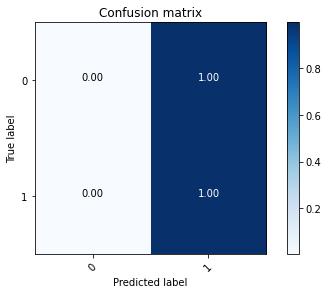

<Figure size 432x288 with 0 Axes>

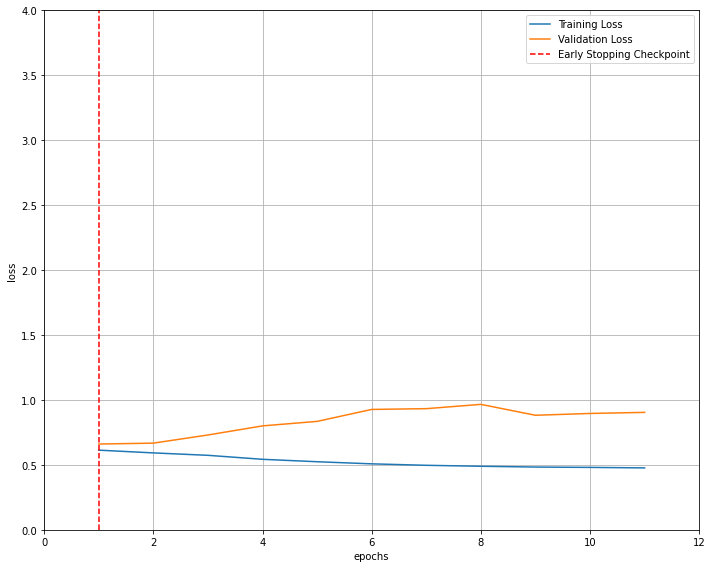

Finished analysis on label attention. Time elapsed 466.7925794124603
Working on label interest
Early stopping
Fold  1! Time elapsed: 72.98089361190796 seconds
Early stopping
Fold  2! Time elapsed: 87.86270308494568 seconds
Early stopping
Fold  3! Time elapsed: 77.95132970809937 seconds
Early stopping
Fold  4! Time elapsed: 87.57638597488403 seconds
Early stopping
Fold  5! Time elapsed: 79.89247226715088 seconds
Normalized confusion matrix


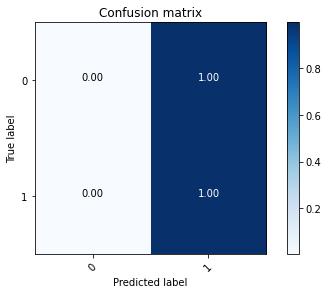

<Figure size 432x288 with 0 Axes>

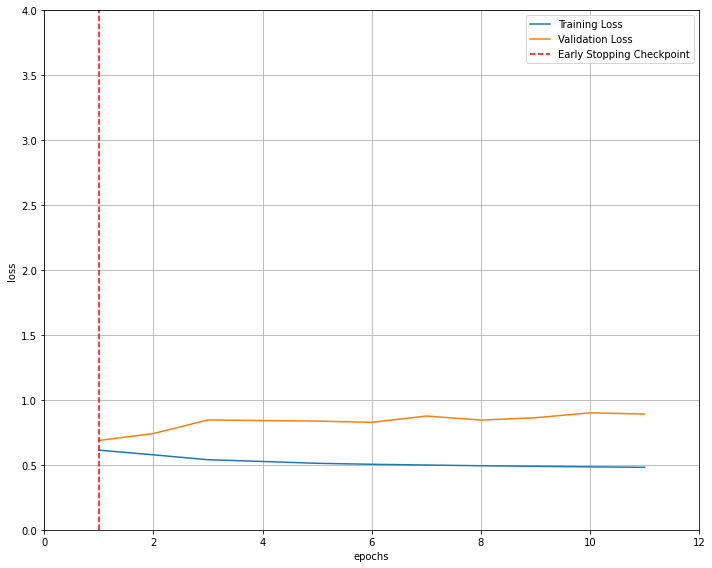

Finished analysis on label interest. Time elapsed 413.5992696285248
Working on label effort
Early stopping
Fold  1! Time elapsed: 75.57930541038513 seconds
Early stopping
Fold  2! Time elapsed: 91.7086353302002 seconds
Early stopping
Fold  3! Time elapsed: 90.47865438461304 seconds
Early stopping
Fold  4! Time elapsed: 88.39152121543884 seconds
Early stopping
Fold  5! Time elapsed: 115.74681782722473 seconds
Normalized confusion matrix


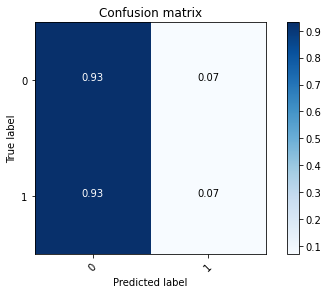

<Figure size 432x288 with 0 Axes>

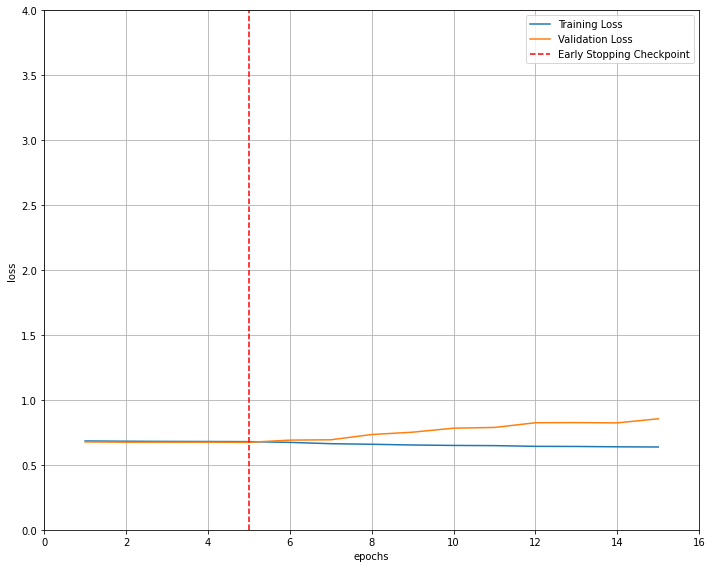

Finished analysis on label effort. Time elapsed 467.84841680526733
Finished analysis on User all
All analyses are complete! Time elapsed: 1349.8578560352325
Working on user 1
Early stopping
Fold  1! Time elapsed: 3.696805715560913 seconds
Early stopping
Fold  2! Time elapsed: 7.984691143035889 seconds
Early stopping
Fold  3! Time elapsed: 13.812939882278442 seconds
Early stopping
Fold  4! Time elapsed: 5.123821496963501 seconds
Normalized confusion matrix


/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/cs/home/ybk1/python/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


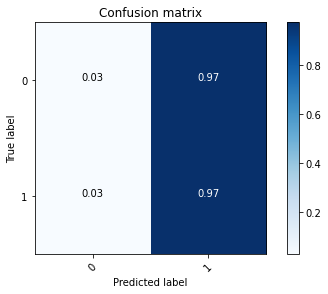

<Figure size 432x288 with 0 Axes>

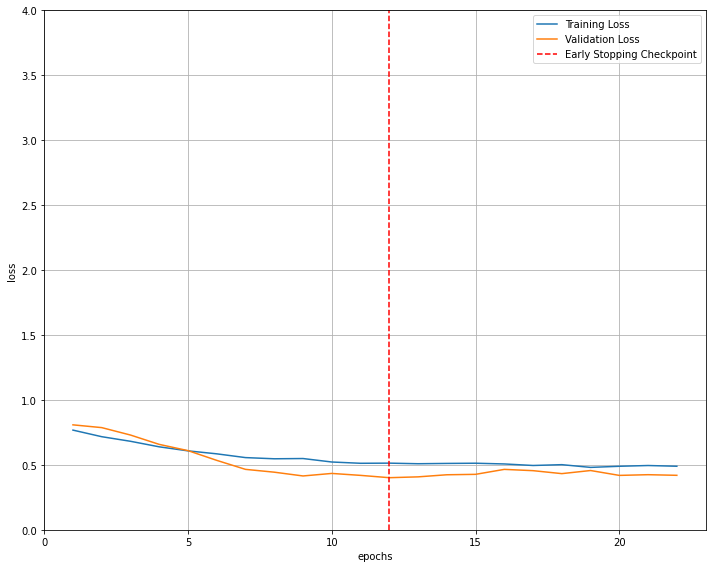

Finished analysis on User 1_attention
Early stopping
Fold  1! Time elapsed: 2.6938838958740234 seconds
Early stopping
Fold  2! Time elapsed: 10.276353597640991 seconds
Early stopping
Fold  3! Time elapsed: 11.48683214187622 seconds
Early stopping
Fold  4! Time elapsed: 7.096750974655151 seconds
Normalized confusion matrix


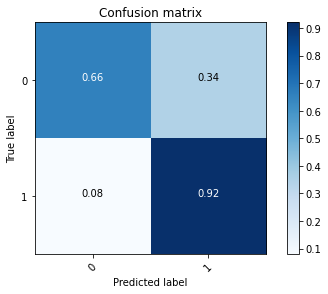

<Figure size 432x288 with 0 Axes>

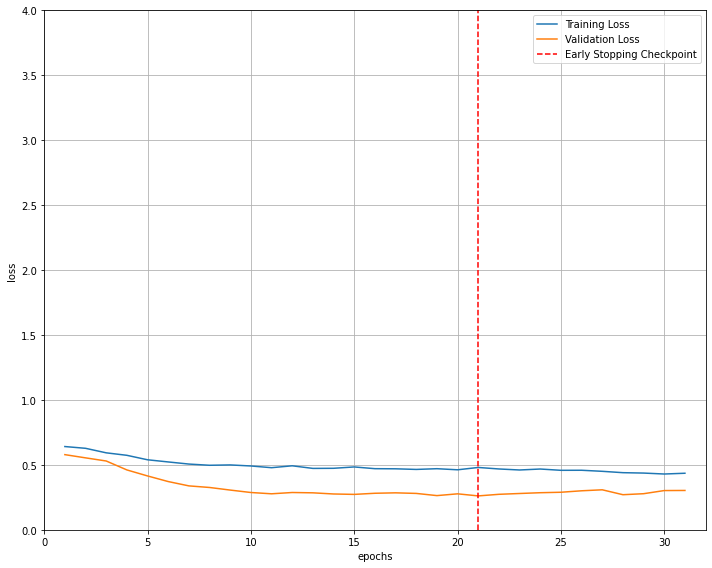

Finished analysis on User 1_interest
Early stopping
Fold  1! Time elapsed: 2.9350712299346924 seconds
Early stopping
Fold  2! Time elapsed: 3.191582441329956 seconds
Early stopping
Fold  3! Time elapsed: 5.967269659042358 seconds
Early stopping
Fold  4! Time elapsed: 6.788285493850708 seconds
Early stopping
Fold  5! Time elapsed: 8.769467830657959 seconds
Normalized confusion matrix


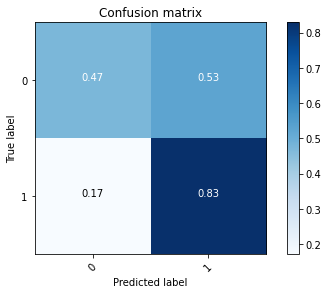

<Figure size 432x288 with 0 Axes>

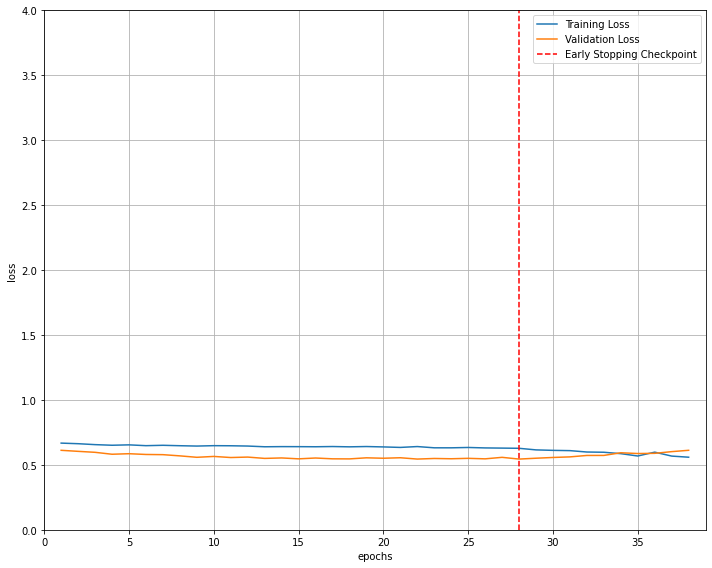

Finished analysis on User 1_effort
Finished analysis on User 1
Working on user 2
Early stopping
Fold  1! Time elapsed: 14.079500436782837 seconds
Early stopping
Fold  2! Time elapsed: 16.015954971313477 seconds
Early stopping
Fold  3! Time elapsed: 29.001678943634033 seconds
Early stopping
Fold  4! Time elapsed: 18.565248727798462 seconds
Normalized confusion matrix


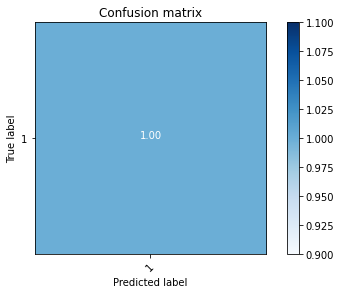

<Figure size 432x288 with 0 Axes>

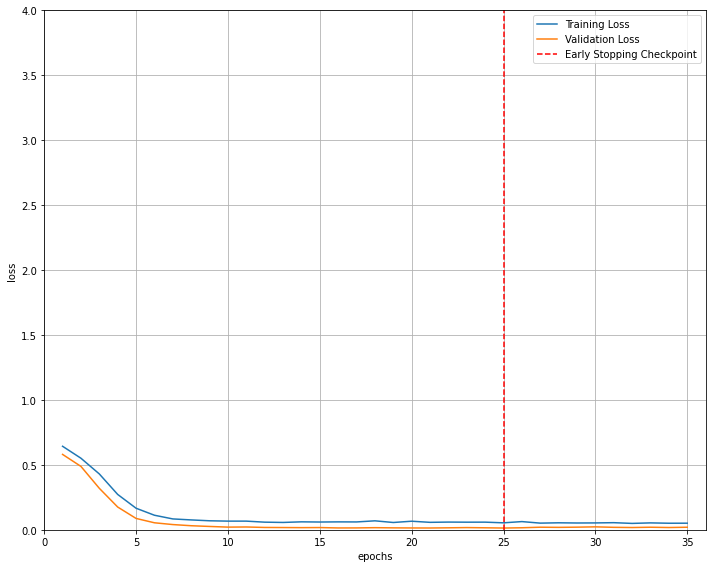

Finished analysis on User 2_attention
Early stopping
Fold  1! Time elapsed: 15.935184001922607 seconds
Early stopping
Fold  2! Time elapsed: 9.845364809036255 seconds
Early stopping
Fold  3! Time elapsed: 8.256366729736328 seconds
Early stopping
Fold  4! Time elapsed: 10.735342979431152 seconds
Normalized confusion matrix


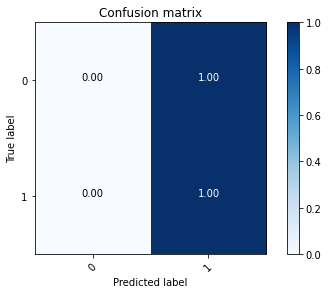

<Figure size 432x288 with 0 Axes>

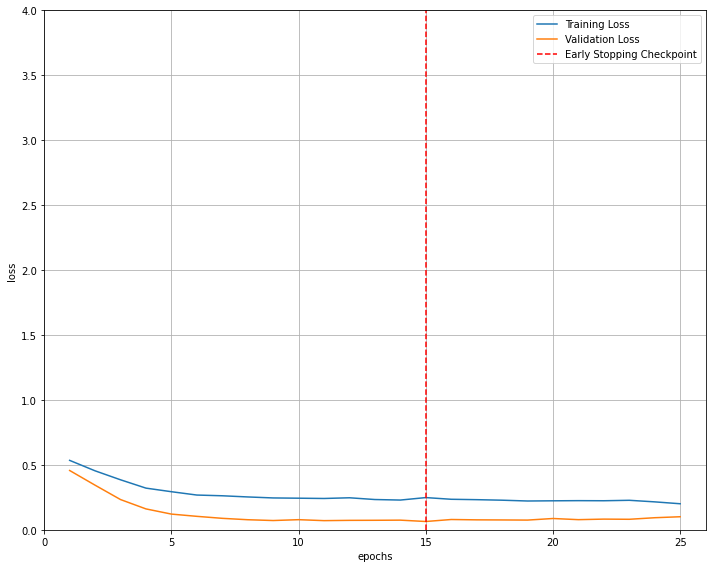

Finished analysis on User 2_interest
Early stopping
Fold  1! Time elapsed: 7.731138229370117 seconds
Early stopping
Fold  2! Time elapsed: 8.181302309036255 seconds
Early stopping
Fold  3! Time elapsed: 8.557459831237793 seconds
Early stopping
Fold  4! Time elapsed: 5.682909965515137 seconds
Early stopping
Fold  5! Time elapsed: 14.52642297744751 seconds
Normalized confusion matrix


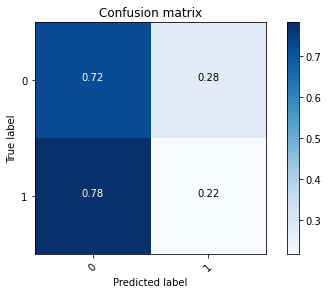

<Figure size 432x288 with 0 Axes>

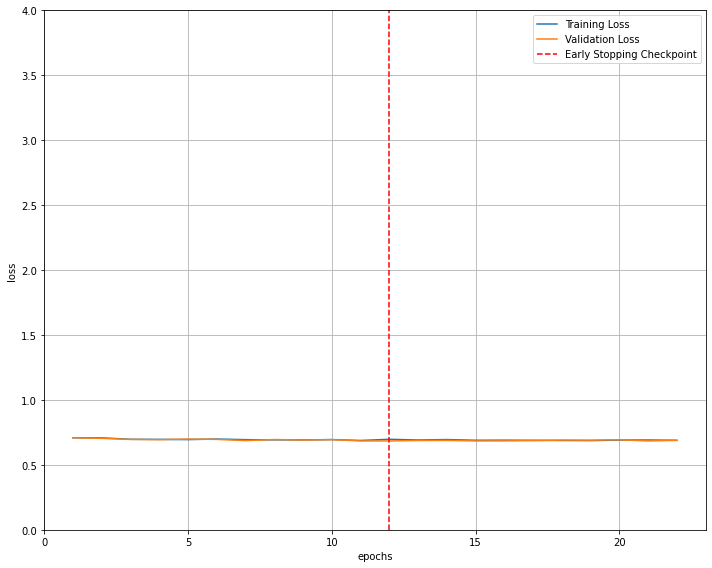

Finished analysis on User 2_effort
Finished analysis on User 2
Working on user 3
Early stopping
Fold  1! Time elapsed: 7.959965944290161 seconds
Early stopping
Fold  2! Time elapsed: 20.983845710754395 seconds
Early stopping
Fold  3! Time elapsed: 6.944971799850464 seconds
Early stopping
Fold  4! Time elapsed: 15.741269588470459 seconds
Early stopping
Fold  5! Time elapsed: 11.899382591247559 seconds
Normalized confusion matrix


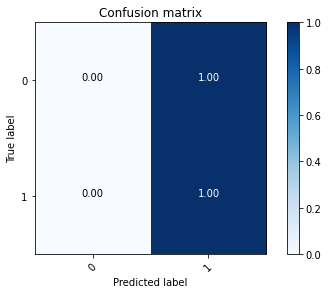

<Figure size 432x288 with 0 Axes>

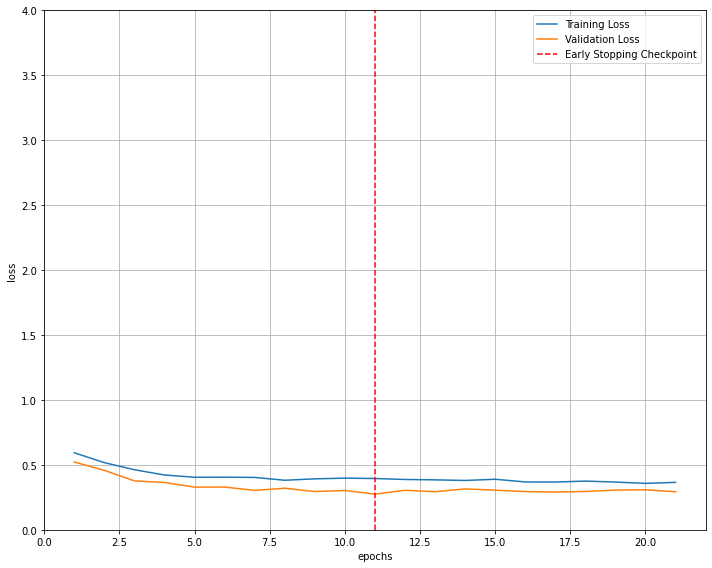

Finished analysis on User 3_attention
Early stopping
Fold  1! Time elapsed: 8.326171159744263 seconds
Early stopping
Fold  2! Time elapsed: 6.276683330535889 seconds
Early stopping
Fold  3! Time elapsed: 12.504382610321045 seconds
Early stopping
Fold  4! Time elapsed: 15.063775062561035 seconds
Early stopping
Fold  5! Time elapsed: 11.986750841140747 seconds
Normalized confusion matrix


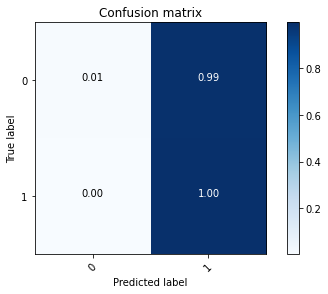

<Figure size 432x288 with 0 Axes>

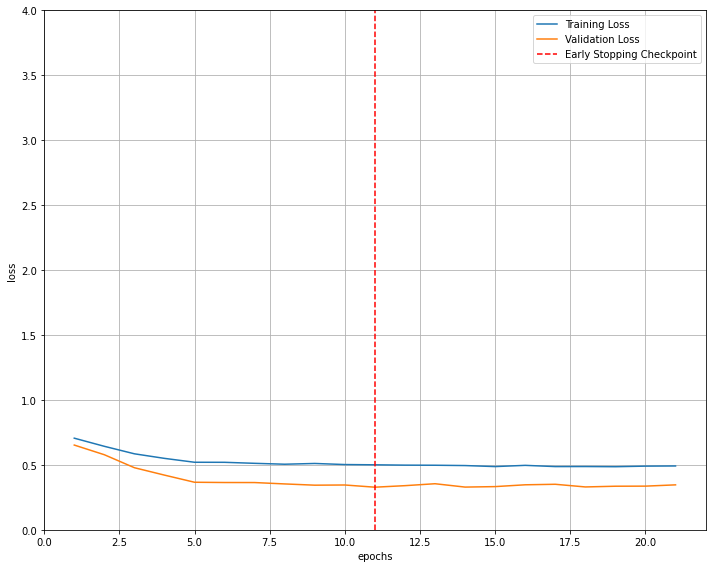

Finished analysis on User 3_interest
Early stopping
Fold  1! Time elapsed: 6.866675615310669 seconds
Early stopping
Fold  2! Time elapsed: 18.978665590286255 seconds
Early stopping
Fold  3! Time elapsed: 7.354323148727417 seconds
Early stopping
Fold  4! Time elapsed: 6.173640012741089 seconds
Early stopping
Fold  5! Time elapsed: 13.793823003768921 seconds
Normalized confusion matrix


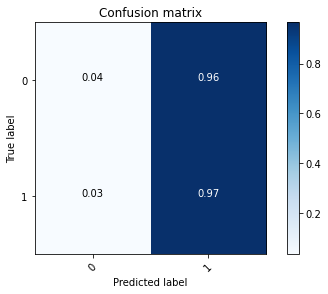

<Figure size 432x288 with 0 Axes>

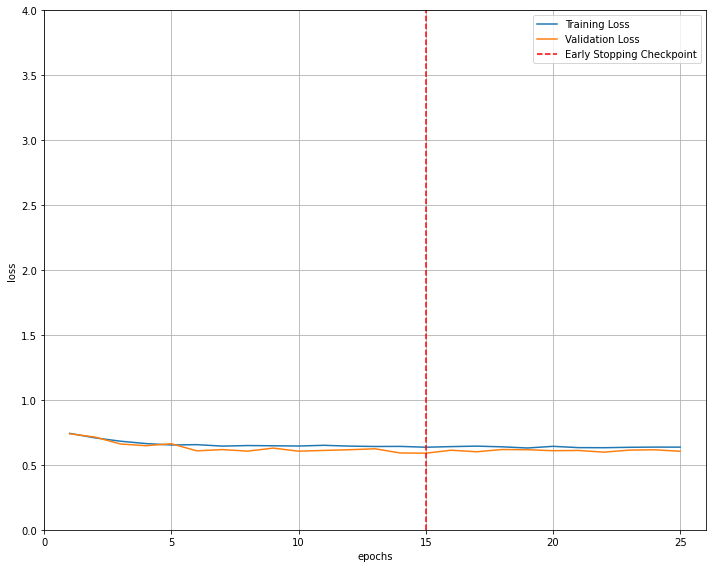

Finished analysis on User 3_effort
Finished analysis on User 3
Working on user 6
Early stopping
Fold  1! Time elapsed: 8.797441959381104 seconds
Early stopping
Fold  2! Time elapsed: 9.310575246810913 seconds
Early stopping
Fold  3! Time elapsed: 11.414936065673828 seconds
Early stopping
Fold  4! Time elapsed: 7.37622857093811 seconds
Early stopping
Fold  5! Time elapsed: 55.89719557762146 seconds
Normalized confusion matrix


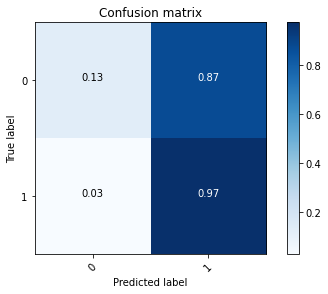

<Figure size 432x288 with 0 Axes>

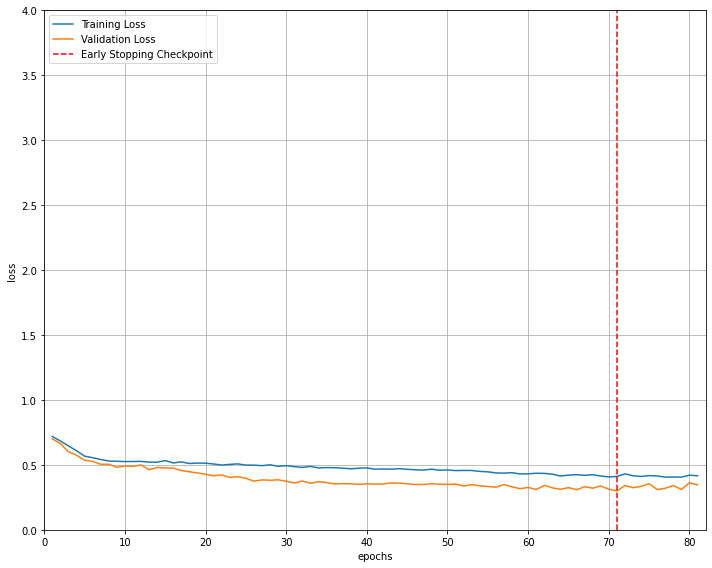

Finished analysis on User 6_attention
Early stopping
Fold  1! Time elapsed: 10.805925607681274 seconds
Early stopping
Fold  2! Time elapsed: 9.016670227050781 seconds
Early stopping
Fold  3! Time elapsed: 18.081560373306274 seconds
Early stopping
Fold  4! Time elapsed: 6.7124083042144775 seconds
Early stopping
Fold  5! Time elapsed: 8.570535898208618 seconds
Normalized confusion matrix


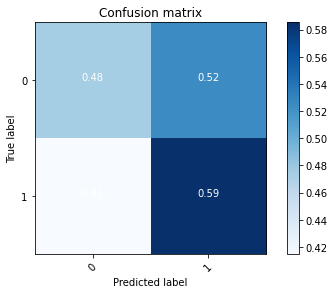

<Figure size 432x288 with 0 Axes>

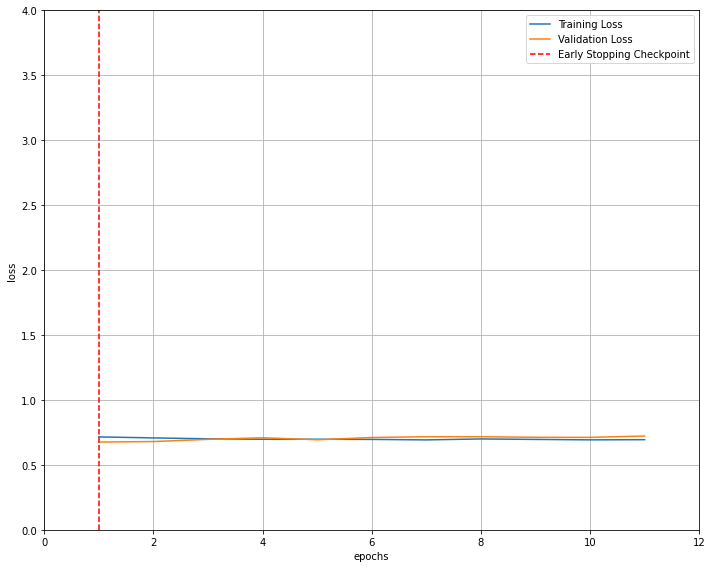

Finished analysis on User 6_interest
Early stopping
Fold  1! Time elapsed: 30.62539792060852 seconds
Early stopping
Fold  2! Time elapsed: 23.90731382369995 seconds
Early stopping
Fold  3! Time elapsed: 14.328818559646606 seconds
Early stopping
Fold  4! Time elapsed: 8.60058856010437 seconds
Early stopping
Fold  5! Time elapsed: 18.884271383285522 seconds
Normalized confusion matrix


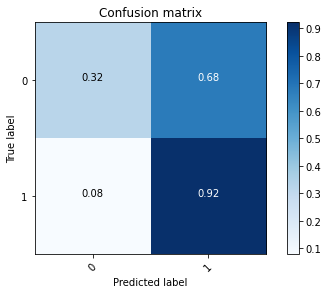

<Figure size 432x288 with 0 Axes>

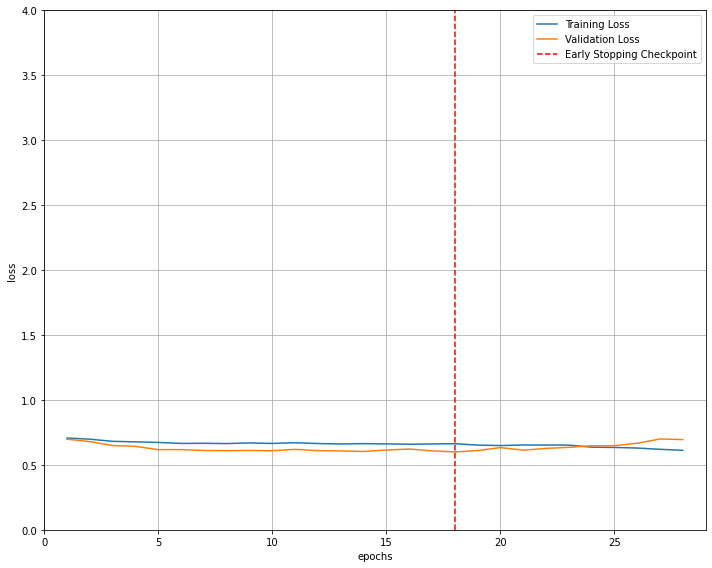

Finished analysis on User 6_effort
Finished analysis on User 6
Working on user 7
Early stopping
Fold  1! Time elapsed: 6.652403116226196 seconds
Early stopping
Fold  2! Time elapsed: 7.434033393859863 seconds
Early stopping
Fold  3! Time elapsed: 8.46849274635315 seconds
Early stopping
Fold  4! Time elapsed: 11.30793809890747 seconds
Normalized confusion matrix


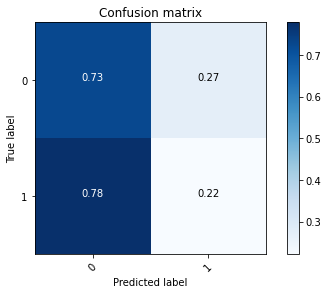

<Figure size 432x288 with 0 Axes>

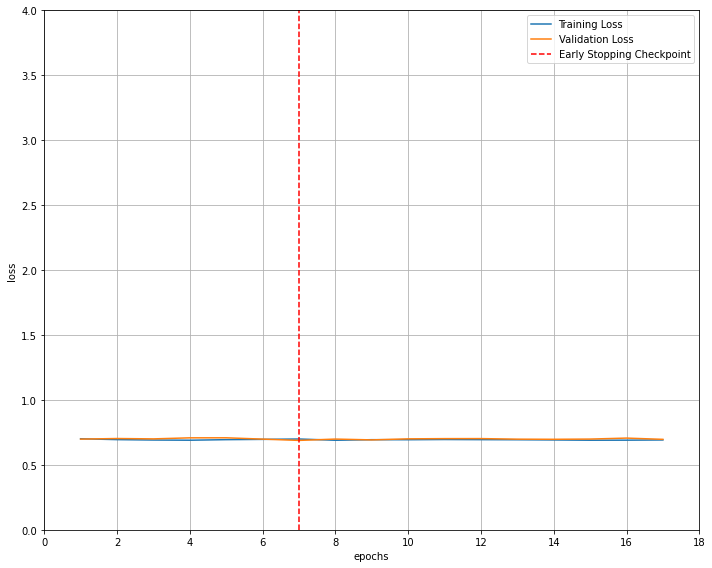

Finished analysis on User 7_attention
Early stopping
Fold  1! Time elapsed: 24.30043649673462 seconds
Early stopping
Fold  2! Time elapsed: 18.270665645599365 seconds
Early stopping
Fold  3! Time elapsed: 16.046348810195923 seconds
Early stopping
Fold  4! Time elapsed: 9.46514630317688 seconds
Normalized confusion matrix


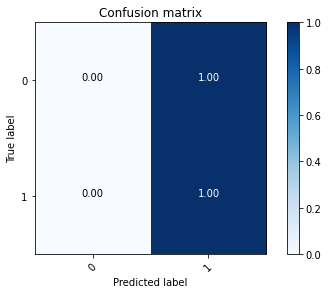

<Figure size 432x288 with 0 Axes>

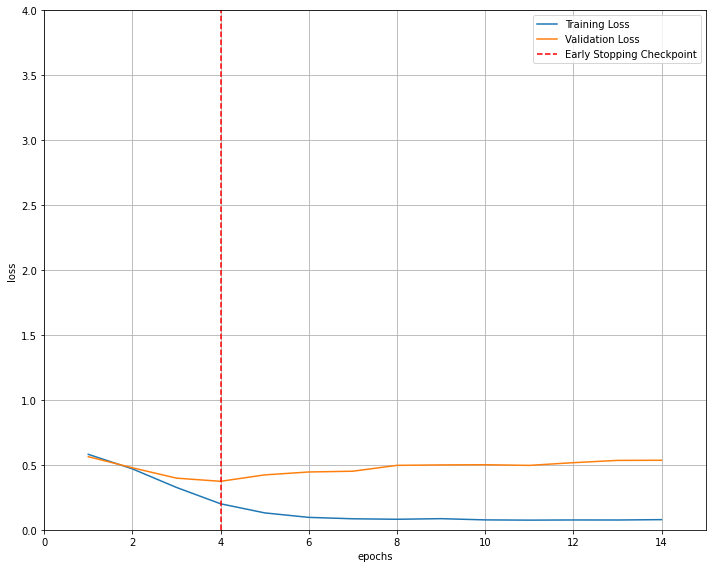

Finished analysis on User 7_interest
Early stopping
Fold  1! Time elapsed: 8.470536708831787 seconds
Early stopping
Fold  2! Time elapsed: 9.35705852508545 seconds
Early stopping
Fold  3! Time elapsed: 6.400935173034668 seconds
Early stopping
Fold  4! Time elapsed: 12.933329582214355 seconds
Early stopping
Fold  5! Time elapsed: 8.48197078704834 seconds
Normalized confusion matrix


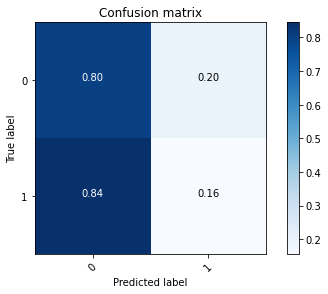

<Figure size 432x288 with 0 Axes>

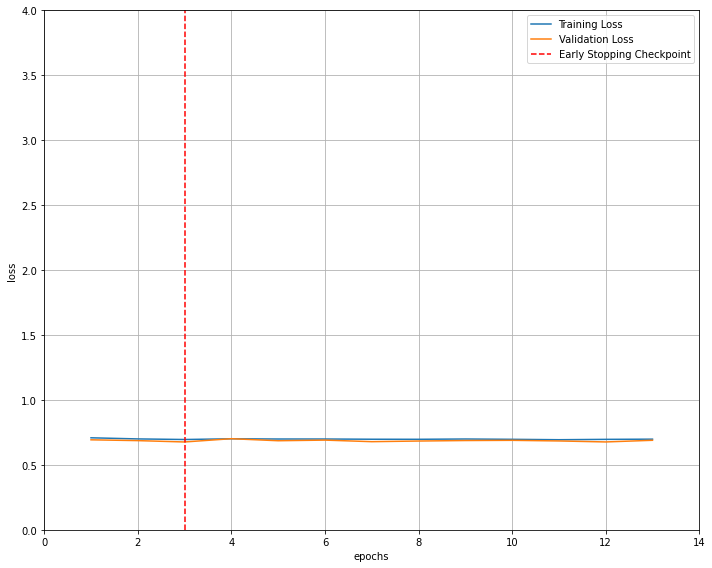

Finished analysis on User 7_effort
Finished analysis on User 7
Working on user 8
Early stopping
Fold  1! Time elapsed: 16.69654130935669 seconds
Early stopping
Fold  2! Time elapsed: 19.684037923812866 seconds
Early stopping
Fold  3! Time elapsed: 32.97000813484192 seconds
Early stopping
Fold  4! Time elapsed: 15.643991470336914 seconds
Early stopping
Fold  5! Time elapsed: 10.797103881835938 seconds
Normalized confusion matrix


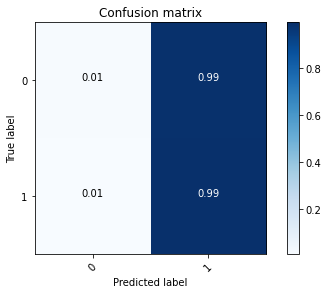

<Figure size 432x288 with 0 Axes>

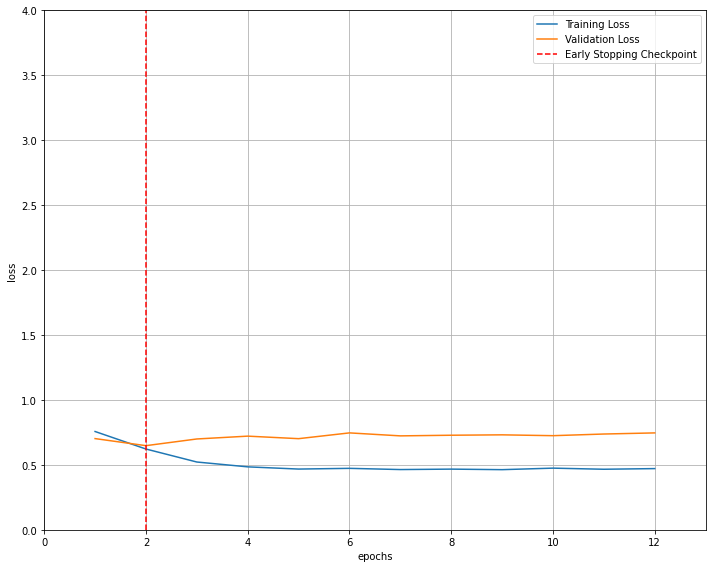

Finished analysis on User 8_attention
Early stopping
Fold  1! Time elapsed: 20.395811080932617 seconds
Early stopping
Fold  2! Time elapsed: 24.74770760536194 seconds
Early stopping
Fold  3! Time elapsed: 20.823506355285645 seconds
Early stopping
Fold  4! Time elapsed: 15.31875991821289 seconds
Early stopping
Fold  5! Time elapsed: 37.77085256576538 seconds
Normalized confusion matrix


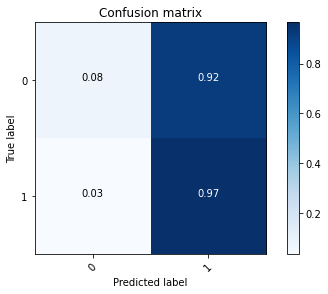

<Figure size 432x288 with 0 Axes>

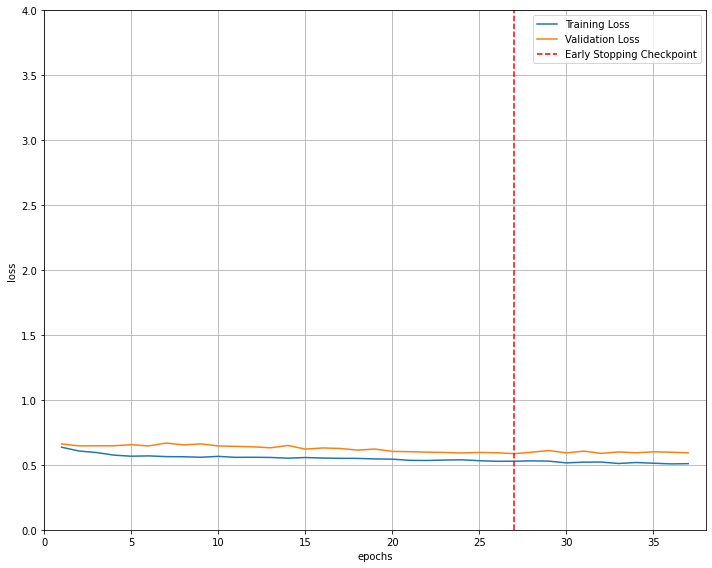

Finished analysis on User 8_interest
Early stopping
Fold  1! Time elapsed: 18.73185920715332 seconds
Early stopping
Fold  2! Time elapsed: 10.362953662872314 seconds
Early stopping
Fold  3! Time elapsed: 22.931090354919434 seconds
Early stopping
Fold  4! Time elapsed: 13.796133756637573 seconds
Early stopping
Fold  5! Time elapsed: 10.901483535766602 seconds
Normalized confusion matrix


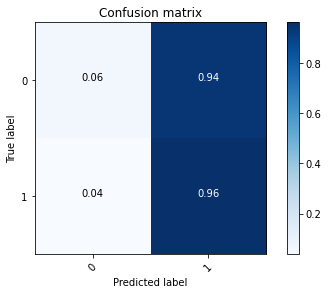

<Figure size 432x288 with 0 Axes>

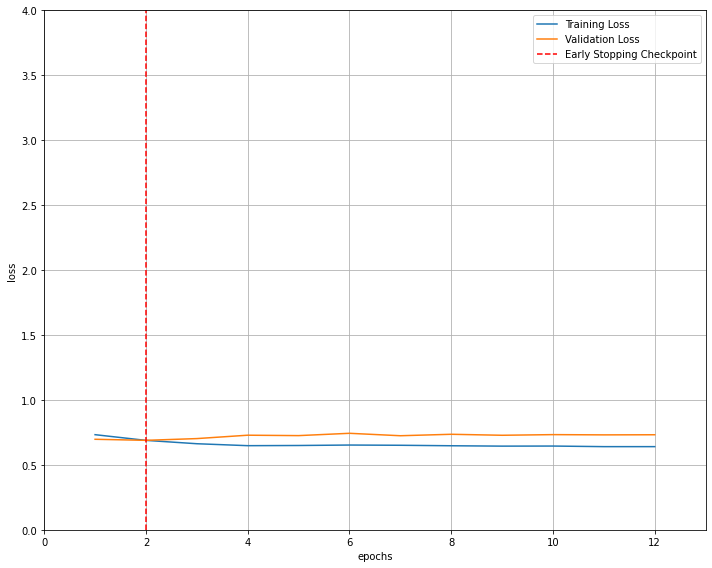

Finished analysis on User 8_effort
Finished analysis on User 8
Working on user 9
Early stopping
Fold  1! Time elapsed: 41.67378878593445 seconds
Early stopping
Fold  2! Time elapsed: 22.721429109573364 seconds
Early stopping
Fold  3! Time elapsed: 41.86701512336731 seconds
Early stopping
Fold  4! Time elapsed: 15.163111925125122 seconds
Early stopping
Fold  5! Time elapsed: 10.79181456565857 seconds
Normalized confusion matrix


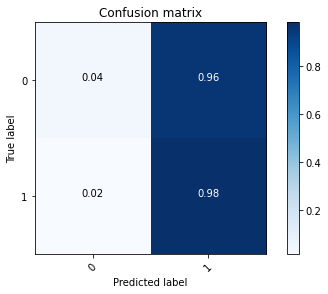

<Figure size 432x288 with 0 Axes>

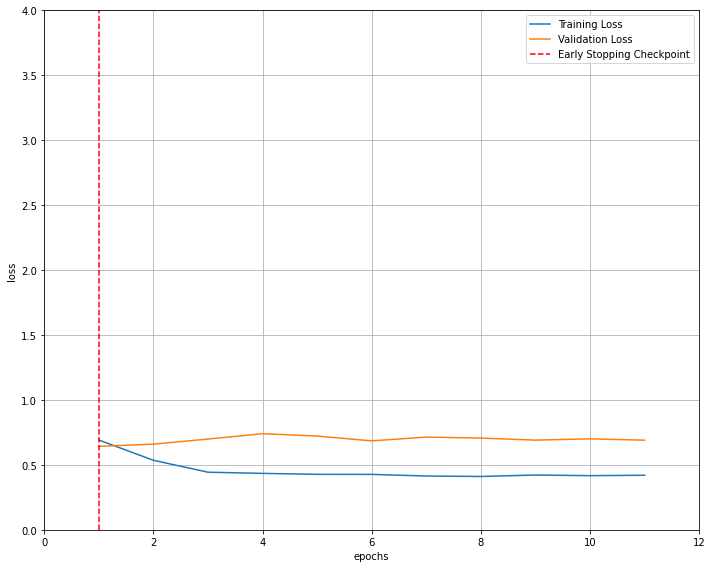

Finished analysis on User 9_attention
Early stopping
Fold  1! Time elapsed: 14.452718019485474 seconds
Early stopping
Fold  2! Time elapsed: 15.95619821548462 seconds
Early stopping
Fold  3! Time elapsed: 30.892500162124634 seconds
Early stopping
Fold  4! Time elapsed: 40.81047964096069 seconds
Early stopping
Fold  5! Time elapsed: 11.793217897415161 seconds
Normalized confusion matrix


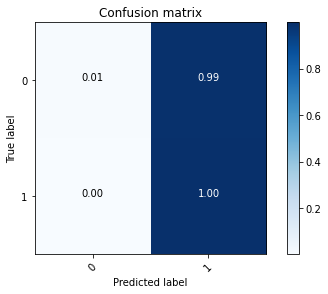

<Figure size 432x288 with 0 Axes>

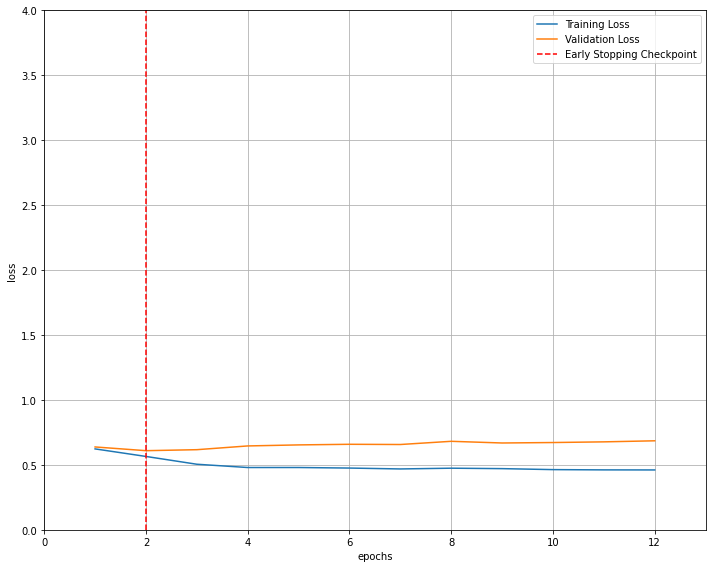

Finished analysis on User 9_interest
Early stopping
Fold  1! Time elapsed: 12.182461738586426 seconds
Early stopping
Fold  2! Time elapsed: 10.555960893630981 seconds
Early stopping
Fold  3! Time elapsed: 20.500017404556274 seconds
Early stopping
Fold  4! Time elapsed: 18.48054552078247 seconds
Early stopping
Fold  5! Time elapsed: 26.463066816329956 seconds
Normalized confusion matrix


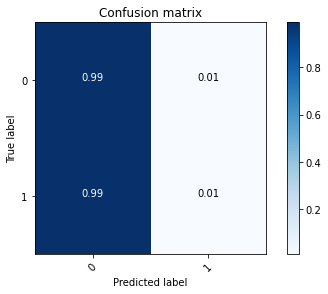

<Figure size 432x288 with 0 Axes>

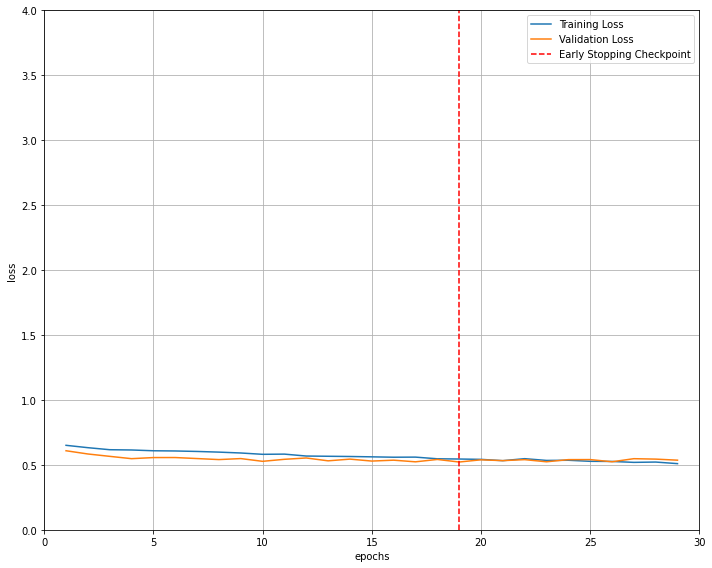

Finished analysis on User 9_effort
Finished analysis on User 9
Working on user 10
Early stopping
Fold  1! Time elapsed: 2.1362690925598145 seconds
Early stopping
Fold  2! Time elapsed: 2.0672268867492676 seconds
Early stopping
Fold  3! Time elapsed: 2.56246018409729 seconds
Early stopping
Fold  4! Time elapsed: 1.741309404373169 seconds
Early stopping
Fold  5! Time elapsed: 1.9107425212860107 seconds
Normalized confusion matrix


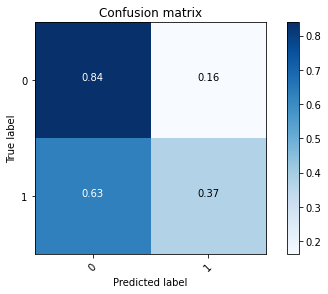

<Figure size 432x288 with 0 Axes>

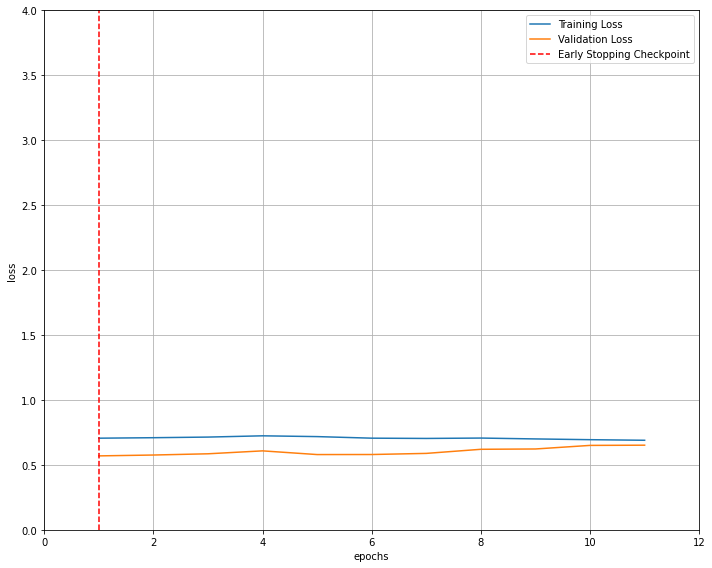

Finished analysis on User 10_attention
Early stopping
Fold  1! Time elapsed: 1.9997193813323975 seconds
Early stopping
Fold  2! Time elapsed: 1.9171853065490723 seconds
Early stopping
Fold  3! Time elapsed: 4.294579267501831 seconds
Early stopping
Fold  4! Time elapsed: 1.2031855583190918 seconds
Early stopping
Fold  5! Time elapsed: 2.5703704357147217 seconds
Normalized confusion matrix


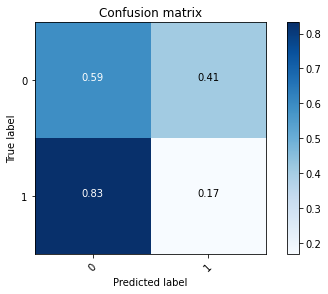

<Figure size 432x288 with 0 Axes>

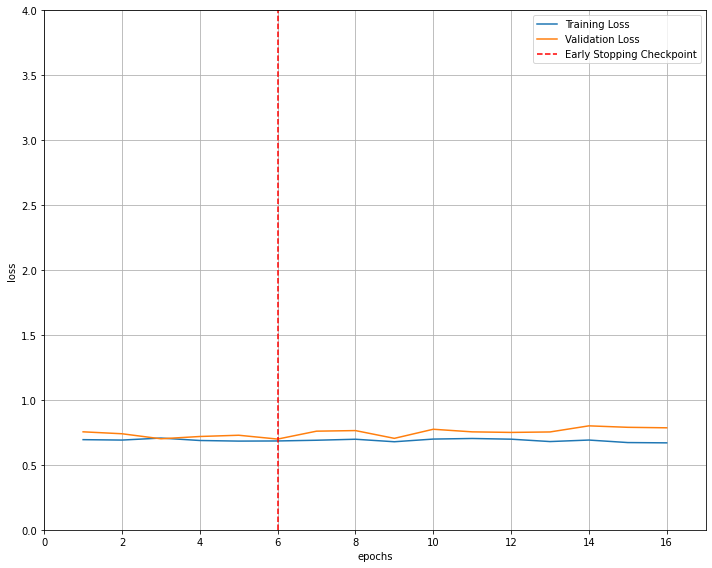

Finished analysis on User 10_interest
Early stopping
Fold  1! Time elapsed: 4.000790596008301 seconds
Early stopping
Fold  2! Time elapsed: 2.6511943340301514 seconds
Early stopping
Fold  3! Time elapsed: 1.573509931564331 seconds
Early stopping
Fold  4! Time elapsed: 2.014249324798584 seconds
Early stopping
Fold  5! Time elapsed: 8.412971258163452 seconds
Normalized confusion matrix


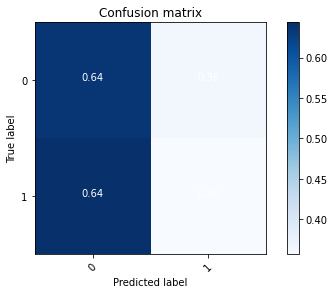

<Figure size 432x288 with 0 Axes>

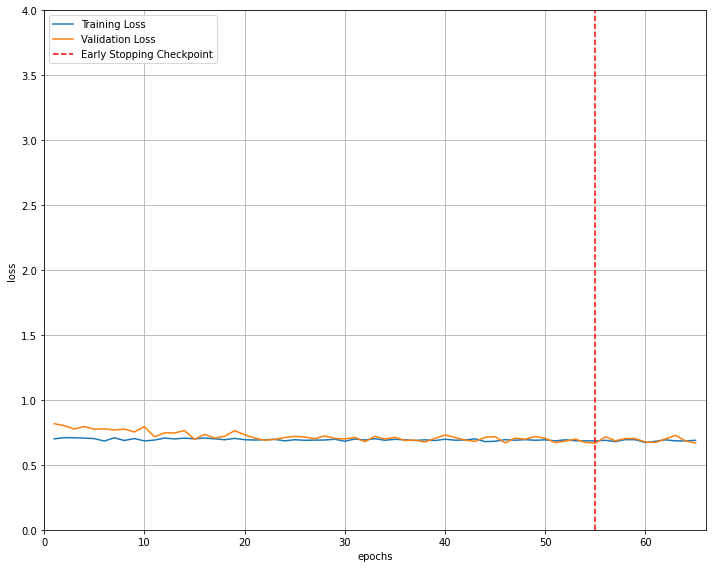

Finished analysis on User 10_effort
Finished analysis on User 10
Working on user 11
Early stopping
Fold  1! Time elapsed: 7.995789051055908 seconds
Early stopping
Fold  2! Time elapsed: 4.412288665771484 seconds
Early stopping
Fold  3! Time elapsed: 9.870198011398315 seconds
Early stopping
Fold  4! Time elapsed: 6.996904373168945 seconds
Early stopping
Fold  5! Time elapsed: 3.4709436893463135 seconds
Normalized confusion matrix


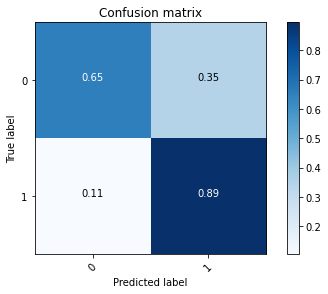

<Figure size 432x288 with 0 Axes>

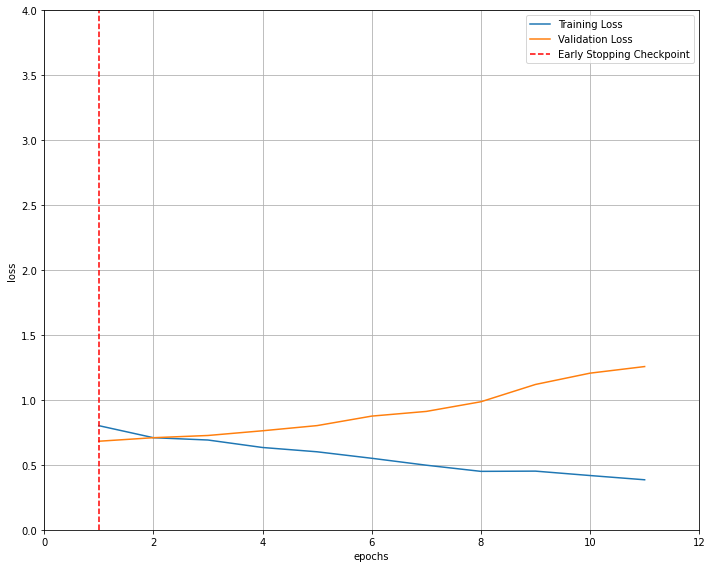

Finished analysis on User 11_attention
Early stopping
Fold  1! Time elapsed: 12.53796648979187 seconds
Early stopping
Fold  2! Time elapsed: 3.4521303176879883 seconds
Early stopping
Fold  3! Time elapsed: 9.828705787658691 seconds
Early stopping
Fold  4! Time elapsed: 9.651732683181763 seconds
Early stopping
Fold  5! Time elapsed: 3.472290277481079 seconds
Normalized confusion matrix


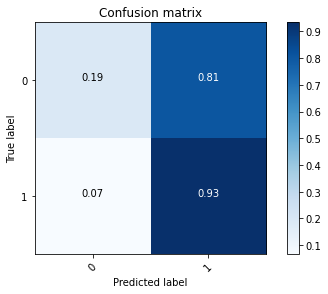

<Figure size 432x288 with 0 Axes>

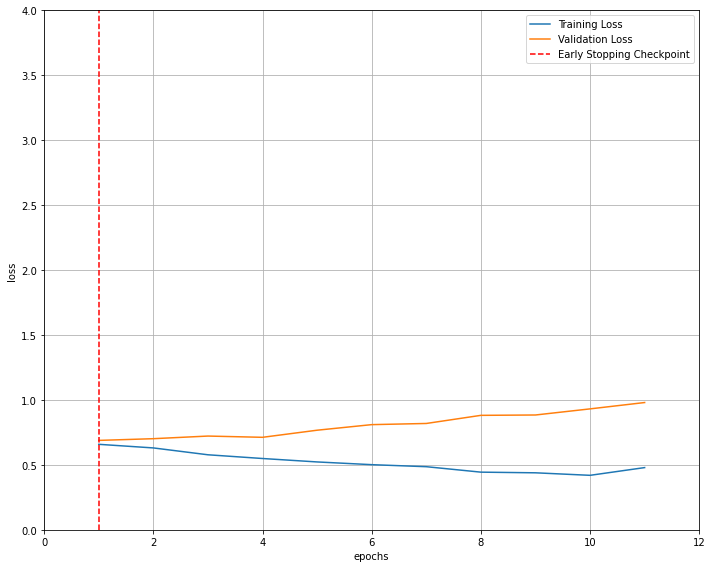

Finished analysis on User 11_interest
Early stopping
Fold  1! Time elapsed: 6.609633207321167 seconds
Early stopping
Fold  2! Time elapsed: 8.071472406387329 seconds
Early stopping
Fold  3! Time elapsed: 9.838256120681763 seconds
Early stopping
Fold  4! Time elapsed: 5.6646857261657715 seconds
Early stopping
Fold  5! Time elapsed: 14.892001390457153 seconds
Normalized confusion matrix


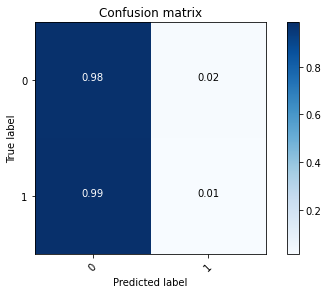

<Figure size 432x288 with 0 Axes>

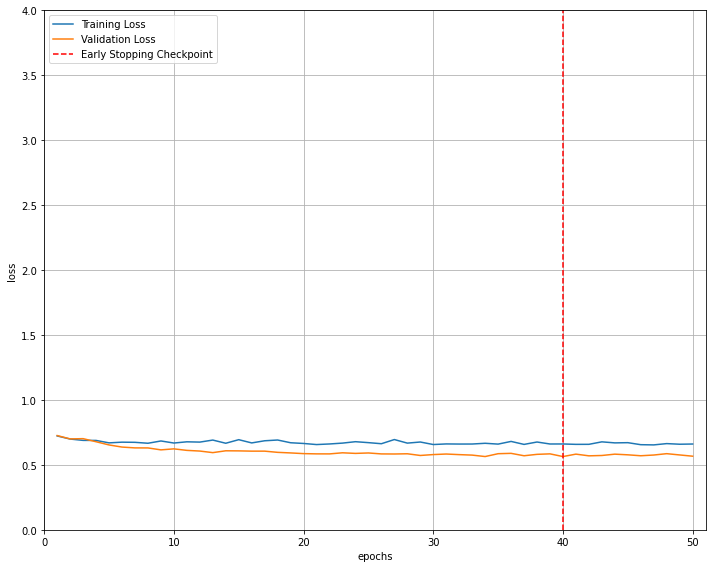

Finished analysis on User 11_effort
Finished analysis on User 11
Working on user 12
Early stopping
Fold  1! Time elapsed: 0.7567665576934814 seconds
Early stopping
Fold  2! Time elapsed: 1.4343743324279785 seconds
Early stopping
Fold  3! Time elapsed: 0.27082276344299316 seconds
Early stopping
Fold  4! Time elapsed: 3.4418888092041016 seconds
Early stopping
Fold  5! Time elapsed: 1.6144943237304688 seconds
Normalized confusion matrix


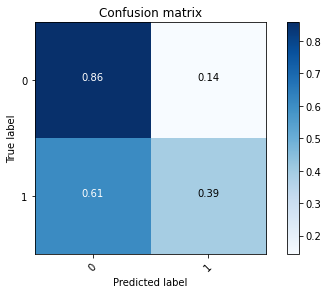

<Figure size 432x288 with 0 Axes>

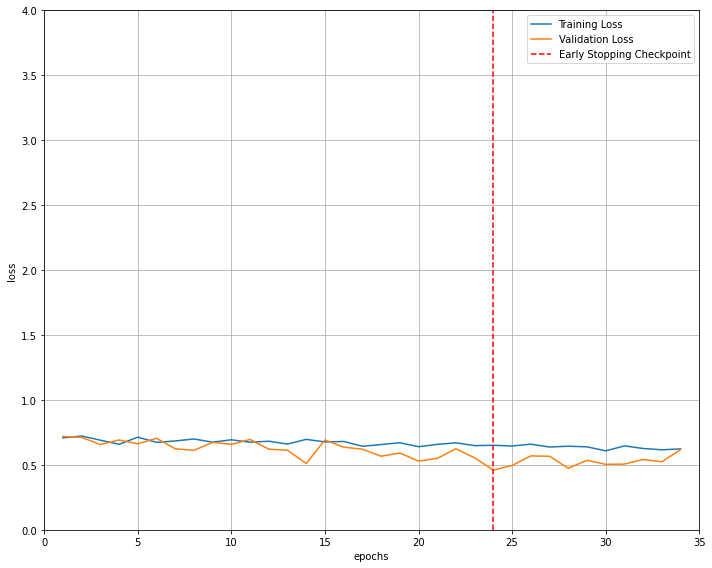

Finished analysis on User 12_attention
Early stopping
Fold  1! Time elapsed: 0.9688074588775635 seconds
Early stopping
Fold  2! Time elapsed: 0.6119322776794434 seconds
Early stopping
Fold  3! Time elapsed: 0.6893682479858398 seconds
Early stopping
Fold  4! Time elapsed: 0.7803213596343994 seconds
Normalized confusion matrix


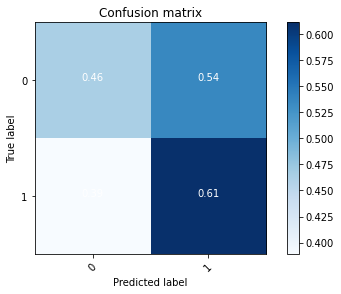

<Figure size 432x288 with 0 Axes>

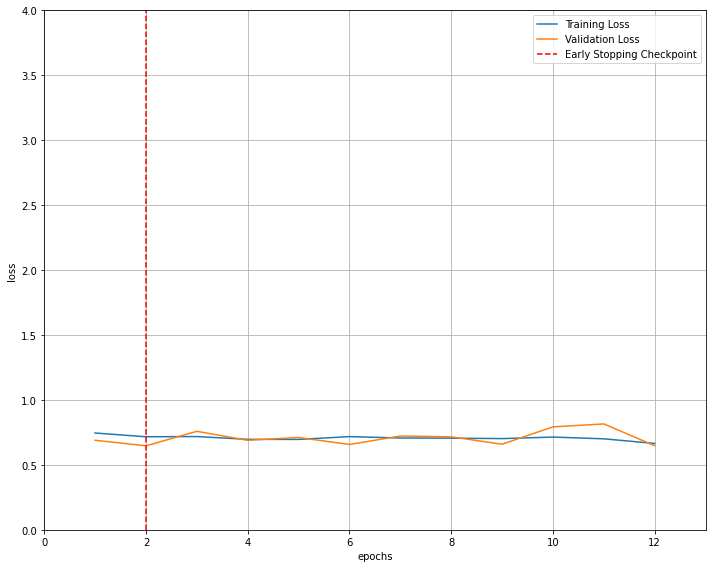

Finished analysis on User 12_interest
Early stopping
Fold  1! Time elapsed: 1.5581779479980469 seconds
Early stopping
Fold  2! Time elapsed: 0.5273268222808838 seconds
Early stopping
Fold  3! Time elapsed: 0.4943413734436035 seconds
Normalized confusion matrix


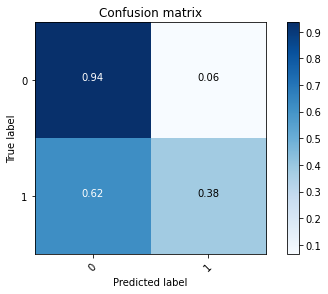

<Figure size 432x288 with 0 Axes>

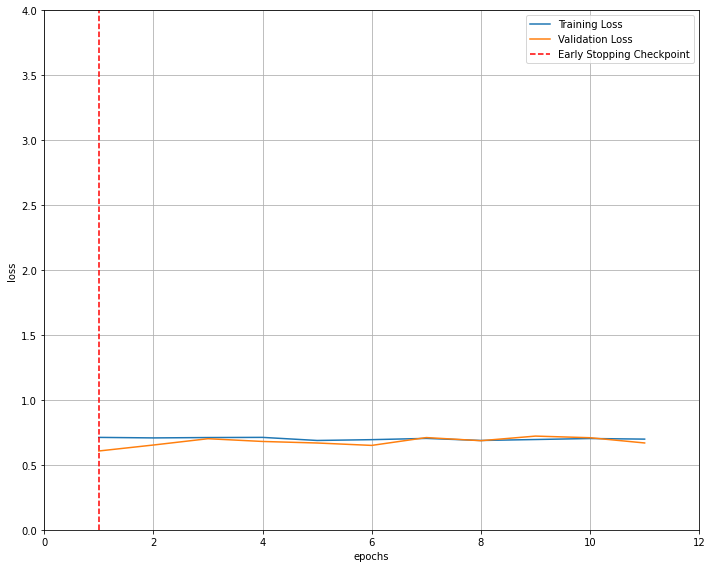

Finished analysis on User 12_effort
Finished analysis on User 12
Working on user 17
Early stopping
Fold  1! Time elapsed: 6.647387504577637 seconds
Early stopping
Fold  2! Time elapsed: 9.121796369552612 seconds
Early stopping
Fold  3! Time elapsed: 9.883872270584106 seconds
Early stopping
Fold  4! Time elapsed: 8.121848583221436 seconds
Early stopping
Fold  5! Time elapsed: 16.384808778762817 seconds
Normalized confusion matrix


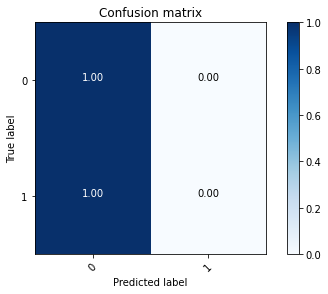

<Figure size 432x288 with 0 Axes>

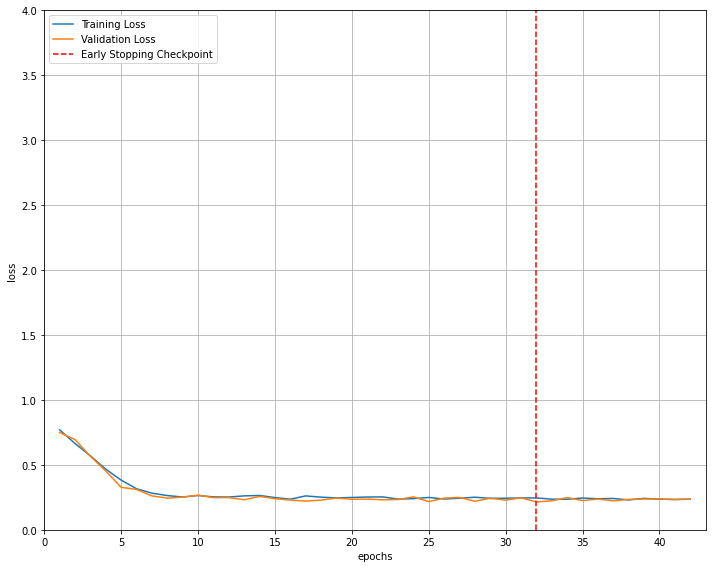

Finished analysis on User 17_attention
Early stopping
Fold  1! Time elapsed: 9.196667909622192 seconds
Early stopping
Fold  2! Time elapsed: 8.841790199279785 seconds
Early stopping
Fold  3! Time elapsed: 11.186092376708984 seconds
Early stopping
Fold  4! Time elapsed: 8.408280372619629 seconds
Early stopping
Fold  5! Time elapsed: 28.310248613357544 seconds
Normalized confusion matrix


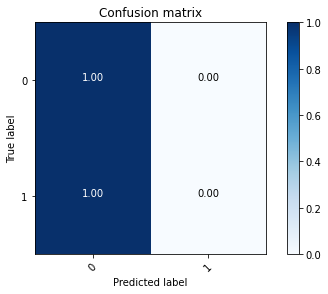

<Figure size 432x288 with 0 Axes>

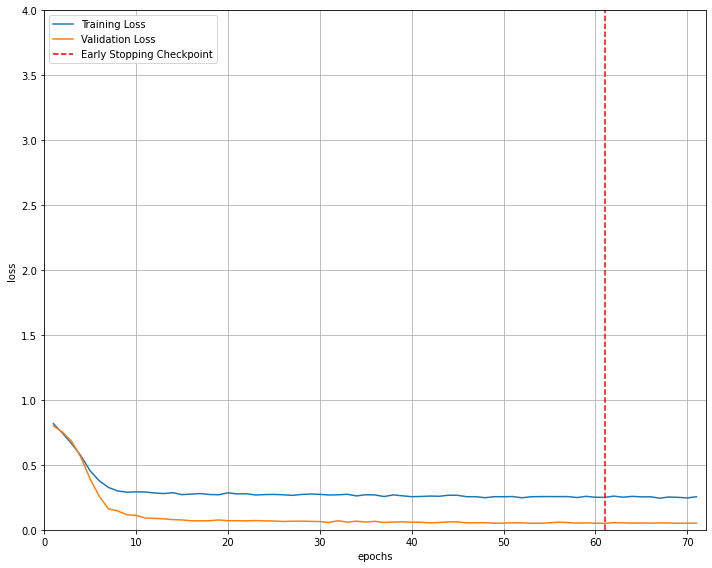

Finished analysis on User 17_interest
Early stopping
Fold  1! Time elapsed: 9.646475791931152 seconds
Early stopping
Fold  2! Time elapsed: 8.497275829315186 seconds
Early stopping
Fold  3! Time elapsed: 6.197403907775879 seconds
Early stopping
Fold  4! Time elapsed: 9.667202472686768 seconds
Early stopping
Fold  5! Time elapsed: 6.67910099029541 seconds
Normalized confusion matrix


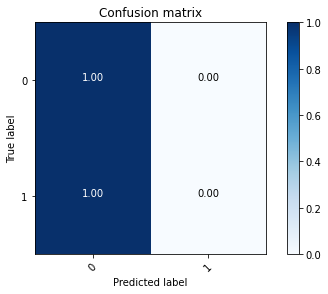

<Figure size 432x288 with 0 Axes>

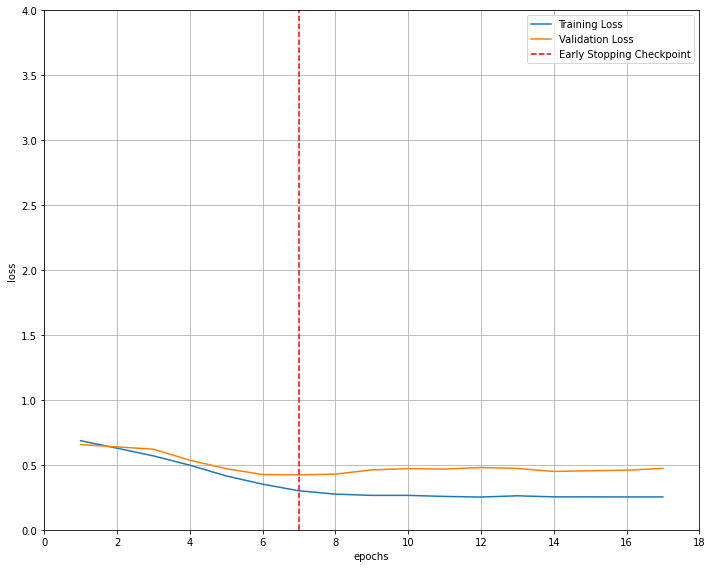

Finished analysis on User 17_effort
Finished analysis on User 17
Working on user 18
Early stopping
Fold  1! Time elapsed: 9.603915691375732 seconds
Early stopping
Fold  2! Time elapsed: 7.863394498825073 seconds
Early stopping
Fold  3! Time elapsed: 16.830028772354126 seconds
Early stopping
Fold  4! Time elapsed: 17.958568334579468 seconds
Early stopping
Fold  5! Time elapsed: 6.879978179931641 seconds
Normalized confusion matrix


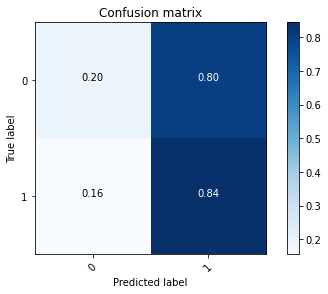

<Figure size 432x288 with 0 Axes>

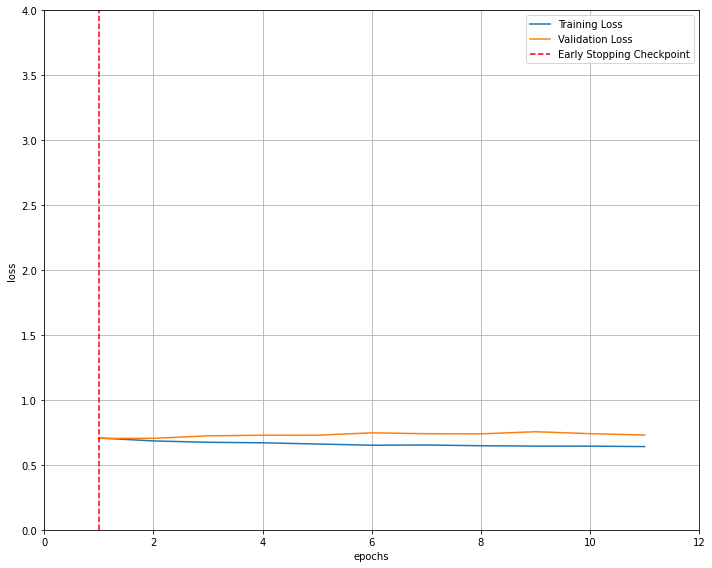

Finished analysis on User 18_attention
Early stopping
Fold  1! Time elapsed: 6.6450722217559814 seconds
Early stopping
Fold  2! Time elapsed: 8.229448795318604 seconds
Early stopping
Fold  3! Time elapsed: 39.52110409736633 seconds
Early stopping
Fold  4! Time elapsed: 7.421298027038574 seconds
Normalized confusion matrix


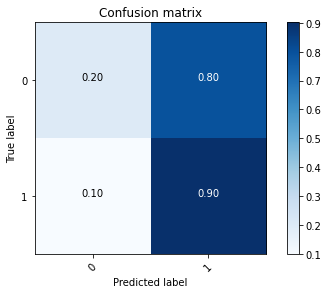

<Figure size 432x288 with 0 Axes>

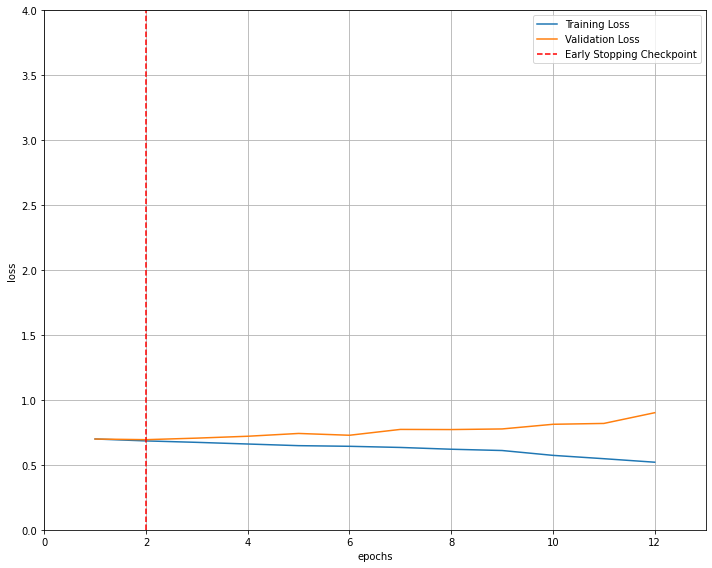

Finished analysis on User 18_interest
Early stopping
Fold  1! Time elapsed: 7.610422372817993 seconds
Early stopping
Fold  2! Time elapsed: 29.784144639968872 seconds
Early stopping
Fold  3! Time elapsed: 13.191938877105713 seconds
Early stopping
Fold  4! Time elapsed: 18.636176586151123 seconds
Early stopping
Fold  5! Time elapsed: 9.81187891960144 seconds
Normalized confusion matrix


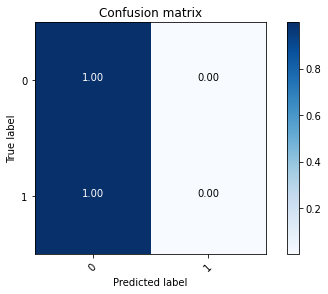

<Figure size 432x288 with 0 Axes>

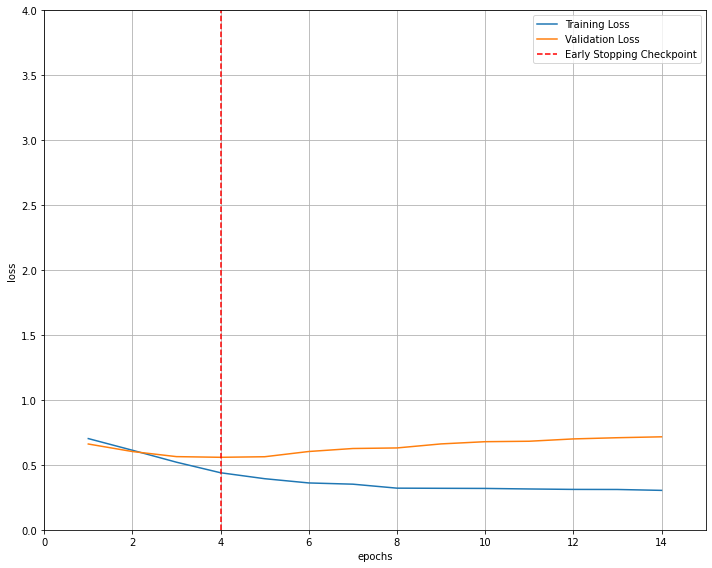

Finished analysis on User 18_effort
Finished analysis on User 18
Working on user 19
Early stopping
Fold  1! Time elapsed: 11.915504693984985 seconds
Early stopping
Fold  2! Time elapsed: 1.982440710067749 seconds
Early stopping
Fold  3! Time elapsed: 12.869925022125244 seconds
Early stopping
Fold  4! Time elapsed: 5.753270149230957 seconds
Normalized confusion matrix


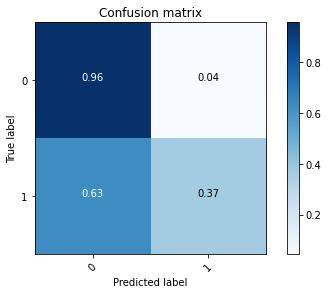

<Figure size 432x288 with 0 Axes>

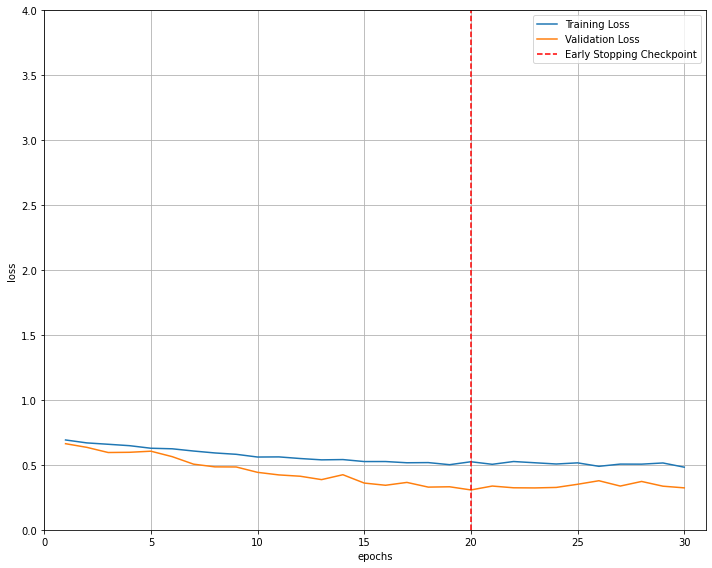

Finished analysis on User 19_attention
Early stopping
Fold  1! Time elapsed: 11.537069082260132 seconds
Early stopping
Fold  2! Time elapsed: 2.144390106201172 seconds
Early stopping
Fold  3! Time elapsed: 8.61867642402649 seconds
Early stopping
Fold  4! Time elapsed: 2.720837116241455 seconds
Normalized confusion matrix


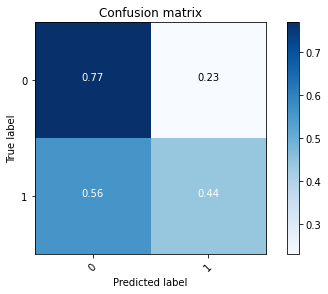

<Figure size 432x288 with 0 Axes>

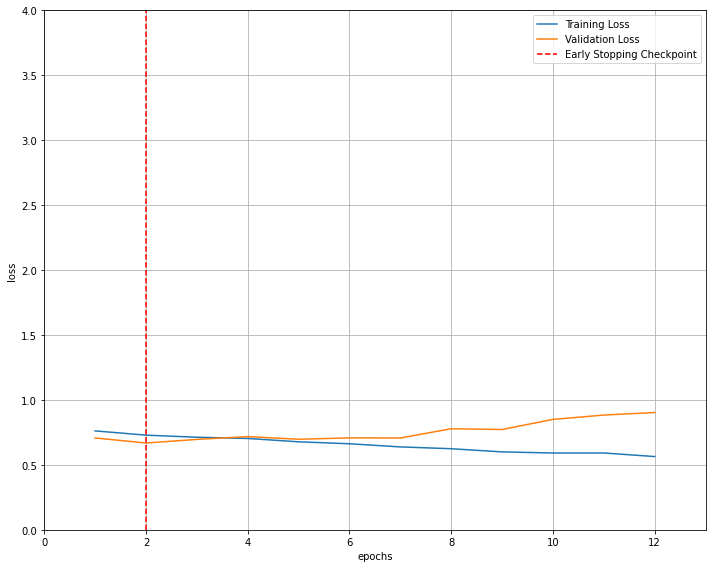

Finished analysis on User 19_interest
Early stopping
Fold  1! Time elapsed: 8.960559368133545 seconds
Early stopping
Fold  2! Time elapsed: 6.888331890106201 seconds
Early stopping
Fold  3! Time elapsed: 1.6906397342681885 seconds
Early stopping
Fold  4! Time elapsed: 11.891833782196045 seconds
Early stopping
Fold  5! Time elapsed: 9.138496398925781 seconds
Normalized confusion matrix


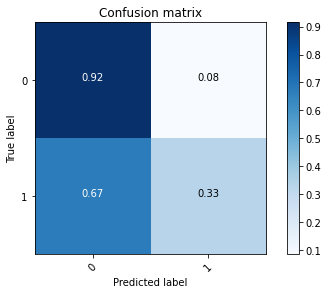

<Figure size 432x288 with 0 Axes>

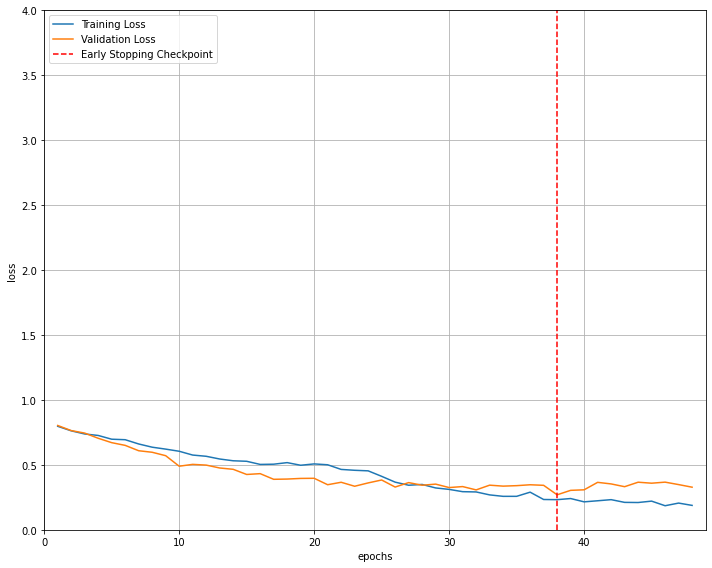

Finished analysis on User 19_effort
Finished analysis on User 19
Working on user 20
Early stopping
Fold  1! Time elapsed: 6.199918508529663 seconds
Early stopping
Fold  2! Time elapsed: 12.98548173904419 seconds
Early stopping
Fold  3! Time elapsed: 10.757075071334839 seconds
Early stopping
Fold  4! Time elapsed: 19.72522211074829 seconds
Early stopping
Fold  5! Time elapsed: 7.328117609024048 seconds
Normalized confusion matrix


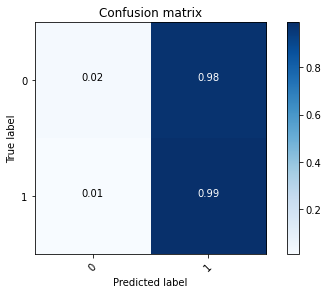

<Figure size 432x288 with 0 Axes>

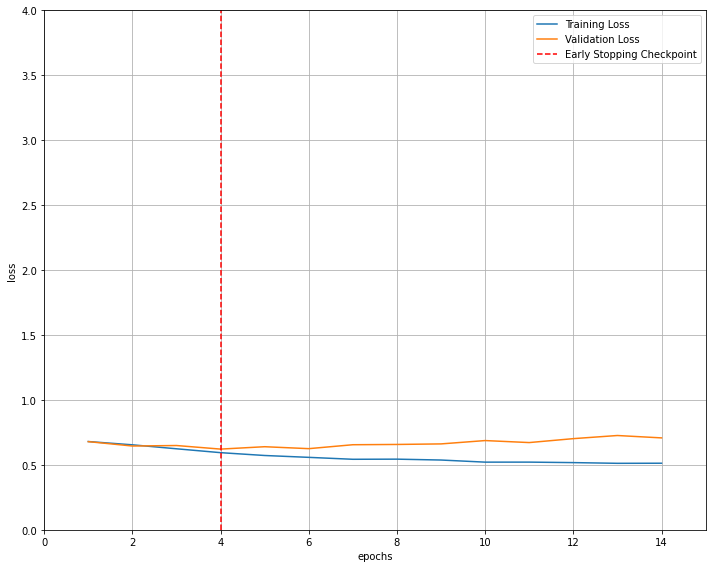

Finished analysis on User 20_attention
Early stopping
Fold  1! Time elapsed: 6.96191143989563 seconds
Early stopping
Fold  2! Time elapsed: 26.172811269760132 seconds
Early stopping
Fold  3! Time elapsed: 8.919476985931396 seconds
Early stopping
Fold  4! Time elapsed: 16.82265019416809 seconds
Early stopping
Fold  5! Time elapsed: 7.393173694610596 seconds
Normalized confusion matrix


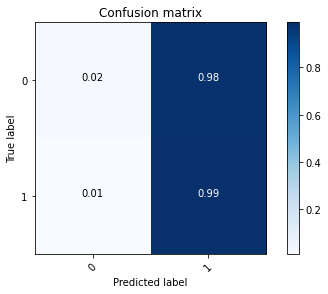

<Figure size 432x288 with 0 Axes>

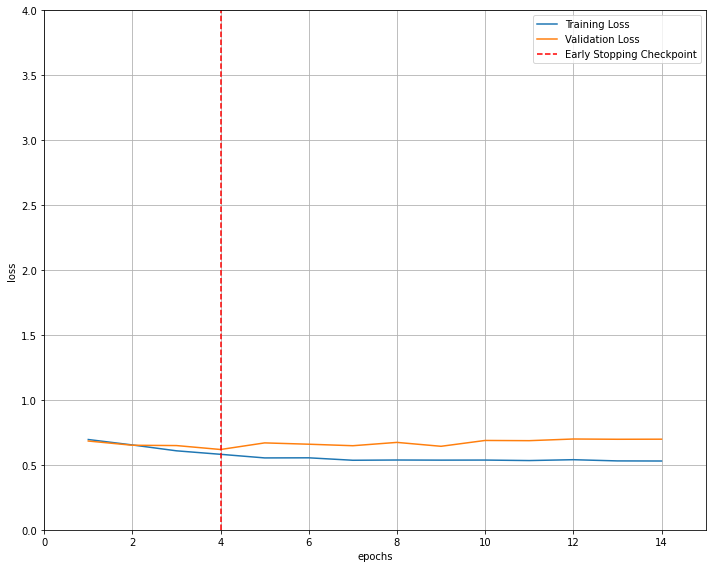

Finished analysis on User 20_interest
Early stopping
Fold  1! Time elapsed: 7.746732711791992 seconds
Early stopping
Fold  2! Time elapsed: 6.01560115814209 seconds
Early stopping
Fold  3! Time elapsed: 6.99501371383667 seconds
Early stopping
Fold  4! Time elapsed: 13.425732374191284 seconds
Early stopping
Fold  5! Time elapsed: 6.098096132278442 seconds
Normalized confusion matrix


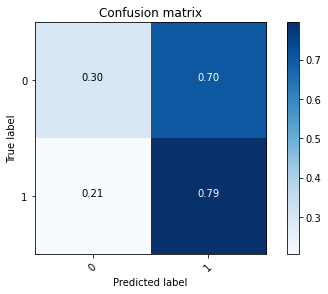

<Figure size 432x288 with 0 Axes>

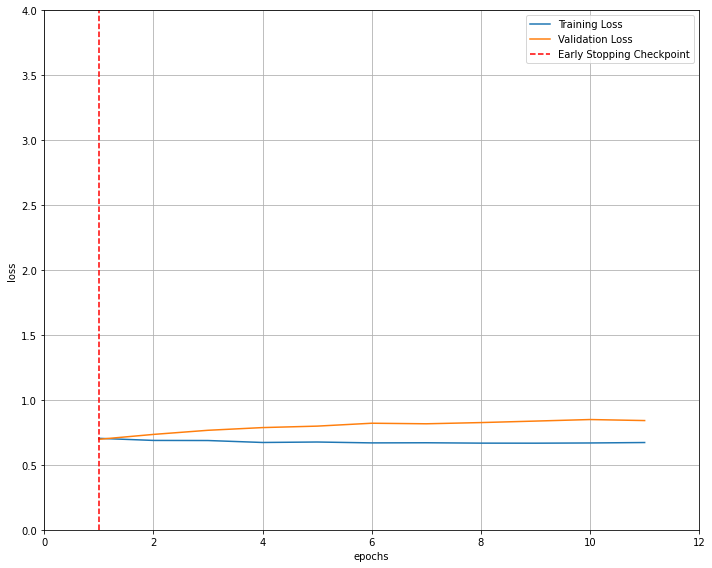

Finished analysis on User 20_effort
Finished analysis on User 20
Working on user 22
Early stopping
Fold  1! Time elapsed: 7.209913969039917 seconds
Early stopping
Fold  2! Time elapsed: 12.181162357330322 seconds
Early stopping
Fold  3! Time elapsed: 16.99903702735901 seconds
Early stopping
Fold  4! Time elapsed: 12.422263383865356 seconds
Early stopping
Fold  5! Time elapsed: 7.86738133430481 seconds
Normalized confusion matrix


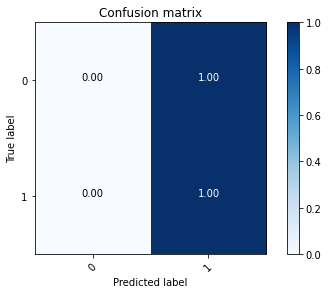

<Figure size 432x288 with 0 Axes>

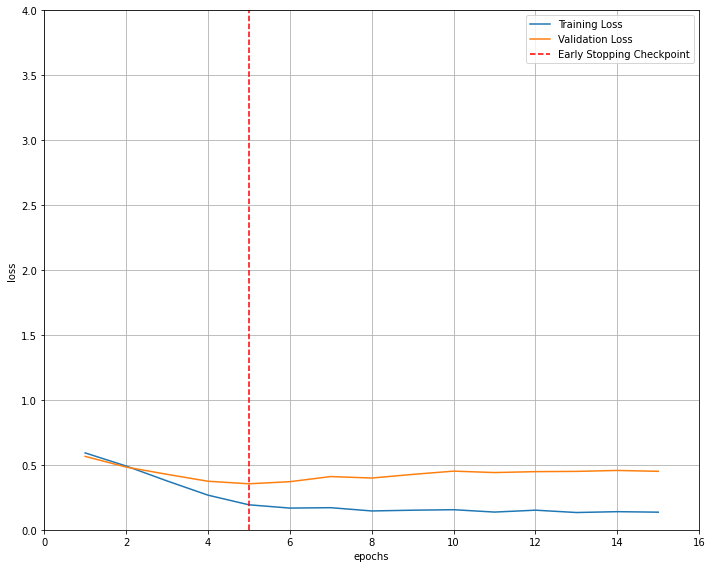

Finished analysis on User 22_attention
Early stopping
Fold  1! Time elapsed: 11.919609069824219 seconds
Early stopping
Fold  2! Time elapsed: 8.289676666259766 seconds
Early stopping
Fold  3! Time elapsed: 14.302713394165039 seconds
Early stopping
Fold  4! Time elapsed: 9.26317310333252 seconds
Normalized confusion matrix


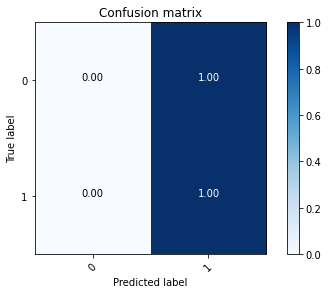

<Figure size 432x288 with 0 Axes>

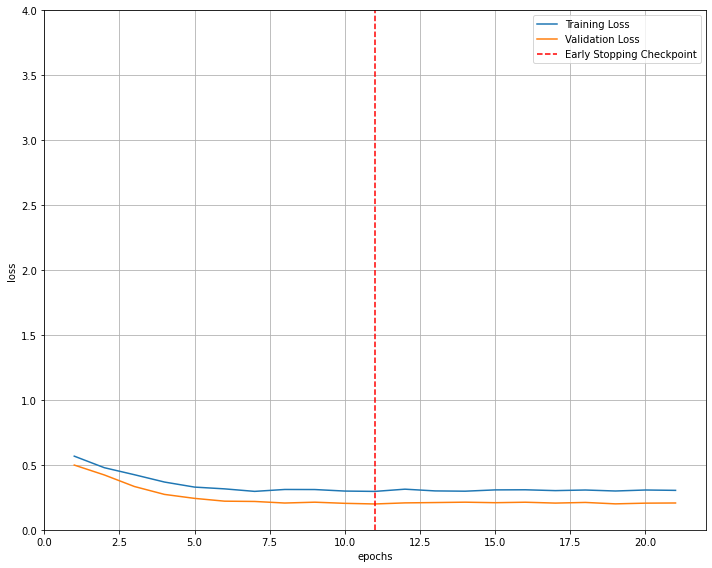

Finished analysis on User 22_interest
Early stopping
Fold  1! Time elapsed: 7.14669942855835 seconds
Early stopping
Fold  2! Time elapsed: 15.995847463607788 seconds
Early stopping
Fold  3! Time elapsed: 12.914612054824829 seconds
Early stopping
Fold  4! Time elapsed: 7.017322063446045 seconds
Normalized confusion matrix


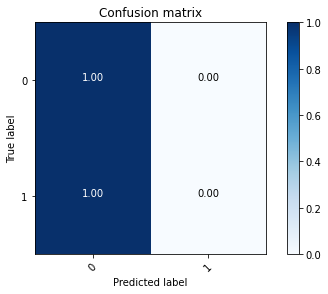

<Figure size 432x288 with 0 Axes>

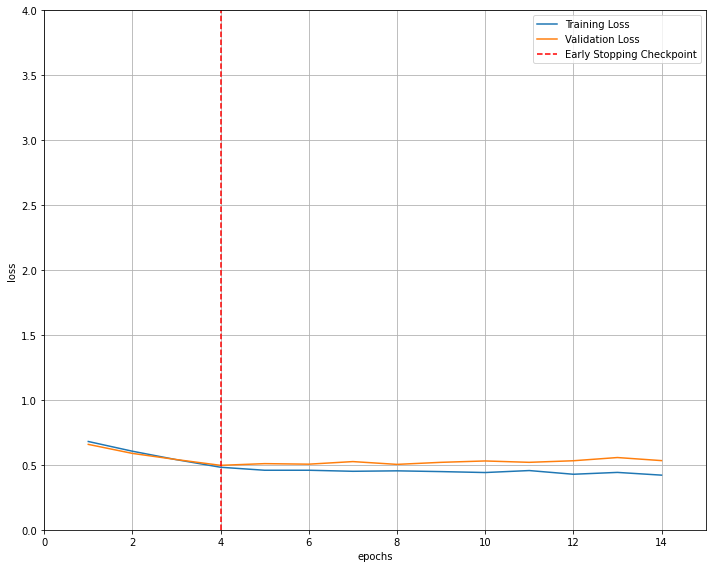

Finished analysis on User 22_effort
Finished analysis on User 22
Working on user 23
Early stopping
Fold  1! Time elapsed: 9.918045043945312 seconds
Early stopping
Fold  2! Time elapsed: 10.339773654937744 seconds
Early stopping
Fold  3! Time elapsed: 13.933210849761963 seconds
Early stopping
Fold  4! Time elapsed: 15.089958190917969 seconds
Early stopping
Fold  5! Time elapsed: 16.889201164245605 seconds
Normalized confusion matrix


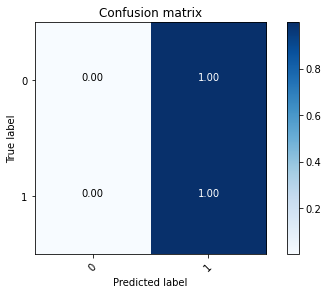

<Figure size 432x288 with 0 Axes>

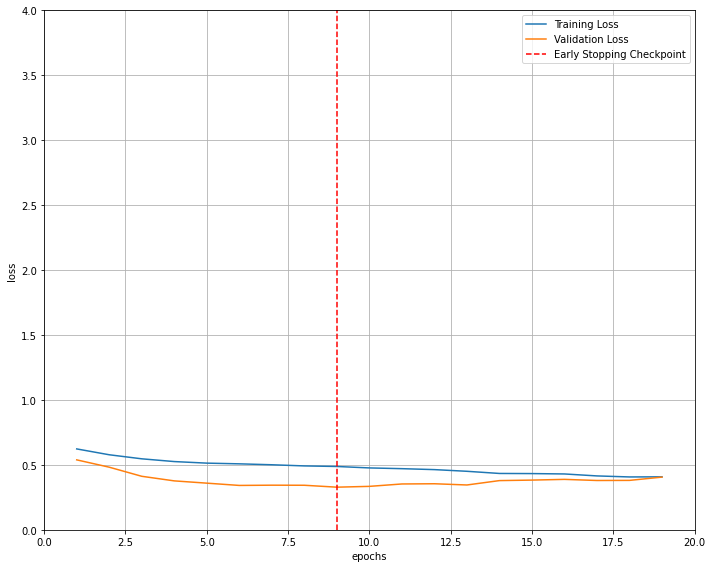

Finished analysis on User 23_attention
Early stopping
Fold  1! Time elapsed: 10.859004020690918 seconds
Early stopping
Fold  2! Time elapsed: 10.373973608016968 seconds
Early stopping
Fold  3! Time elapsed: 13.479480504989624 seconds
Early stopping
Fold  4! Time elapsed: 39.557055711746216 seconds
Early stopping
Fold  5! Time elapsed: 10.621507406234741 seconds
Normalized confusion matrix


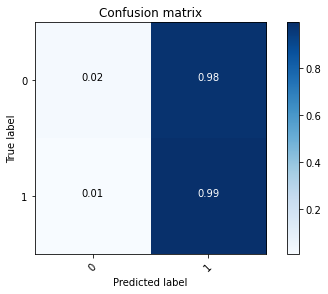

<Figure size 432x288 with 0 Axes>

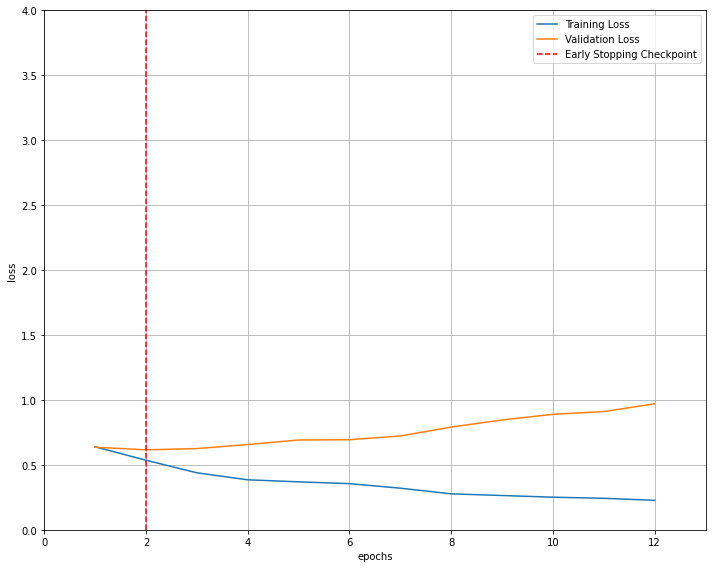

Finished analysis on User 23_interest
Early stopping
Fold  1! Time elapsed: 6.939878225326538 seconds
Early stopping
Fold  2! Time elapsed: 16.614413738250732 seconds
Early stopping
Fold  3! Time elapsed: 17.259400367736816 seconds
Early stopping
Fold  4! Time elapsed: 9.357666969299316 seconds
Normalized confusion matrix


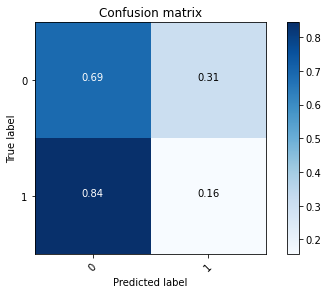

<Figure size 432x288 with 0 Axes>

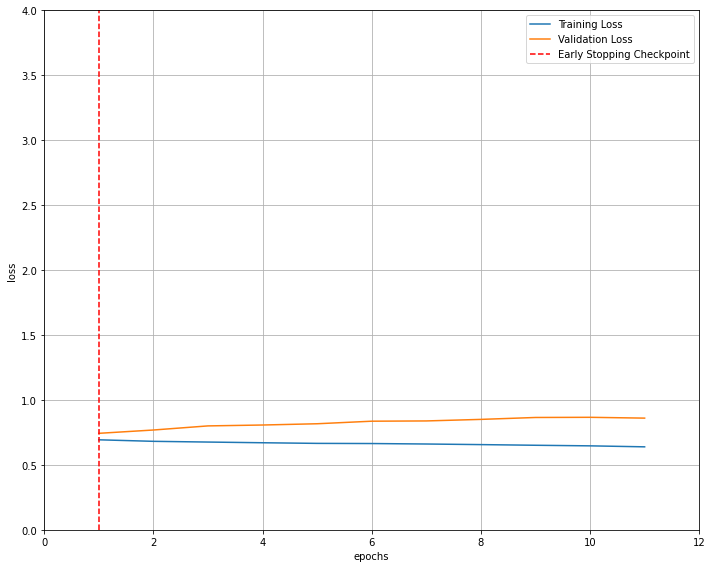

Finished analysis on User 23_effort
Finished analysis on User 23
Working on user 24
Early stopping
Fold  1! Time elapsed: 17.707149505615234 seconds
Early stopping
Fold  2! Time elapsed: 10.776426315307617 seconds
Early stopping
Fold  3! Time elapsed: 9.029351234436035 seconds
Early stopping
Fold  4! Time elapsed: 16.743866443634033 seconds
Normalized confusion matrix


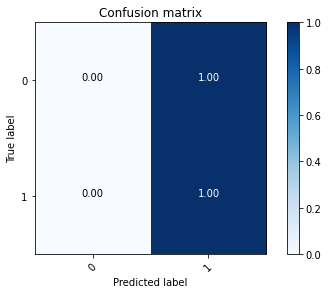

<Figure size 432x288 with 0 Axes>

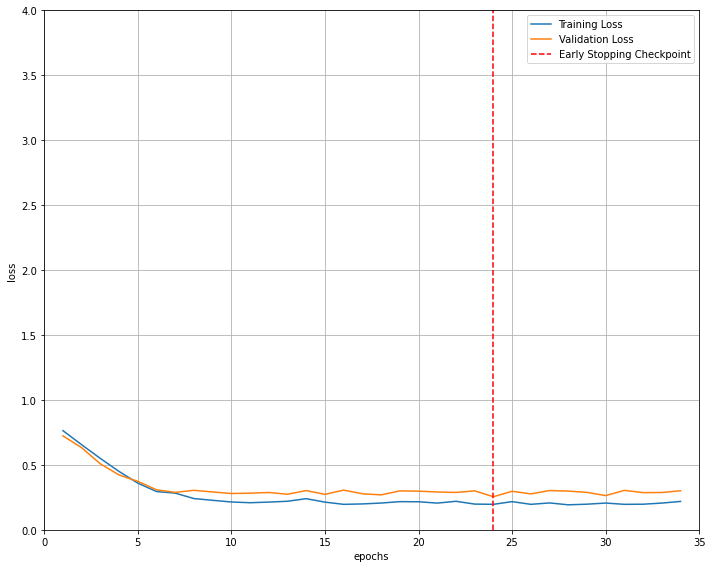

Finished analysis on User 24_attention
Early stopping
Fold  1! Time elapsed: 16.039891242980957 seconds
Early stopping
Fold  2! Time elapsed: 8.191228151321411 seconds
Early stopping
Fold  3! Time elapsed: 9.224308729171753 seconds
Early stopping
Fold  4! Time elapsed: 11.538866519927979 seconds
Normalized confusion matrix


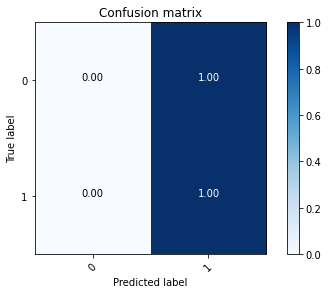

<Figure size 432x288 with 0 Axes>

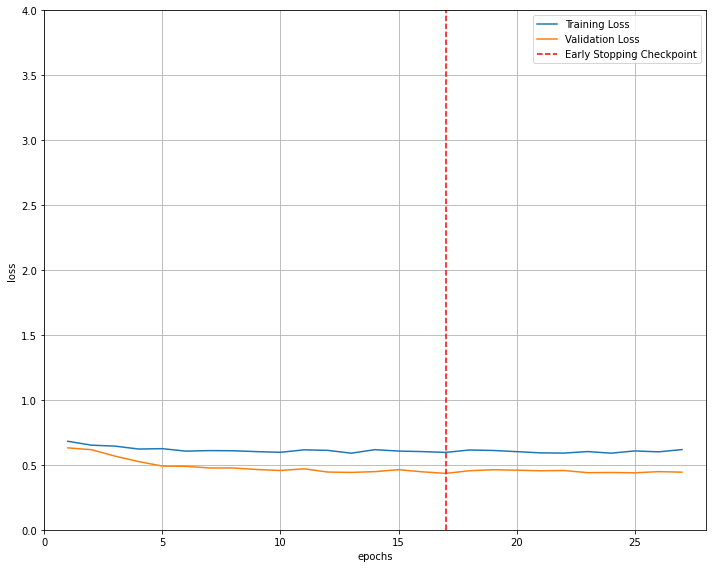

Finished analysis on User 24_interest
Early stopping
Fold  1! Time elapsed: 8.458592891693115 seconds
Early stopping
Fold  2! Time elapsed: 4.738184452056885 seconds
Early stopping
Fold  3! Time elapsed: 4.946195125579834 seconds
Early stopping
Fold  4! Time elapsed: 6.036612033843994 seconds
Normalized confusion matrix


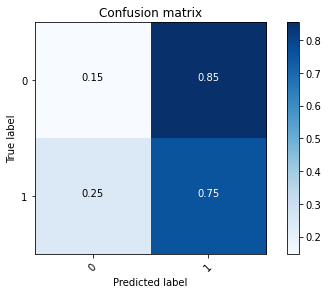

<Figure size 432x288 with 0 Axes>

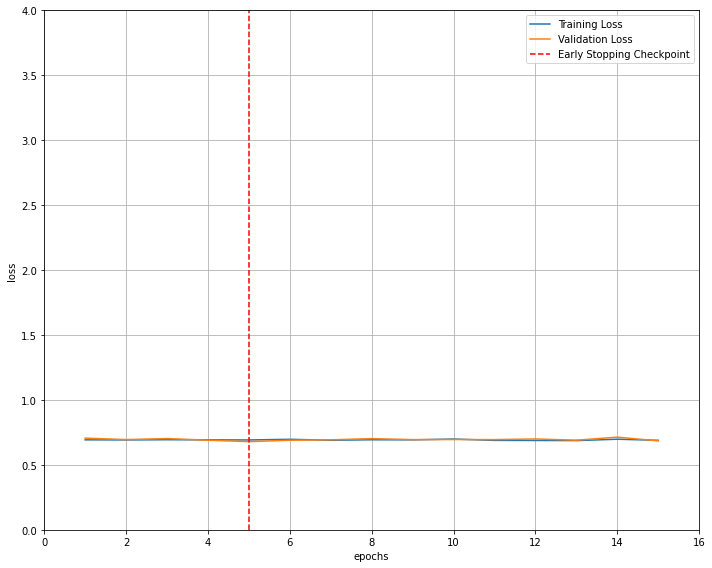

Finished analysis on User 24_effort
Finished analysis on User 24
Working on user 25
Early stopping
Fold  1! Time elapsed: 9.651128768920898 seconds
Early stopping
Fold  2! Time elapsed: 13.794523239135742 seconds
Early stopping
Fold  3! Time elapsed: 36.43515968322754 seconds
Early stopping
Fold  4! Time elapsed: 11.144707918167114 seconds
Early stopping
Fold  5! Time elapsed: 36.517921447753906 seconds
Normalized confusion matrix


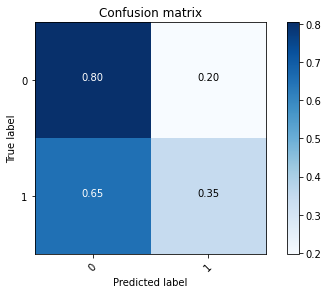

<Figure size 432x288 with 0 Axes>

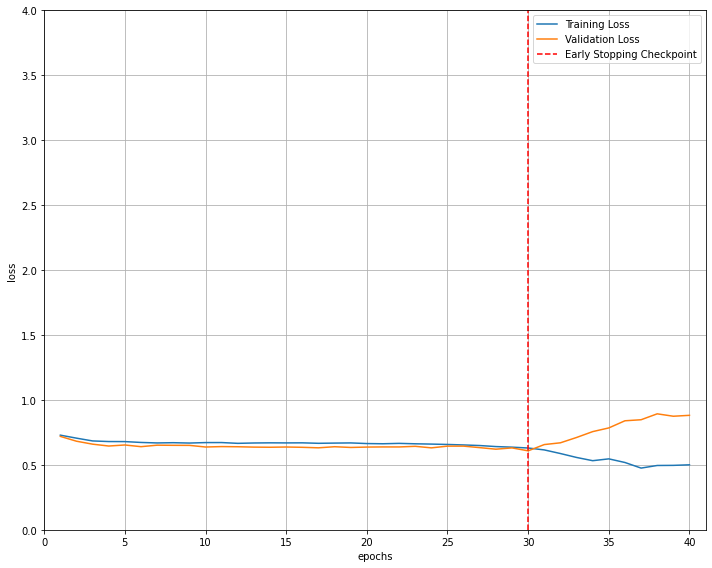

Finished analysis on User 25_attention
Early stopping
Fold  1! Time elapsed: 10.332539081573486 seconds
Early stopping
Fold  2! Time elapsed: 9.908467292785645 seconds
Early stopping
Fold  3! Time elapsed: 10.799342155456543 seconds
Early stopping
Fold  4! Time elapsed: 11.053525924682617 seconds
Early stopping
Fold  5! Time elapsed: 42.29034686088562 seconds
Normalized confusion matrix


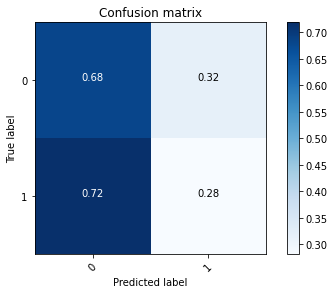

<Figure size 432x288 with 0 Axes>

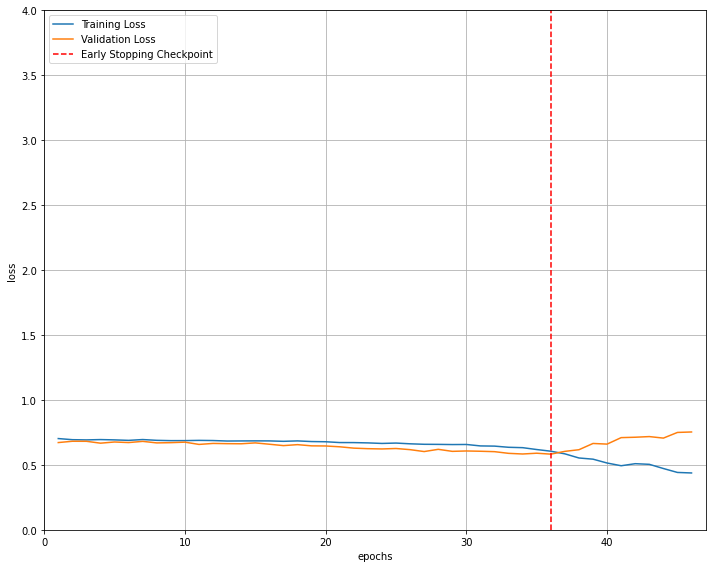

Finished analysis on User 25_interest
Early stopping
Fold  1! Time elapsed: 51.29334282875061 seconds
Early stopping
Fold  2! Time elapsed: 10.554591655731201 seconds
Early stopping
Fold  3! Time elapsed: 18.87627649307251 seconds
Early stopping
Fold  4! Time elapsed: 12.760251522064209 seconds
Early stopping
Fold  5! Time elapsed: 11.54625940322876 seconds
Normalized confusion matrix


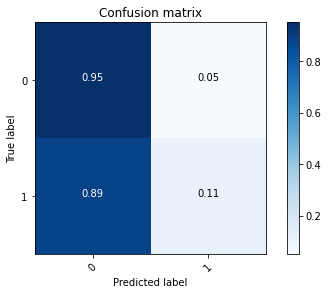

<Figure size 432x288 with 0 Axes>

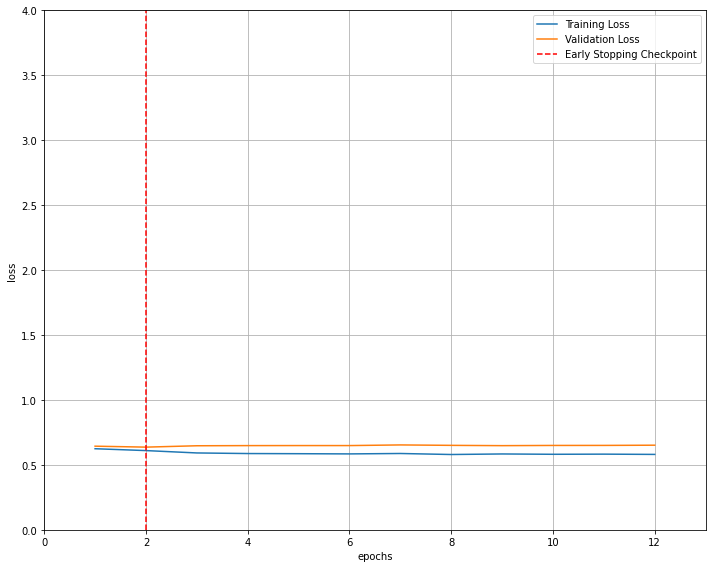

Finished analysis on User 25_effort
Finished analysis on User 25
All analyses are complete! Time elapsed: 3045.3721442222595
Working on label attention
Early stopping
Fold  1! Time elapsed: 98.30611300468445 seconds
Early stopping
Fold  2! Time elapsed: 79.87509059906006 seconds
Early stopping
Fold  3! Time elapsed: 69.81988501548767 seconds
Early stopping
Fold  4! Time elapsed: 83.56017351150513 seconds
Early stopping
Fold  5! Time elapsed: 87.95741391181946 seconds
Normalized confusion matrix


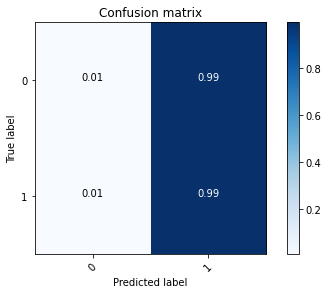

<Figure size 432x288 with 0 Axes>

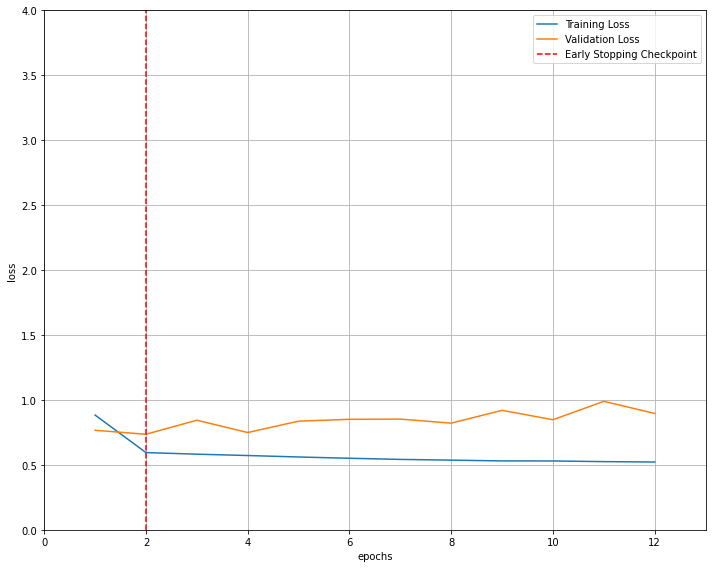

Finished analysis on label attention. Time elapsed 425.4935872554779
Working on label interest
Early stopping
Fold  1! Time elapsed: 69.35243105888367 seconds
Early stopping
Fold  2! Time elapsed: 85.01021552085876 seconds
Early stopping
Fold  3! Time elapsed: 73.81401085853577 seconds
Early stopping
Fold  4! Time elapsed: 124.21384787559509 seconds
Early stopping
Fold  5! Time elapsed: 100.92447853088379 seconds
Normalized confusion matrix


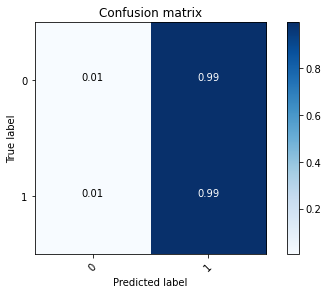

<Figure size 432x288 with 0 Axes>

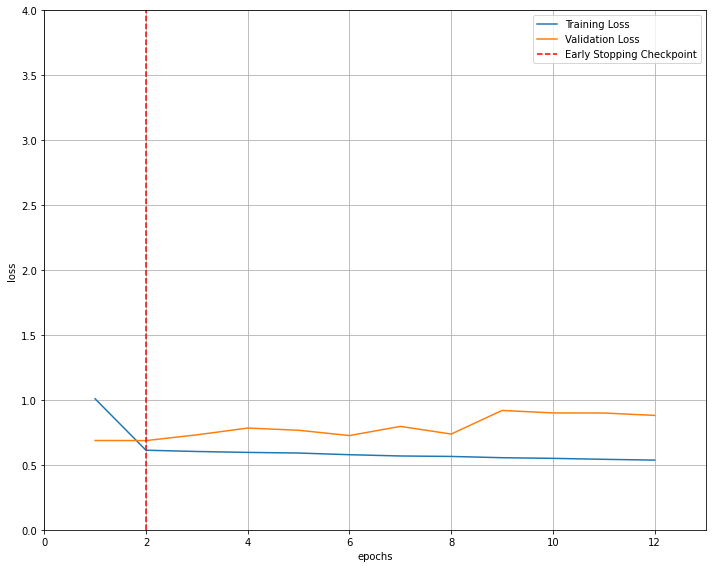

Finished analysis on label interest. Time elapsed 459.9355585575104
Working on label effort
Early stopping
Fold  1! Time elapsed: 77.98467946052551 seconds
Early stopping
Fold  2! Time elapsed: 79.27526783943176 seconds
Early stopping
Fold  3! Time elapsed: 137.0081226825714 seconds
Early stopping
Fold  4! Time elapsed: 91.37598276138306 seconds
Early stopping
Fold  5! Time elapsed: 84.68884921073914 seconds
Normalized confusion matrix


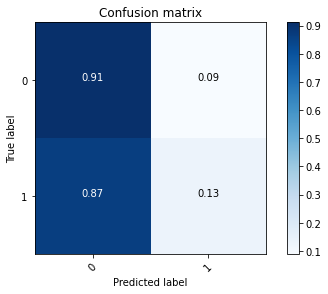

<Figure size 432x288 with 0 Axes>

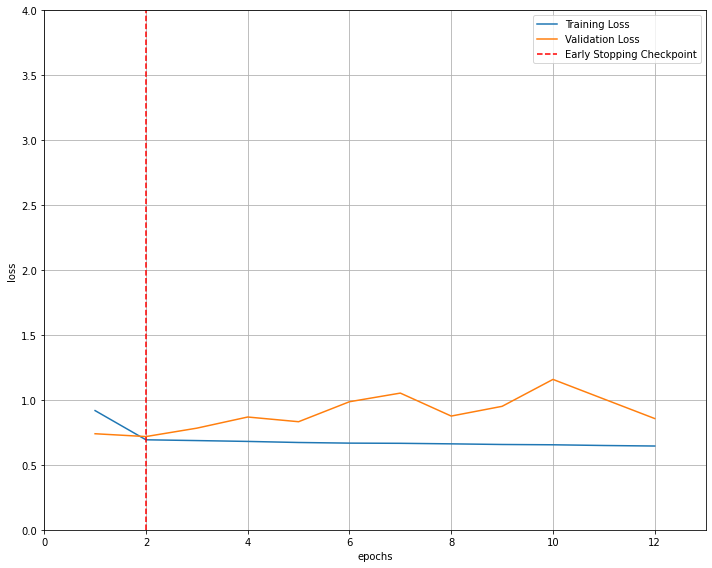

Finished analysis on label effort. Time elapsed 477.98036193847656
Finished analysis on User all
All analyses are complete! Time elapsed: 1364.8454322814941
Working on user 1
Early stopping
Fold  1! Time elapsed: 4.266347169876099 seconds
Early stopping
Fold  2! Time elapsed: 18.95982313156128 seconds
Early stopping
Fold  3! Time elapsed: 17.821523666381836 seconds
Early stopping
Fold  4! Time elapsed: 5.173388481140137 seconds
Normalized confusion matrix


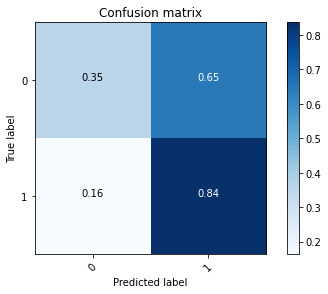

<Figure size 432x288 with 0 Axes>

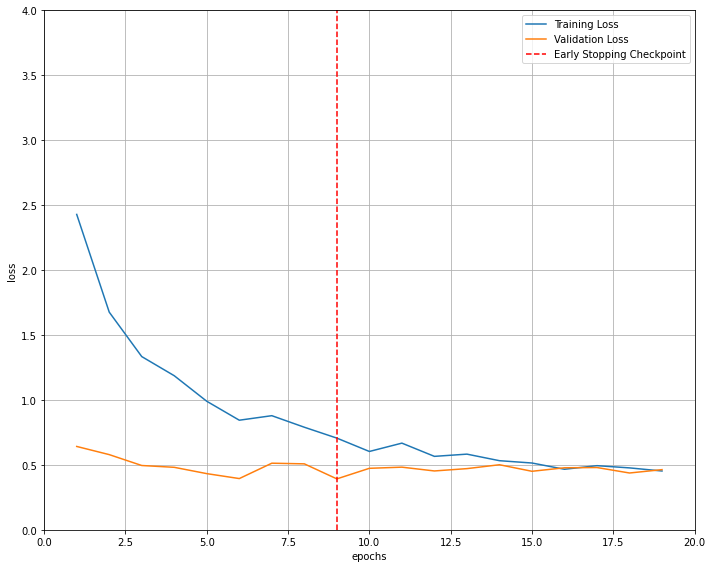

Finished analysis on User 1_attention
Early stopping
Fold  1! Time elapsed: 4.506202697753906 seconds
Early stopping
Fold  2! Time elapsed: 16.99922800064087 seconds
Early stopping
Fold  3! Time elapsed: 11.590437889099121 seconds
Early stopping
Fold  4! Time elapsed: 4.93548583984375 seconds
Normalized confusion matrix


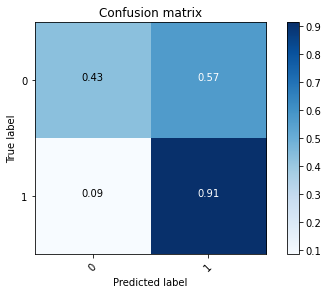

<Figure size 432x288 with 0 Axes>

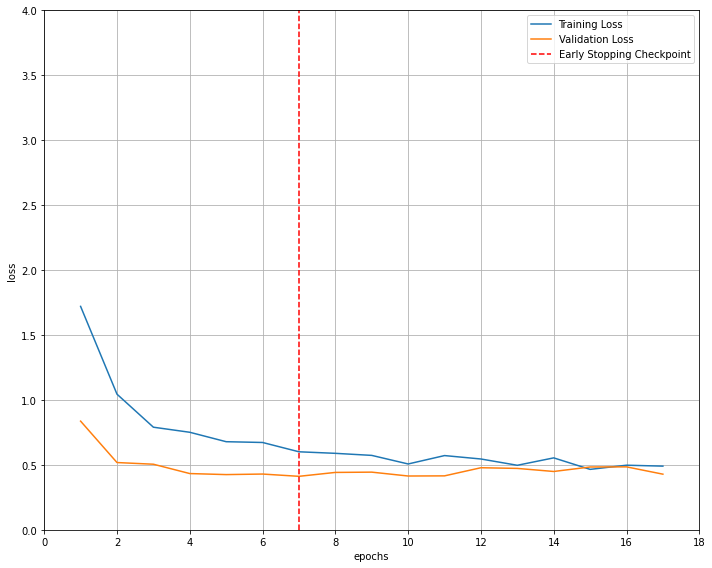

Finished analysis on User 1_interest
Early stopping
Fold  1! Time elapsed: 3.1074628829956055 seconds
Early stopping
Fold  2! Time elapsed: 7.109057188034058 seconds
Early stopping
Fold  3! Time elapsed: 13.964017391204834 seconds
Early stopping
Fold  4! Time elapsed: 6.093214273452759 seconds
Early stopping
Fold  5! Time elapsed: 10.94241189956665 seconds
Normalized confusion matrix


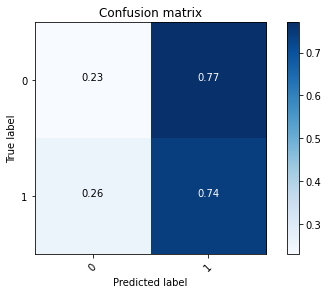

<Figure size 432x288 with 0 Axes>

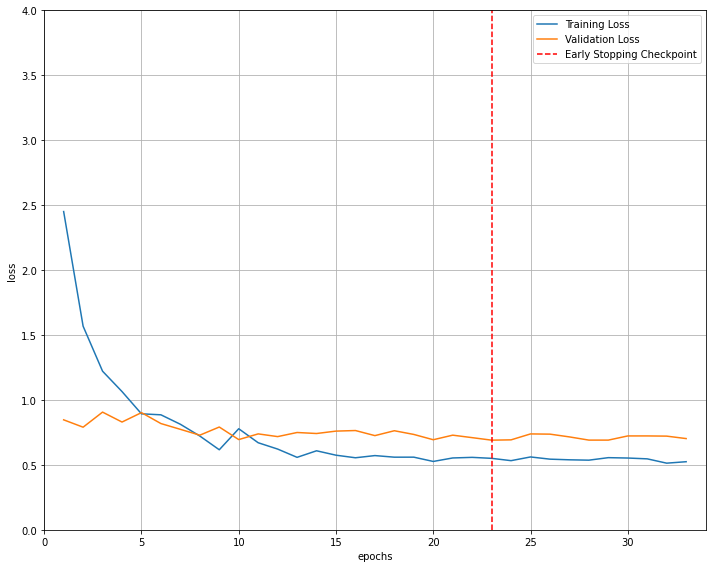

Finished analysis on User 1_effort
Finished analysis on User 1
Working on user 2
Early stopping
Fold  1! Time elapsed: 22.562217950820923 seconds
Early stopping
Fold  2! Time elapsed: 10.091737985610962 seconds
Early stopping
Fold  3! Time elapsed: 9.92569088935852 seconds
Early stopping
Fold  4! Time elapsed: 17.239591360092163 seconds
Normalized confusion matrix


ipynb.fs.full.evaluation:69: RuntimeWarning: invalid value encountered in true_divide


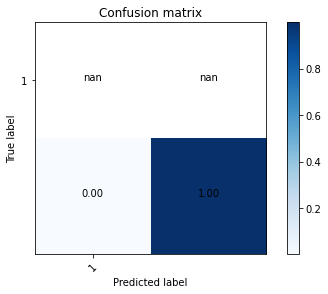

<Figure size 432x288 with 0 Axes>

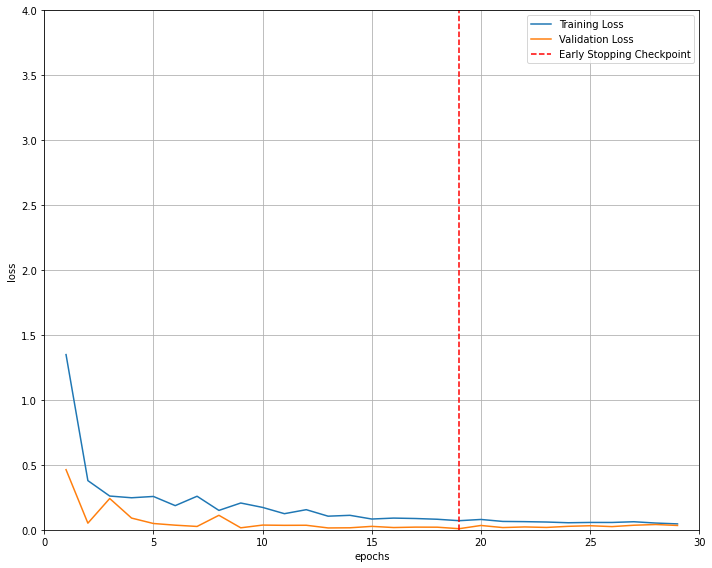

Finished analysis on User 2_attention
Early stopping
Fold  1! Time elapsed: 38.219096422195435 seconds
Early stopping
Fold  2! Time elapsed: 7.001296520233154 seconds
Early stopping
Fold  3! Time elapsed: 8.341914892196655 seconds
Early stopping
Fold  4! Time elapsed: 37.824169874191284 seconds
Normalized confusion matrix


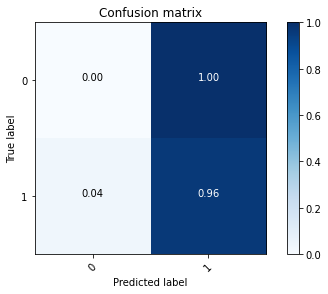

<Figure size 432x288 with 0 Axes>

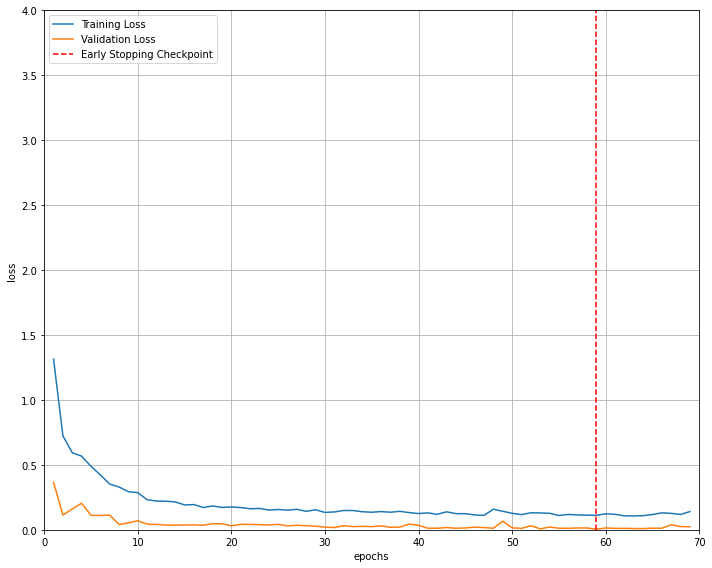

Finished analysis on User 2_interest
Early stopping
Fold  1! Time elapsed: 11.704464673995972 seconds
Early stopping
Fold  2! Time elapsed: 10.819180011749268 seconds
Early stopping
Fold  3! Time elapsed: 14.21103811264038 seconds
Early stopping
Fold  4! Time elapsed: 14.81342363357544 seconds
Early stopping
Fold  5! Time elapsed: 25.224773168563843 seconds
Normalized confusion matrix


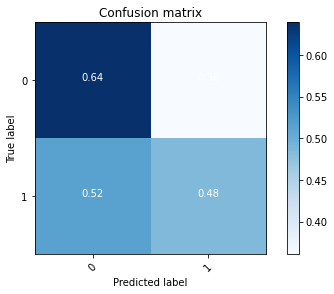

<Figure size 432x288 with 0 Axes>

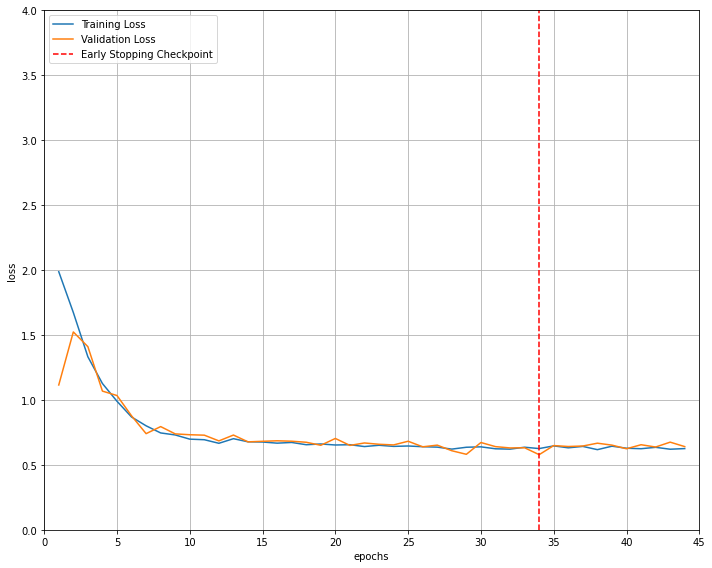

Finished analysis on User 2_effort
Finished analysis on User 2
Working on user 3
Early stopping
Fold  1! Time elapsed: 18.42949676513672 seconds
Early stopping
Fold  2! Time elapsed: 21.730196714401245 seconds
Early stopping
Fold  3! Time elapsed: 17.99853515625 seconds
Early stopping
Fold  4! Time elapsed: 28.319132566452026 seconds
Early stopping
Fold  5! Time elapsed: 12.837313652038574 seconds
Normalized confusion matrix


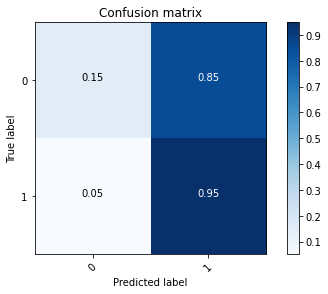

<Figure size 432x288 with 0 Axes>

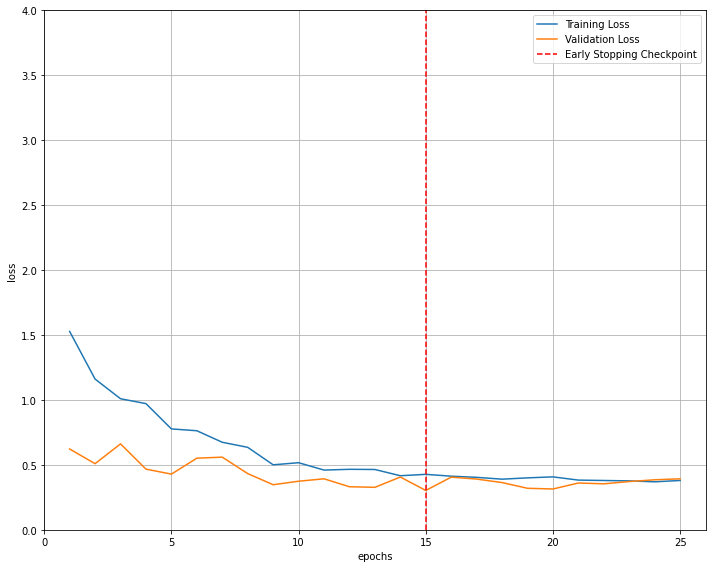

Finished analysis on User 3_attention
Early stopping
Fold  1! Time elapsed: 17.661667346954346 seconds
Early stopping
Fold  2! Time elapsed: 15.917900085449219 seconds
Early stopping
Fold  3! Time elapsed: 6.943897247314453 seconds
Early stopping
Fold  4! Time elapsed: 13.265356063842773 seconds
Early stopping
Fold  5! Time elapsed: 14.36296010017395 seconds
Normalized confusion matrix


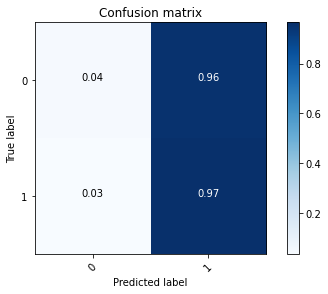

<Figure size 432x288 with 0 Axes>

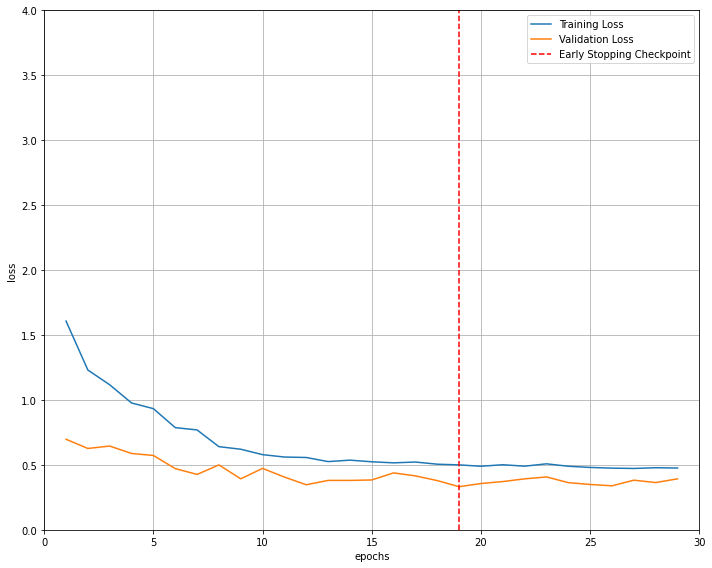

Finished analysis on User 3_interest
Early stopping
Fold  1! Time elapsed: 22.49807643890381 seconds
Early stopping
Fold  2! Time elapsed: 24.38443660736084 seconds
Early stopping
Fold  3! Time elapsed: 10.833221197128296 seconds
Early stopping
Fold  4! Time elapsed: 8.765875101089478 seconds
Early stopping
Fold  5! Time elapsed: 32.26619863510132 seconds
Normalized confusion matrix


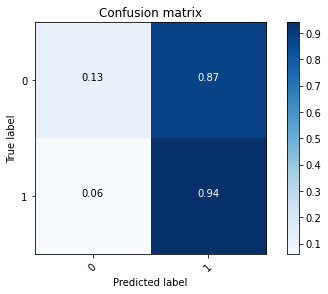

<Figure size 432x288 with 0 Axes>

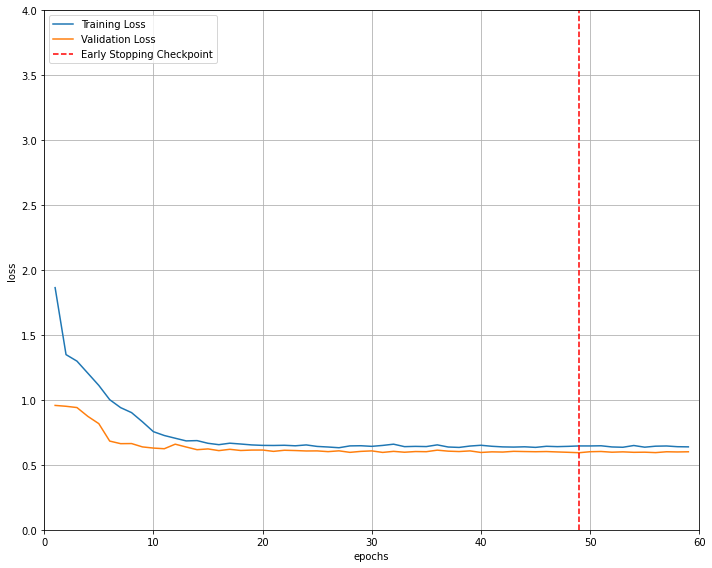

Finished analysis on User 3_effort
Finished analysis on User 3
Working on user 6
Early stopping
Fold  1! Time elapsed: 6.0603697299957275 seconds
Early stopping
Fold  2! Time elapsed: 6.462001323699951 seconds
Early stopping
Fold  3! Time elapsed: 8.865657329559326 seconds
Early stopping
Fold  4! Time elapsed: 17.68300175666809 seconds
Early stopping
Fold  5! Time elapsed: 21.79280185699463 seconds
Normalized confusion matrix


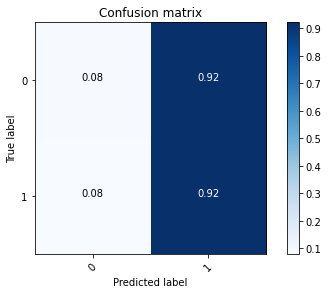

<Figure size 432x288 with 0 Axes>

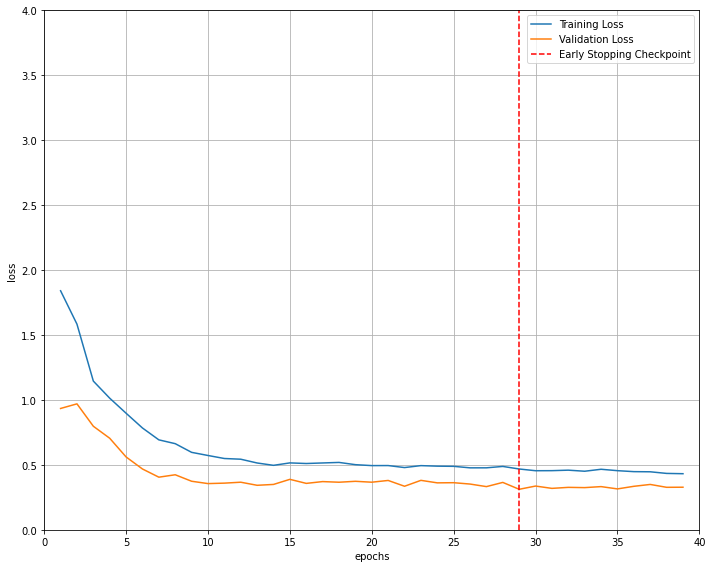

Finished analysis on User 6_attention
Early stopping
Fold  1! Time elapsed: 17.934181451797485 seconds
Early stopping
Fold  2! Time elapsed: 12.259658336639404 seconds
Early stopping
Fold  3! Time elapsed: 16.025730848312378 seconds
Early stopping
Fold  4! Time elapsed: 16.244599103927612 seconds
Early stopping
Fold  5! Time elapsed: 16.13678789138794 seconds
Normalized confusion matrix


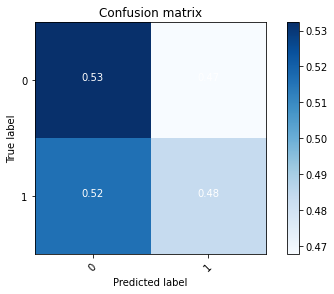

<Figure size 432x288 with 0 Axes>

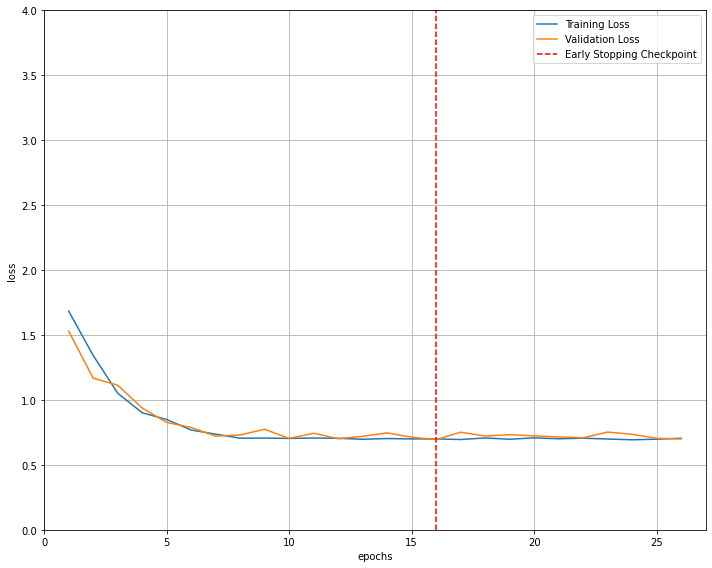

Finished analysis on User 6_interest
Early stopping
Fold  1! Time elapsed: 12.085043907165527 seconds
Early stopping
Fold  2! Time elapsed: 15.649705171585083 seconds
Early stopping
Fold  3! Time elapsed: 13.539452075958252 seconds
Early stopping
Fold  4! Time elapsed: 15.268619298934937 seconds
Early stopping
Fold  5! Time elapsed: 17.43686819076538 seconds
Normalized confusion matrix


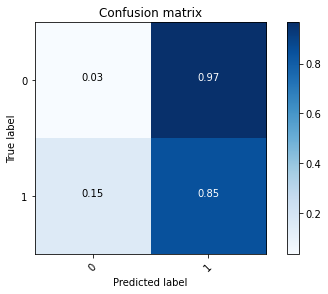

<Figure size 432x288 with 0 Axes>

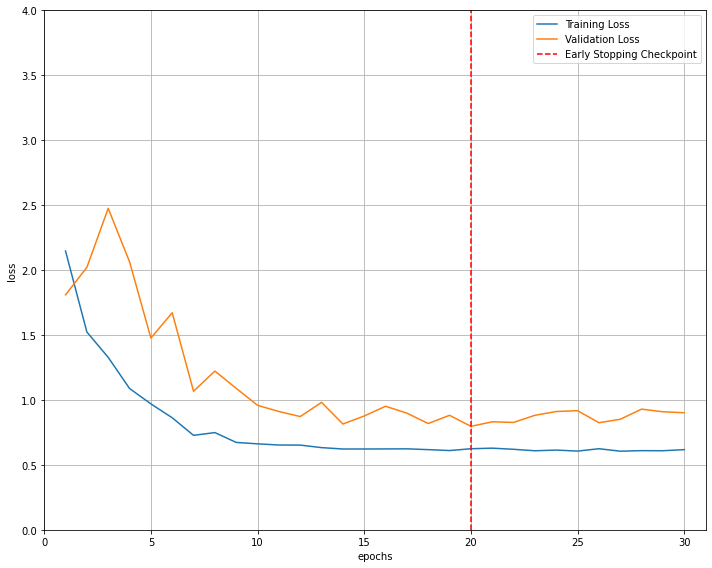

Finished analysis on User 6_effort
Finished analysis on User 6
Working on user 7
Early stopping
Fold  1! Time elapsed: 14.368576526641846 seconds
Early stopping
Fold  2! Time elapsed: 15.573090314865112 seconds
Early stopping
Fold  3! Time elapsed: 10.608811140060425 seconds
Early stopping
Fold  4! Time elapsed: 16.063313961029053 seconds
Normalized confusion matrix


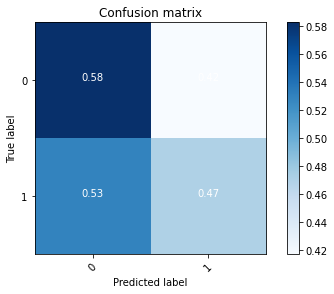

<Figure size 432x288 with 0 Axes>

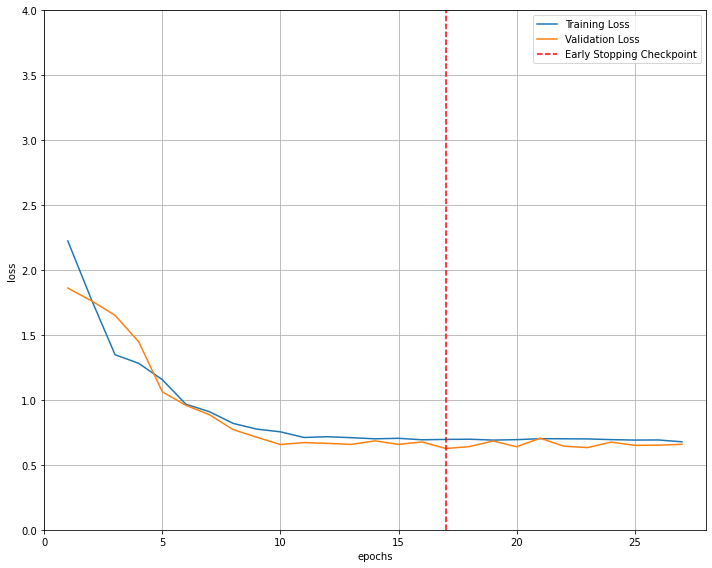

Finished analysis on User 7_attention
Early stopping
Fold  1! Time elapsed: 34.64612293243408 seconds
Early stopping
Fold  2! Time elapsed: 27.03840470314026 seconds
Early stopping
Fold  3! Time elapsed: 8.532265424728394 seconds
Early stopping
Fold  4! Time elapsed: 7.072476863861084 seconds
Normalized confusion matrix


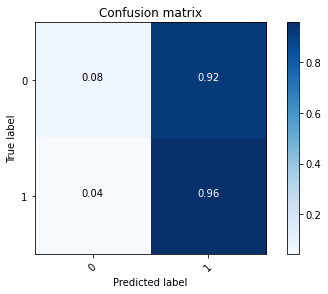

<Figure size 432x288 with 0 Axes>

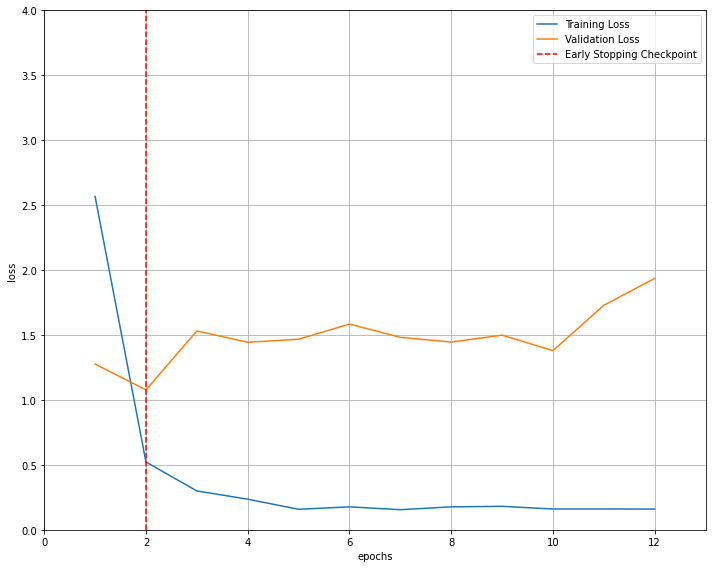

Finished analysis on User 7_interest
Early stopping
Fold  1! Time elapsed: 12.54742693901062 seconds
Early stopping
Fold  2! Time elapsed: 21.977292776107788 seconds
Early stopping
Fold  3! Time elapsed: 17.32494854927063 seconds
Early stopping
Fold  4! Time elapsed: 17.562113046646118 seconds
Early stopping
Fold  5! Time elapsed: 19.381628274917603 seconds
Normalized confusion matrix


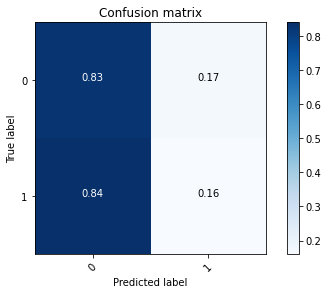

<Figure size 432x288 with 0 Axes>

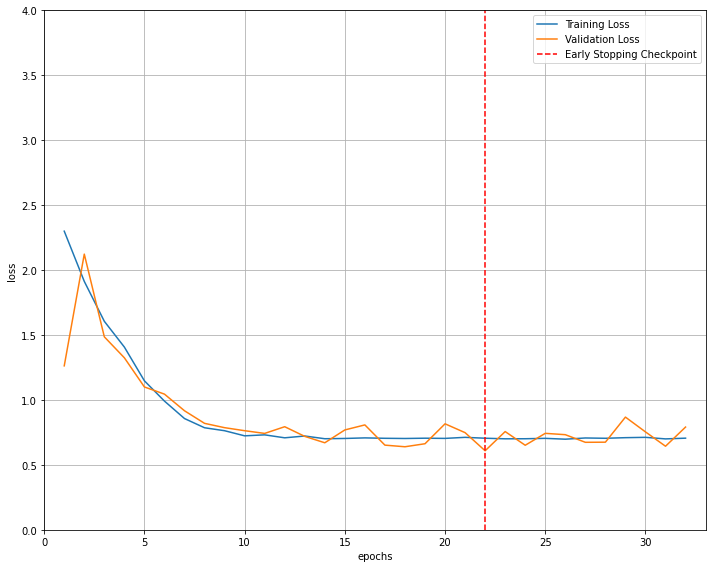

Finished analysis on User 7_effort
Finished analysis on User 7
Working on user 8
Early stopping
Fold  1! Time elapsed: 15.81679630279541 seconds
Early stopping
Fold  2! Time elapsed: 22.378082513809204 seconds
Early stopping
Fold  3! Time elapsed: 34.816147565841675 seconds
Early stopping
Fold  4! Time elapsed: 17.25948166847229 seconds
Early stopping
Fold  5! Time elapsed: 6.761067628860474 seconds
Normalized confusion matrix


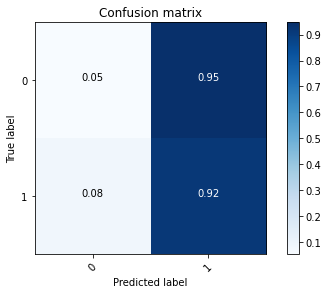

<Figure size 432x288 with 0 Axes>

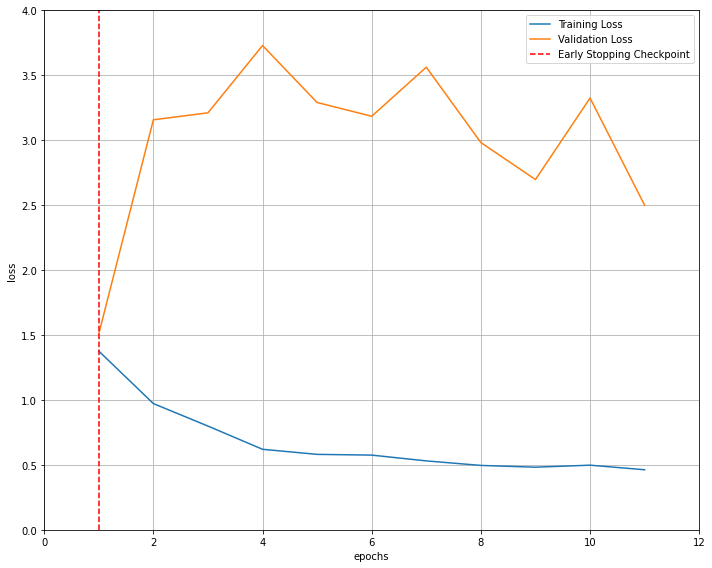

Finished analysis on User 8_attention
Early stopping
Fold  1! Time elapsed: 14.234987020492554 seconds
Early stopping
Fold  2! Time elapsed: 10.429249048233032 seconds
Early stopping
Fold  3! Time elapsed: 25.208879232406616 seconds
Early stopping
Fold  4! Time elapsed: 16.38026785850525 seconds
Early stopping
Fold  5! Time elapsed: 17.498682975769043 seconds
Normalized confusion matrix


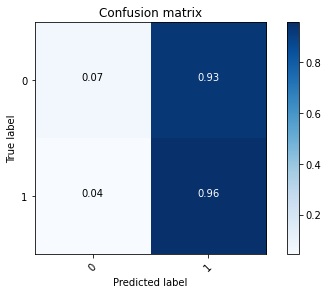

<Figure size 432x288 with 0 Axes>

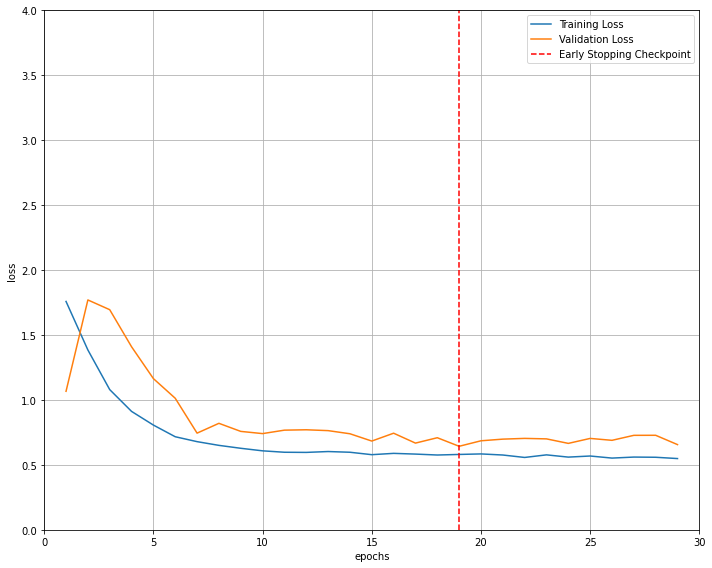

Finished analysis on User 8_interest
Early stopping
Fold  1! Time elapsed: 12.319180250167847 seconds
Early stopping
Fold  2! Time elapsed: 21.359790563583374 seconds
Early stopping
Fold  3! Time elapsed: 10.822410583496094 seconds
Early stopping
Fold  4! Time elapsed: 15.43545126914978 seconds
Early stopping
Fold  5! Time elapsed: 14.658126831054688 seconds
Normalized confusion matrix


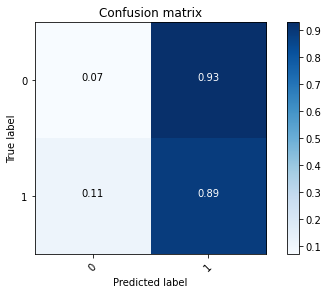

<Figure size 432x288 with 0 Axes>

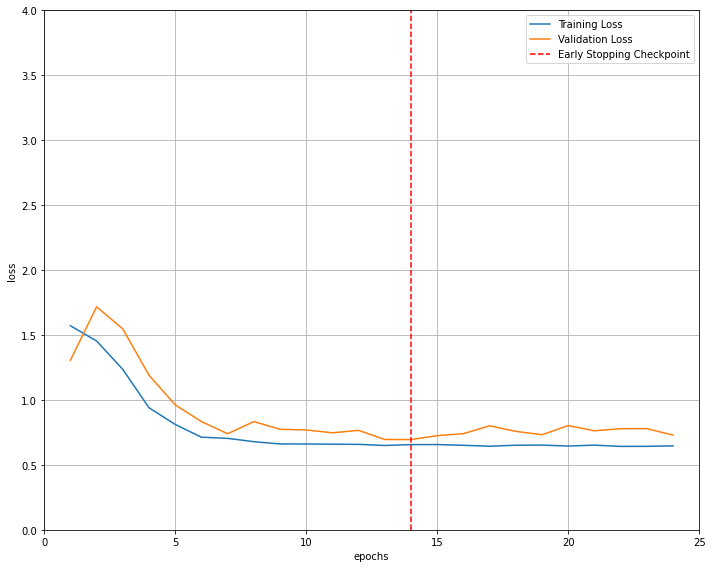

Finished analysis on User 8_effort
Finished analysis on User 8
Working on user 9
Early stopping
Fold  1! Time elapsed: 50.92068433761597 seconds
Early stopping
Fold  2! Time elapsed: 16.331719636917114 seconds
Early stopping
Fold  3! Time elapsed: 24.289276599884033 seconds
Early stopping
Fold  4! Time elapsed: 13.679523229598999 seconds
Early stopping
Fold  5! Time elapsed: 28.18002152442932 seconds
Normalized confusion matrix


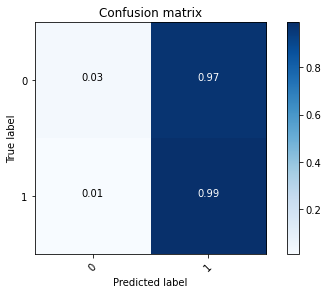

<Figure size 432x288 with 0 Axes>

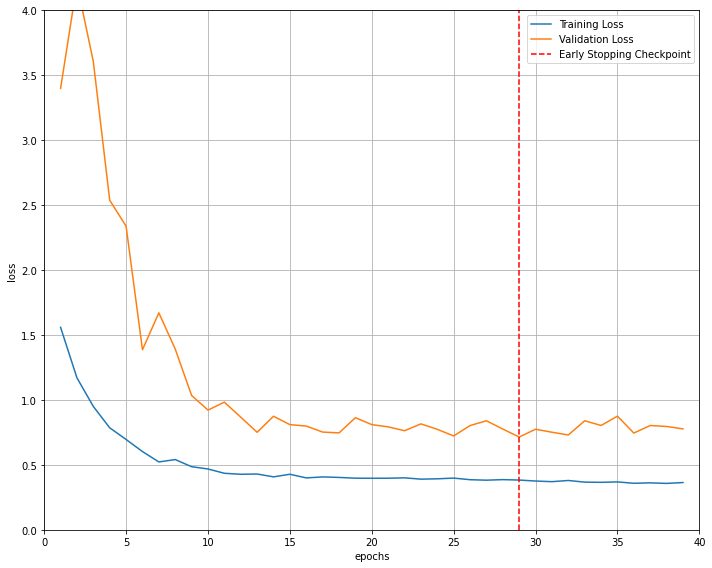

Finished analysis on User 9_attention
Early stopping
Fold  1! Time elapsed: 14.53819489479065 seconds
Early stopping
Fold  2! Time elapsed: 18.93644952774048 seconds
Early stopping
Fold  3! Time elapsed: 14.625375509262085 seconds
Early stopping
Fold  4! Time elapsed: 13.91608715057373 seconds
Early stopping
Fold  5! Time elapsed: 56.90599036216736 seconds
Normalized confusion matrix


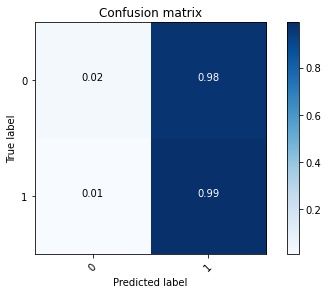

<Figure size 432x288 with 0 Axes>

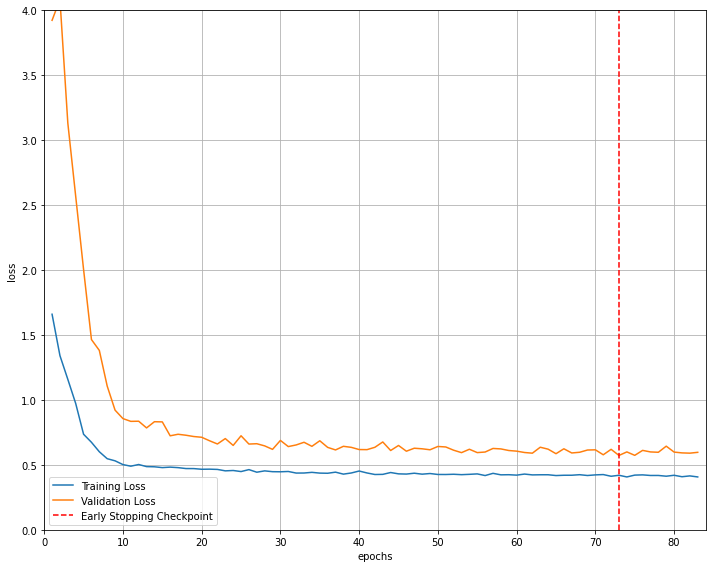

Finished analysis on User 9_interest
Early stopping
Fold  1! Time elapsed: 30.52080202102661 seconds
Early stopping
Fold  2! Time elapsed: 10.482789516448975 seconds
Early stopping
Fold  3! Time elapsed: 15.140934467315674 seconds
Early stopping
Fold  4! Time elapsed: 7.034462213516235 seconds
Early stopping
Fold  5! Time elapsed: 12.734710454940796 seconds
Normalized confusion matrix


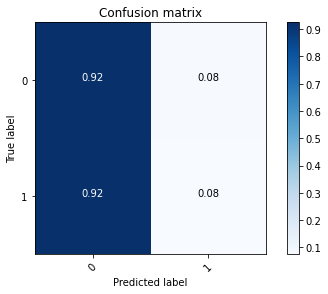

<Figure size 432x288 with 0 Axes>

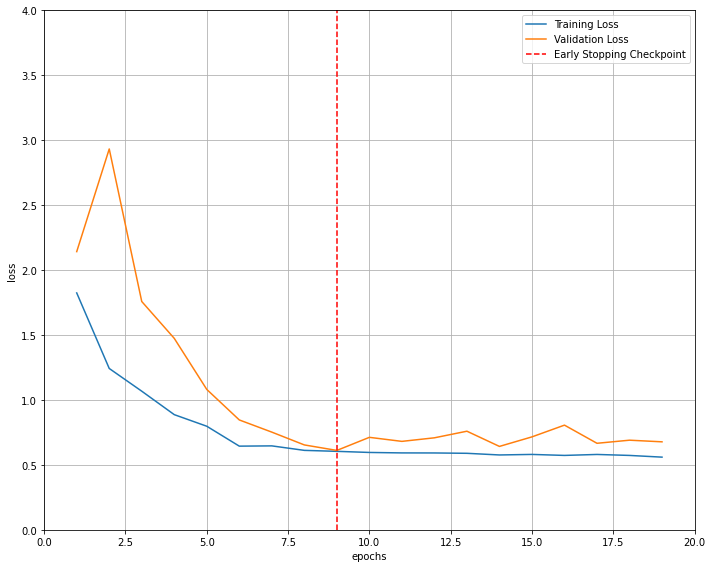

Finished analysis on User 9_effort
Finished analysis on User 9
Working on user 10
Early stopping
Fold  1! Time elapsed: 1.1247057914733887 seconds
Early stopping
Fold  2! Time elapsed: 1.0660209655761719 seconds
Early stopping
Fold  3! Time elapsed: 1.35044264793396 seconds
Early stopping
Fold  4! Time elapsed: 1.355642318725586 seconds
Early stopping
Fold  5! Time elapsed: 1.132427453994751 seconds
Normalized confusion matrix


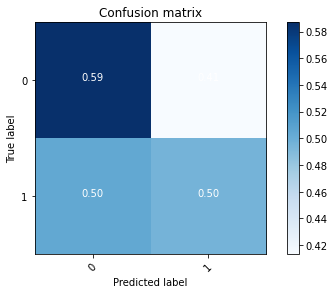

<Figure size 432x288 with 0 Axes>

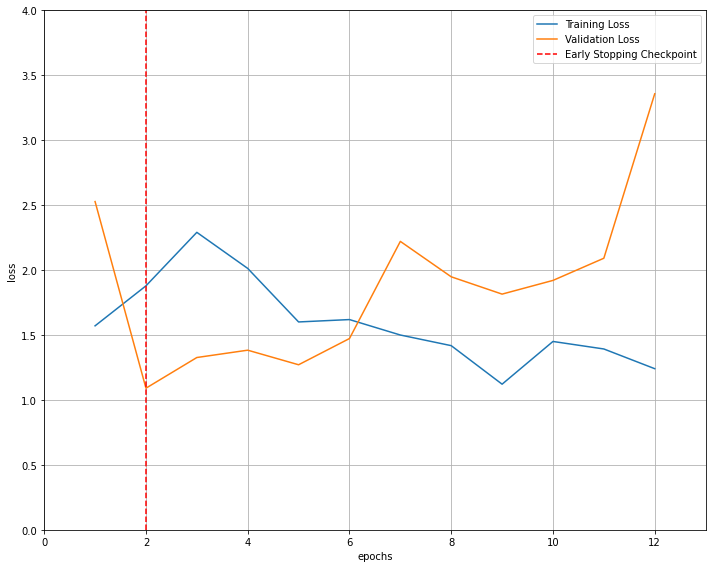

Finished analysis on User 10_attention
Early stopping
Fold  1! Time elapsed: 1.223179817199707 seconds
Early stopping
Fold  2! Time elapsed: 1.534724473953247 seconds
Early stopping
Fold  3! Time elapsed: 1.250880241394043 seconds
Early stopping
Fold  4! Time elapsed: 1.2287602424621582 seconds
Early stopping
Fold  5! Time elapsed: 1.0407166481018066 seconds
Normalized confusion matrix


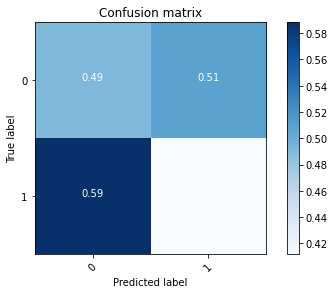

<Figure size 432x288 with 0 Axes>

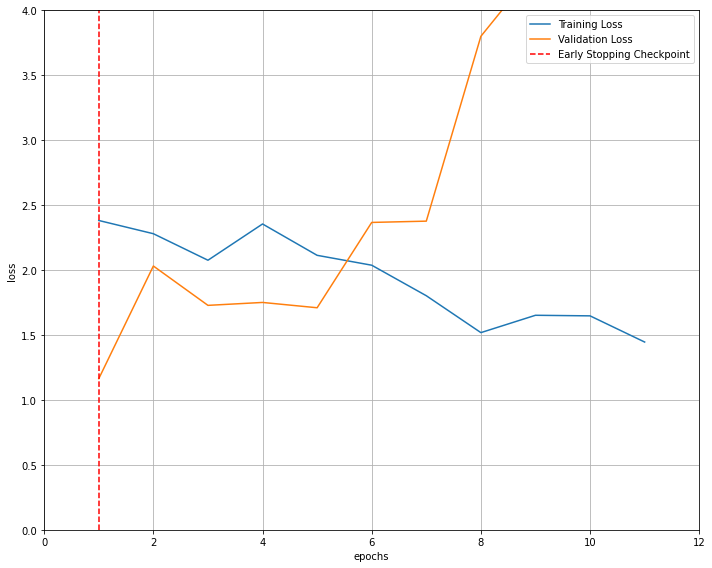

Finished analysis on User 10_interest
Early stopping
Fold  1! Time elapsed: 1.4158456325531006 seconds
Early stopping
Fold  2! Time elapsed: 1.3378965854644775 seconds
Early stopping
Fold  3! Time elapsed: 1.2396080493927002 seconds
Early stopping
Fold  4! Time elapsed: 1.323540449142456 seconds
Early stopping
Fold  5! Time elapsed: 1.3577532768249512 seconds
Normalized confusion matrix


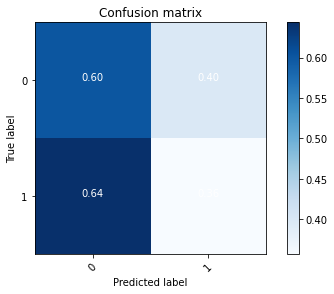

<Figure size 432x288 with 0 Axes>

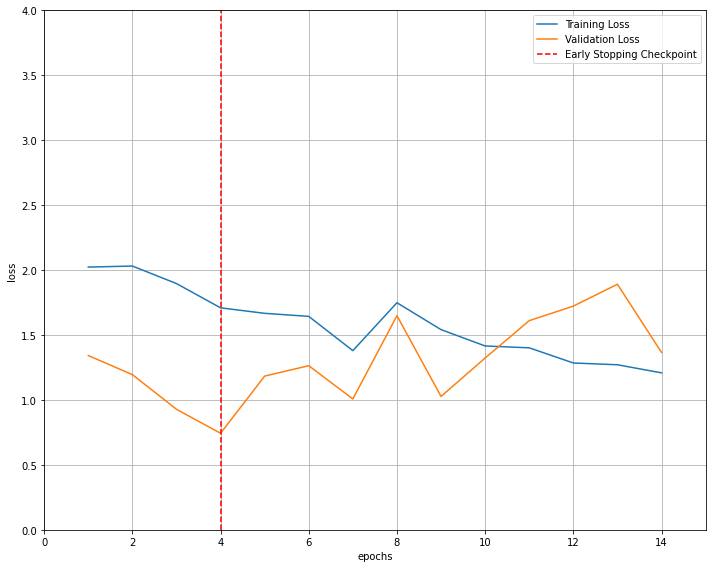

Finished analysis on User 10_effort
Finished analysis on User 10
Working on user 11
Early stopping
Fold  1! Time elapsed: 6.620895862579346 seconds
Early stopping
Fold  2! Time elapsed: 5.4267494678497314 seconds
Early stopping
Fold  3! Time elapsed: 7.676331043243408 seconds
Early stopping
Fold  4! Time elapsed: 3.0736007690429688 seconds
Early stopping
Fold  5! Time elapsed: 2.3023738861083984 seconds
Normalized confusion matrix


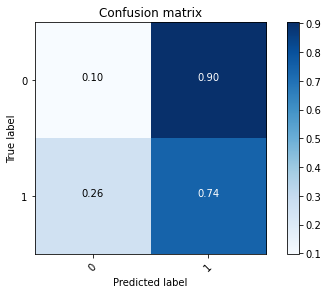

<Figure size 432x288 with 0 Axes>

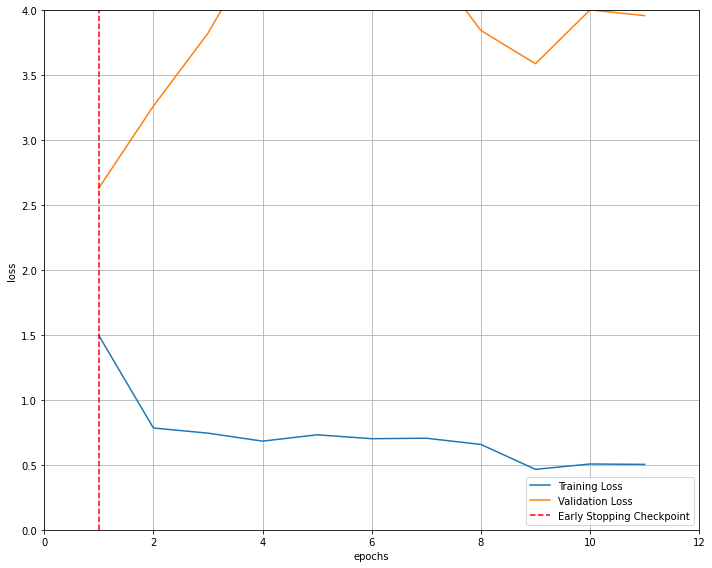

Finished analysis on User 11_attention
Early stopping
Fold  1! Time elapsed: 6.530117750167847 seconds
Early stopping
Fold  2! Time elapsed: 2.5349276065826416 seconds
Early stopping
Fold  3! Time elapsed: 4.281222105026245 seconds
Early stopping
Fold  4! Time elapsed: 4.380449295043945 seconds
Early stopping
Fold  5! Time elapsed: 2.3469502925872803 seconds
Normalized confusion matrix


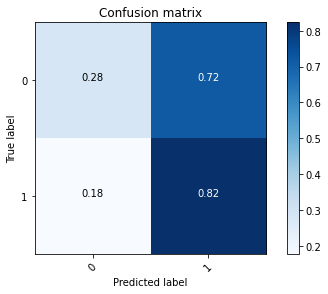

<Figure size 432x288 with 0 Axes>

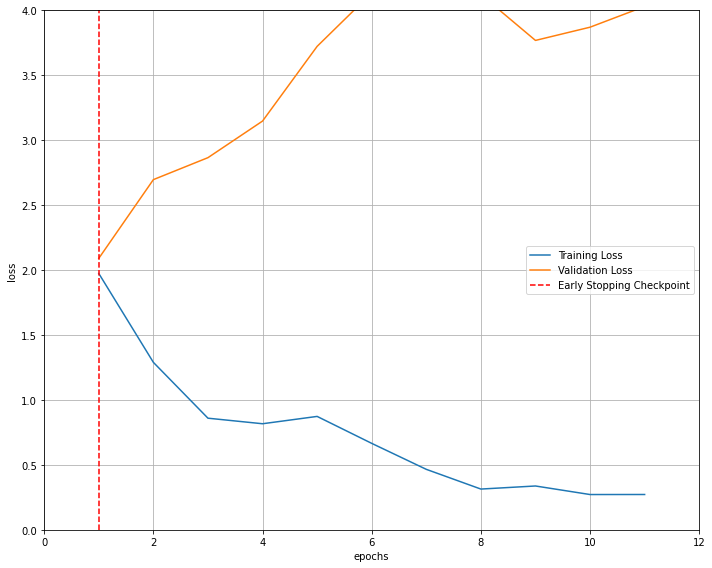

Finished analysis on User 11_interest
Early stopping
Fold  1! Time elapsed: 6.763828992843628 seconds
Early stopping
Fold  2! Time elapsed: 5.523235082626343 seconds
Early stopping
Fold  3! Time elapsed: 6.475438833236694 seconds
Early stopping
Fold  4! Time elapsed: 8.130556344985962 seconds
Early stopping
Fold  5! Time elapsed: 8.914626121520996 seconds
Normalized confusion matrix


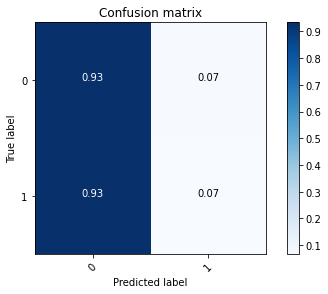

<Figure size 432x288 with 0 Axes>

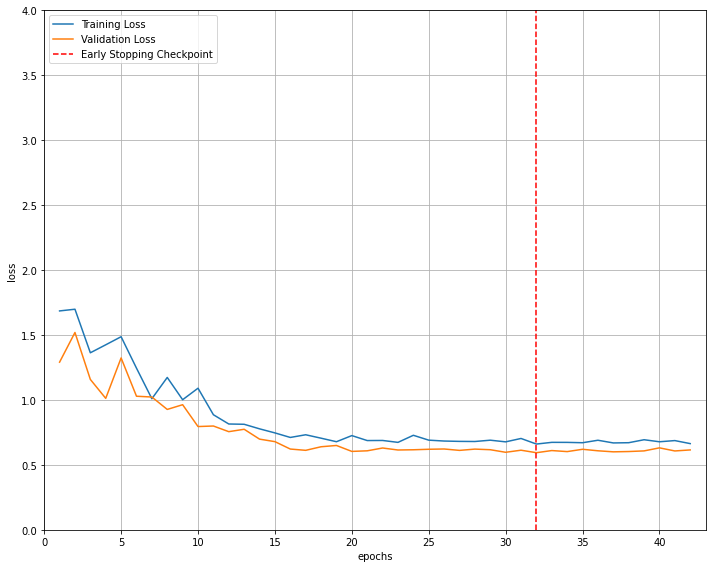

Finished analysis on User 11_effort
Finished analysis on User 11
Working on user 12
Early stopping
Fold  1! Time elapsed: 0.49964046478271484 seconds
Early stopping
Fold  2! Time elapsed: 0.6583483219146729 seconds
Early stopping
Fold  3! Time elapsed: 0.3049960136413574 seconds
Early stopping
Fold  4! Time elapsed: 0.5664548873901367 seconds
Early stopping
Fold  5! Time elapsed: 0.6227490901947021 seconds
Normalized confusion matrix


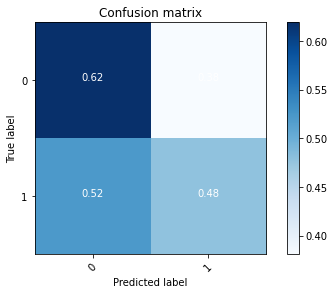

<Figure size 432x288 with 0 Axes>

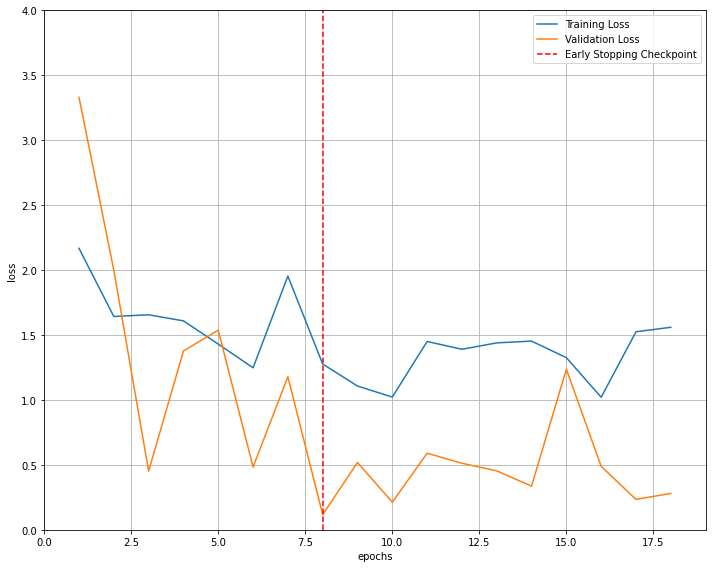

Finished analysis on User 12_attention
Early stopping
Fold  1! Time elapsed: 0.3644089698791504 seconds
Early stopping
Fold  2! Time elapsed: 0.9926586151123047 seconds
Early stopping
Fold  3! Time elapsed: 0.5795705318450928 seconds
Early stopping
Fold  4! Time elapsed: 0.72711181640625 seconds
Normalized confusion matrix


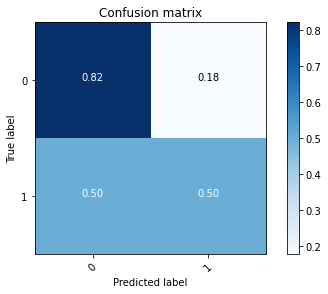

<Figure size 432x288 with 0 Axes>

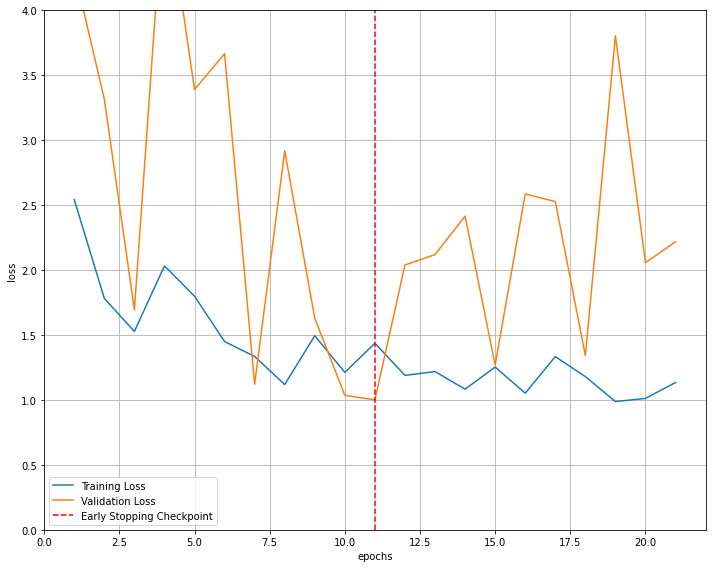

Finished analysis on User 12_interest
Early stopping
Fold  1! Time elapsed: 0.7077288627624512 seconds
Early stopping
Fold  2! Time elapsed: 0.3116905689239502 seconds
Early stopping
Fold  3! Time elapsed: 1.0478174686431885 seconds
Normalized confusion matrix


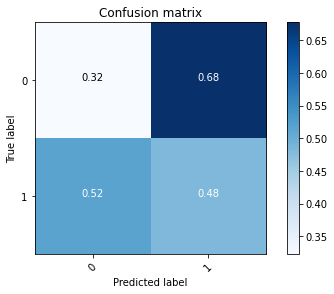

<Figure size 432x288 with 0 Axes>

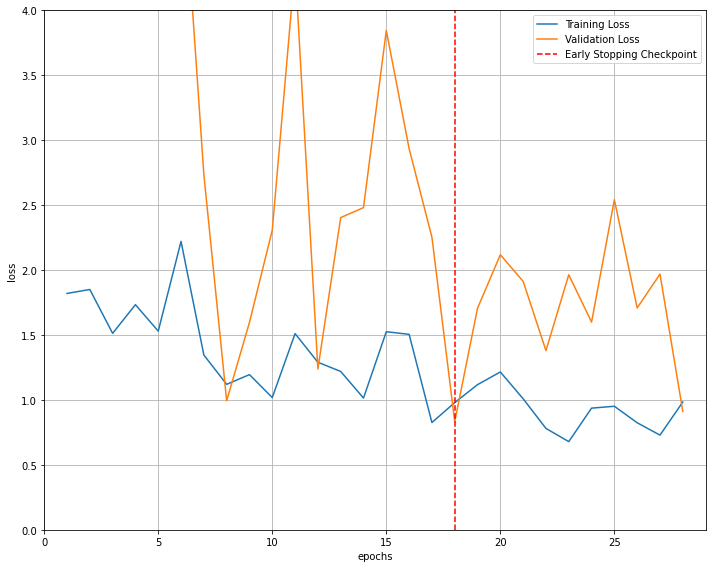

Finished analysis on User 12_effort
Finished analysis on User 12
Working on user 17
Early stopping
Fold  1! Time elapsed: 4.960903167724609 seconds
Early stopping
Fold  2! Time elapsed: 2.977548122406006 seconds
Early stopping
Fold  3! Time elapsed: 3.1557254791259766 seconds
Early stopping
Fold  4! Time elapsed: 13.258771896362305 seconds
Early stopping
Fold  5! Time elapsed: 13.915886402130127 seconds
Normalized confusion matrix


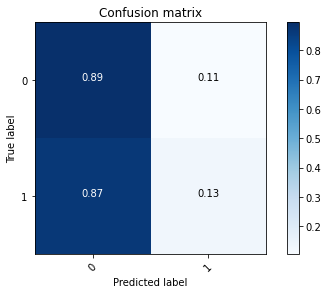

<Figure size 432x288 with 0 Axes>

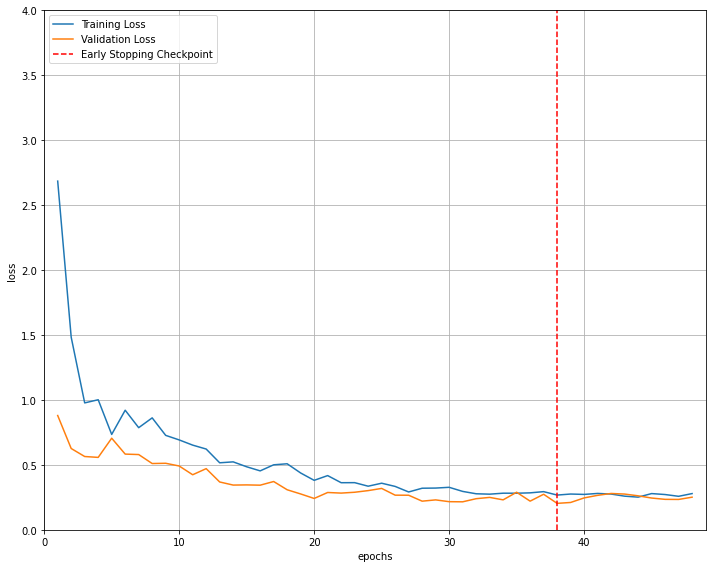

Finished analysis on User 17_attention
Early stopping
Fold  1! Time elapsed: 6.515039920806885 seconds
Early stopping
Fold  2! Time elapsed: 4.703049421310425 seconds
Early stopping
Fold  3! Time elapsed: 3.6613330841064453 seconds
Early stopping
Fold  4! Time elapsed: 2.9844820499420166 seconds
Early stopping
Fold  5! Time elapsed: 23.37248158454895 seconds
Normalized confusion matrix


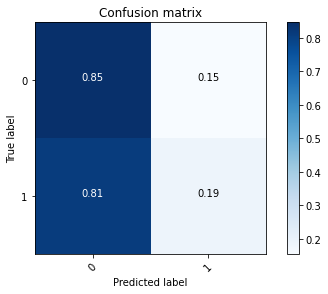

<Figure size 432x288 with 0 Axes>

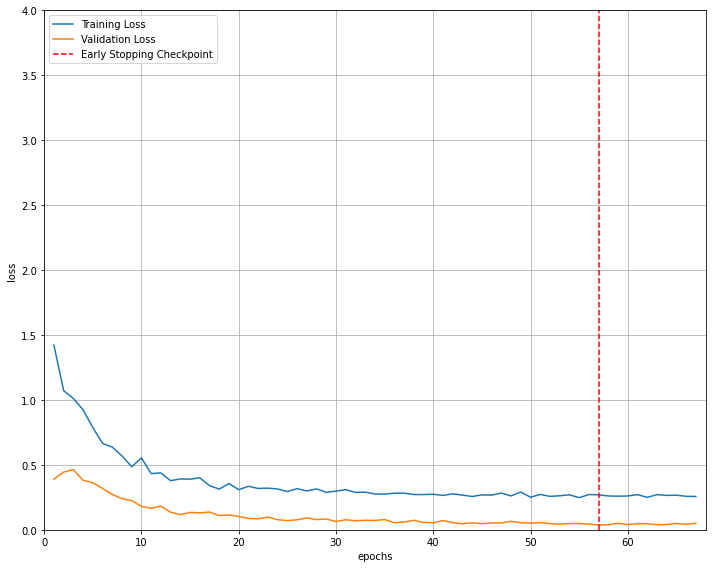

Finished analysis on User 17_interest
Early stopping
Fold  1! Time elapsed: 3.3198020458221436 seconds
Early stopping
Fold  2! Time elapsed: 5.164758920669556 seconds
Early stopping
Fold  3! Time elapsed: 3.1699585914611816 seconds
Early stopping
Fold  4! Time elapsed: 14.918625831604004 seconds
Early stopping
Fold  5! Time elapsed: 3.4258241653442383 seconds
Normalized confusion matrix


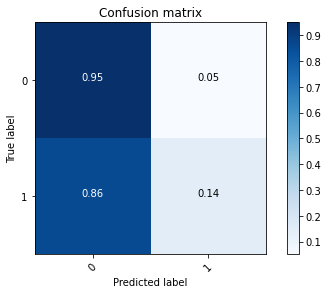

<Figure size 432x288 with 0 Axes>

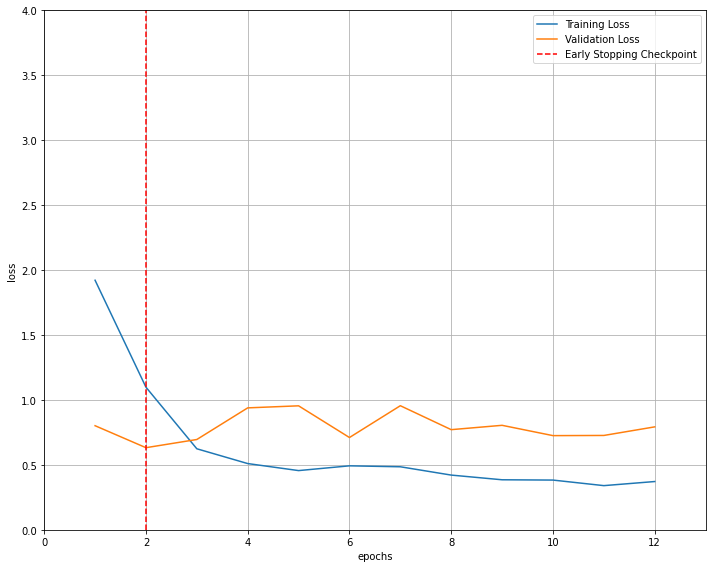

Finished analysis on User 17_effort
Finished analysis on User 17
Working on user 18
Early stopping
Fold  1! Time elapsed: 9.1051664352417 seconds
Early stopping
Fold  2! Time elapsed: 17.3446626663208 seconds
Early stopping
Fold  3! Time elapsed: 10.593145370483398 seconds
Early stopping
Fold  4! Time elapsed: 18.244420766830444 seconds
Early stopping
Fold  5! Time elapsed: 7.452170133590698 seconds
Normalized confusion matrix


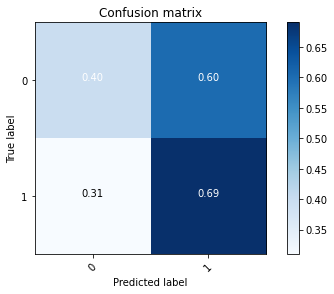

<Figure size 432x288 with 0 Axes>

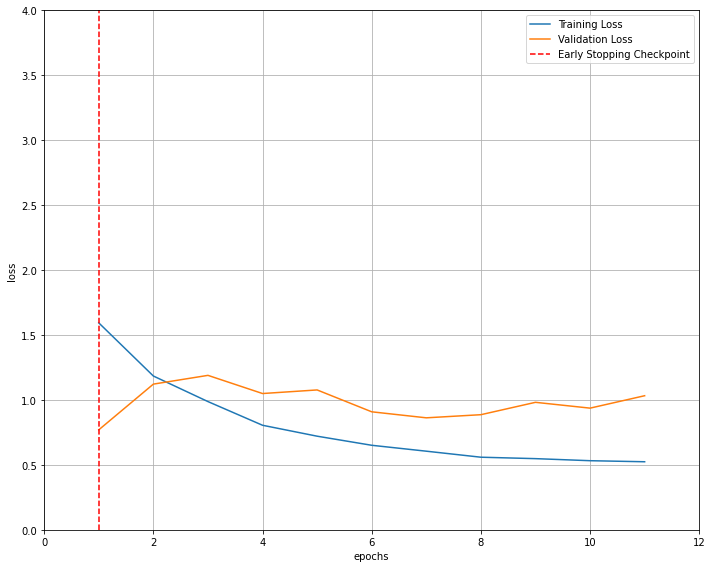

Finished analysis on User 18_attention
Early stopping
Fold  1! Time elapsed: 20.0547616481781 seconds
Early stopping
Fold  2! Time elapsed: 8.017940998077393 seconds
Early stopping
Fold  3! Time elapsed: 22.605953693389893 seconds
Early stopping
Fold  4! Time elapsed: 5.295735836029053 seconds
Normalized confusion matrix


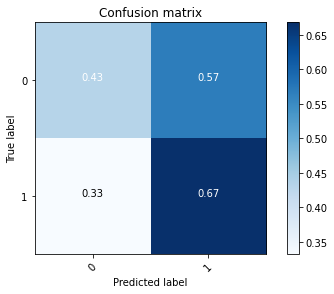

<Figure size 432x288 with 0 Axes>

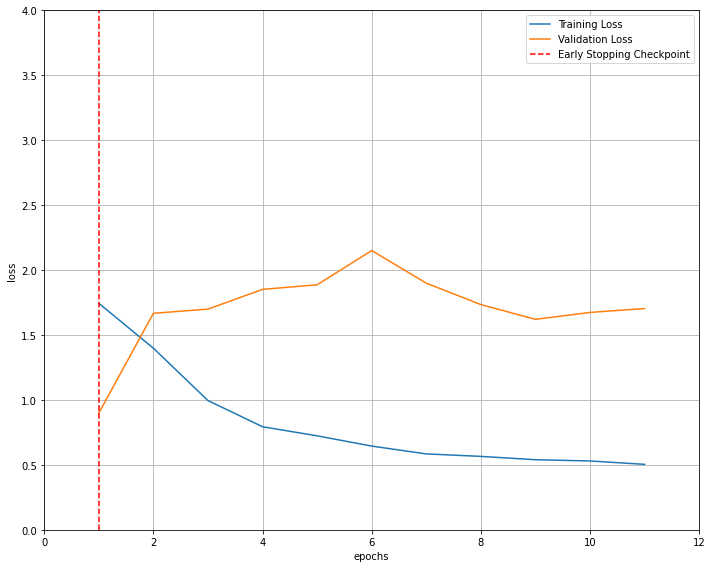

Finished analysis on User 18_interest
Early stopping
Fold  1! Time elapsed: 4.844802618026733 seconds
Early stopping
Fold  2! Time elapsed: 17.411474227905273 seconds
Early stopping
Fold  3! Time elapsed: 5.091756820678711 seconds
Early stopping
Fold  4! Time elapsed: 30.203091382980347 seconds
Early stopping
Fold  5! Time elapsed: 12.43146824836731 seconds
Normalized confusion matrix


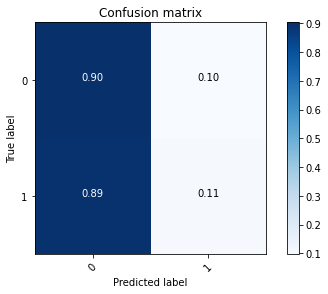

<Figure size 432x288 with 0 Axes>

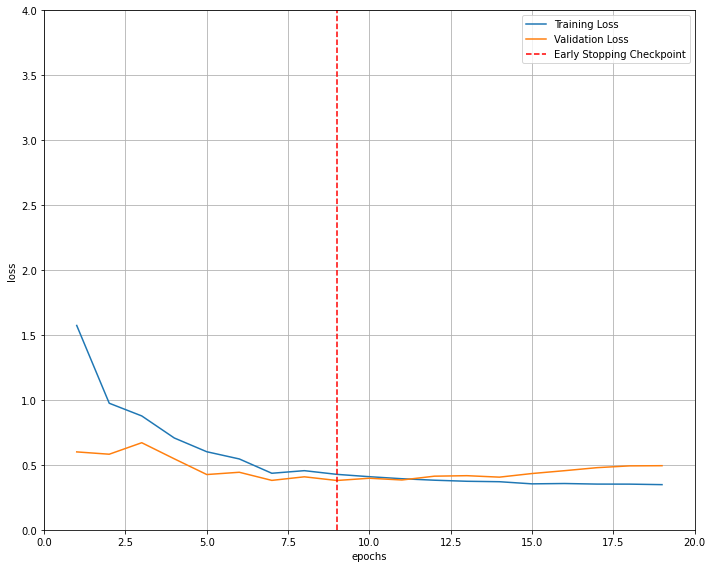

Finished analysis on User 18_effort
Finished analysis on User 18
Working on user 19
Early stopping
Fold  1! Time elapsed: 2.865307569503784 seconds
Early stopping
Fold  2! Time elapsed: 1.4461476802825928 seconds
Early stopping
Fold  3! Time elapsed: 2.8857665061950684 seconds
Early stopping
Fold  4! Time elapsed: 2.9408516883850098 seconds
Normalized confusion matrix


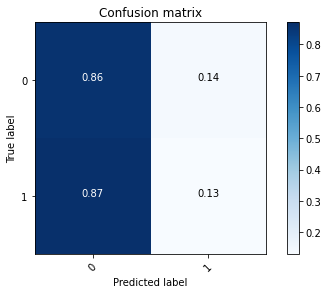

<Figure size 432x288 with 0 Axes>

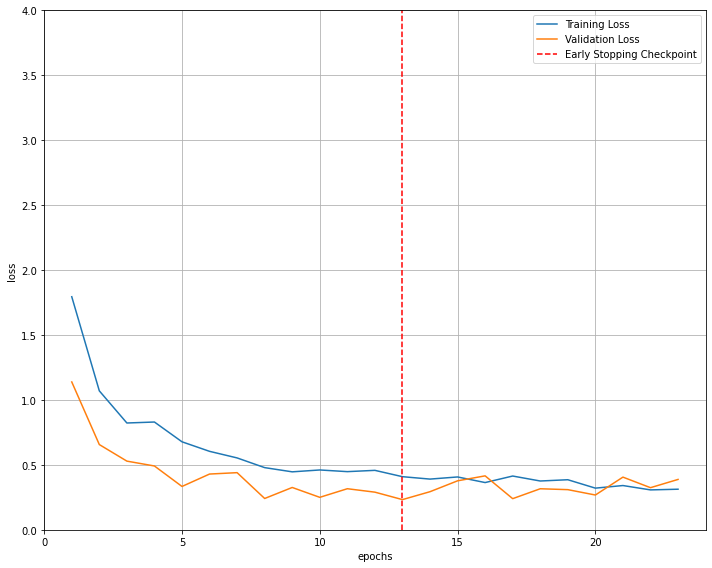

Finished analysis on User 19_attention
Early stopping
Fold  1! Time elapsed: 3.767982244491577 seconds
Early stopping
Fold  2! Time elapsed: 1.3019123077392578 seconds
Early stopping
Fold  3! Time elapsed: 3.341292381286621 seconds
Early stopping
Fold  4! Time elapsed: 1.674107313156128 seconds
Normalized confusion matrix


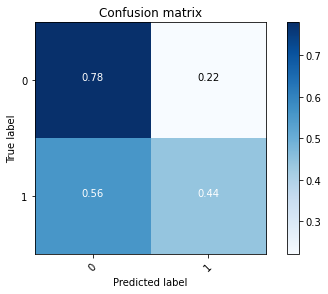

<Figure size 432x288 with 0 Axes>

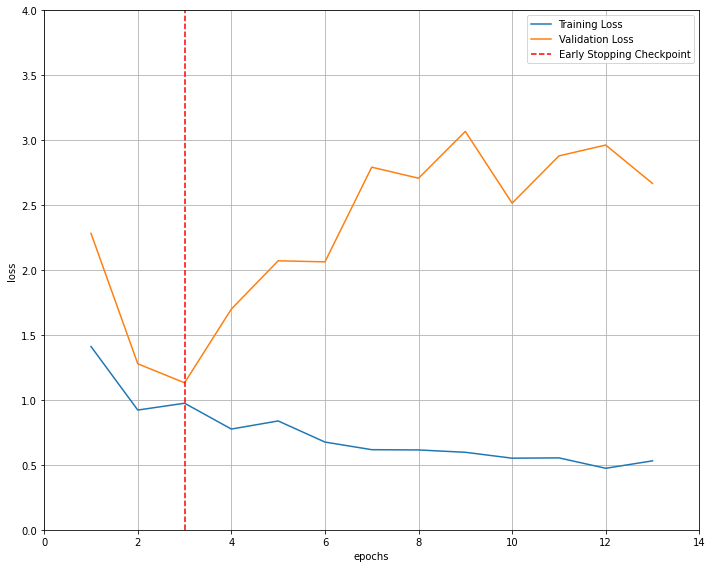

Finished analysis on User 19_interest
Early stopping
Fold  1! Time elapsed: 1.75081205368042 seconds
Early stopping
Fold  2! Time elapsed: 1.856553554534912 seconds
Early stopping
Fold  3! Time elapsed: 1.4237534999847412 seconds
Early stopping
Fold  4! Time elapsed: 4.15304160118103 seconds
Early stopping
Fold  5! Time elapsed: 3.516568183898926 seconds
Normalized confusion matrix


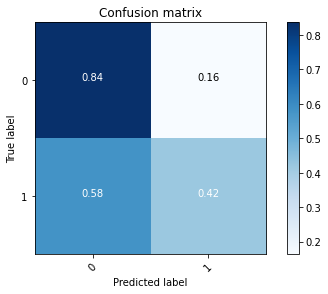

<Figure size 432x288 with 0 Axes>

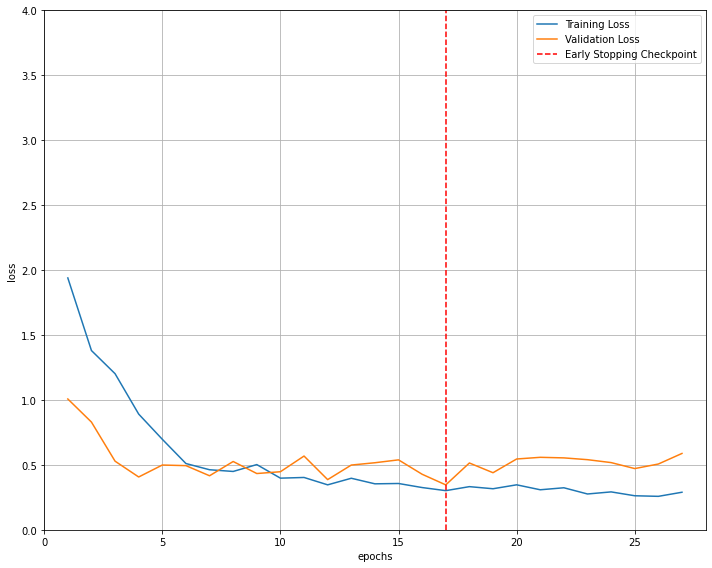

Finished analysis on User 19_effort
Finished analysis on User 19
Working on user 20
Early stopping
Fold  1! Time elapsed: 10.932501077651978 seconds
Early stopping
Fold  2! Time elapsed: 23.399178743362427 seconds
Early stopping
Fold  3! Time elapsed: 11.77949571609497 seconds
Early stopping
Fold  4! Time elapsed: 20.256009101867676 seconds
Early stopping
Fold  5! Time elapsed: 7.024407386779785 seconds
Normalized confusion matrix


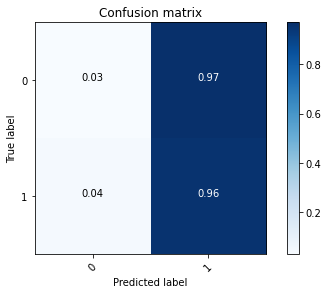

<Figure size 432x288 with 0 Axes>

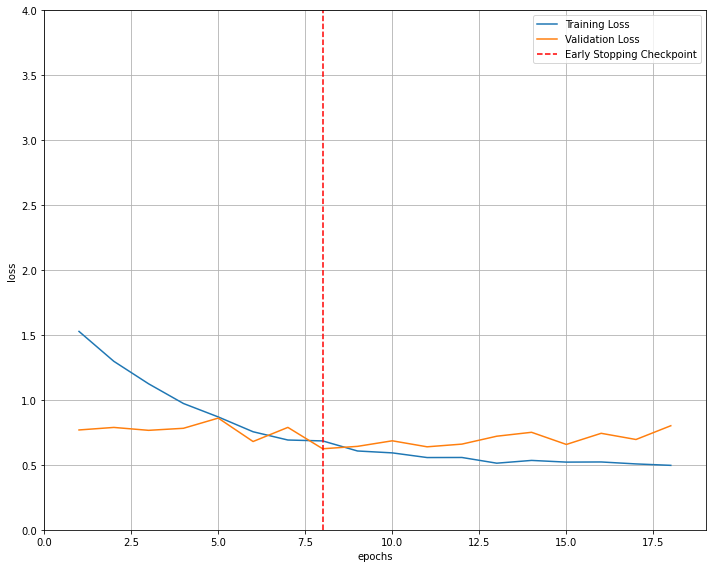

Finished analysis on User 20_attention
Early stopping
Fold  1! Time elapsed: 15.50325870513916 seconds
Early stopping
Fold  2! Time elapsed: 13.864160537719727 seconds
Early stopping
Fold  3! Time elapsed: 12.680754899978638 seconds
Early stopping
Fold  4! Time elapsed: 31.220367670059204 seconds
Early stopping
Fold  5! Time elapsed: 9.691981315612793 seconds
Normalized confusion matrix


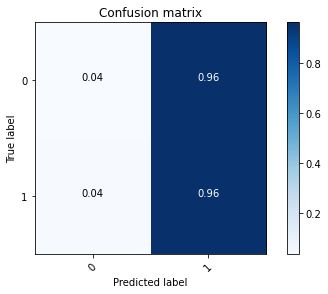

<Figure size 432x288 with 0 Axes>

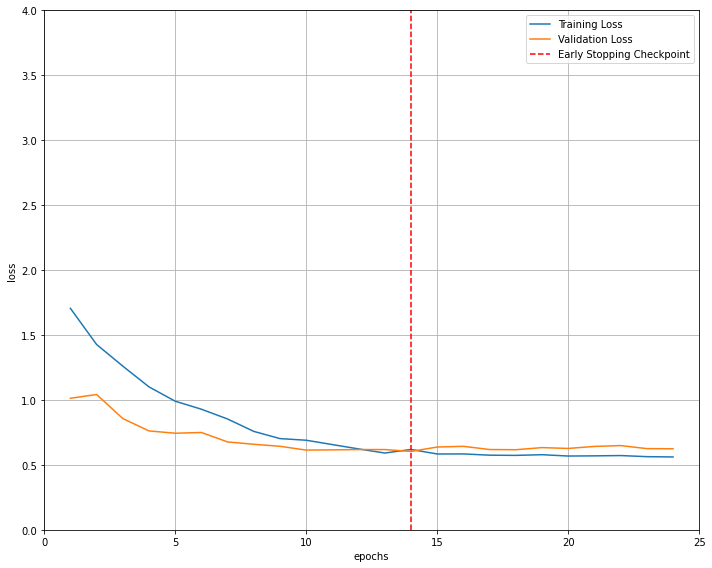

Finished analysis on User 20_interest
Early stopping
Fold  1! Time elapsed: 8.969733953475952 seconds
Early stopping
Fold  2! Time elapsed: 4.14222526550293 seconds
Early stopping
Fold  3! Time elapsed: 13.978631019592285 seconds
Early stopping
Fold  4! Time elapsed: 20.083362340927124 seconds
Early stopping
Fold  5! Time elapsed: 7.780024766921997 seconds
Normalized confusion matrix


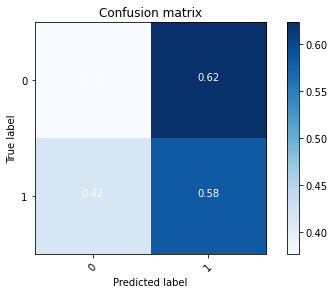

<Figure size 432x288 with 0 Axes>

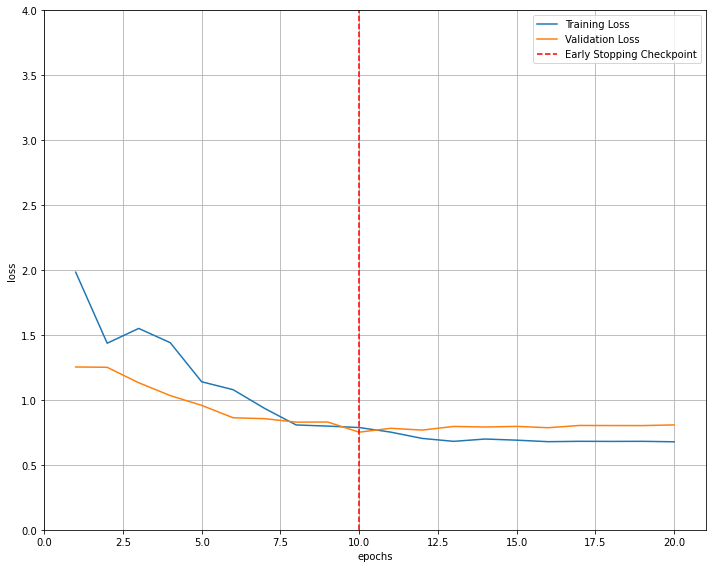

Finished analysis on User 20_effort
Finished analysis on User 20
Working on user 22
Early stopping
Fold  1! Time elapsed: 23.87807822227478 seconds
Early stopping
Fold  2! Time elapsed: 32.12121820449829 seconds
Early stopping
Fold  3! Time elapsed: 7.038943529129028 seconds
Early stopping
Fold  4! Time elapsed: 15.871609449386597 seconds
Early stopping
Fold  5! Time elapsed: 6.449555158615112 seconds
Normalized confusion matrix


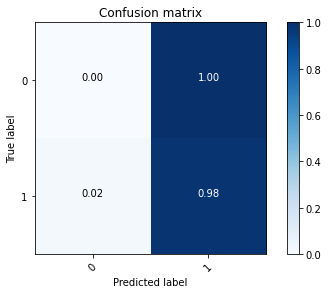

<Figure size 432x288 with 0 Axes>

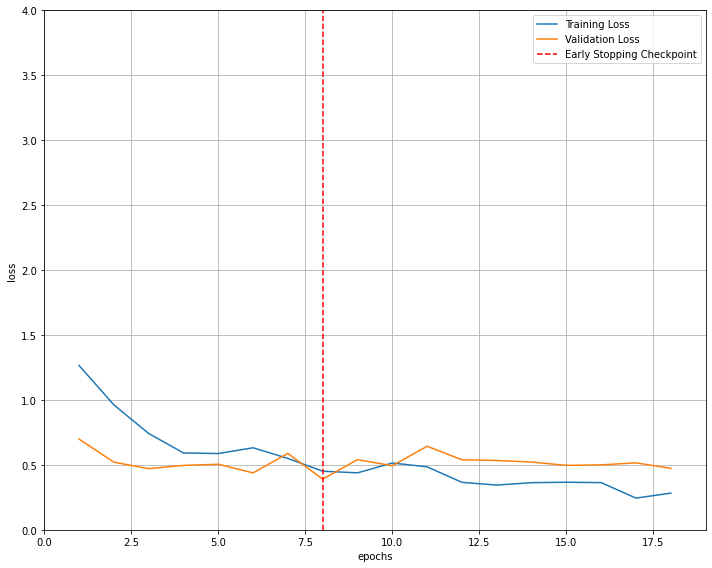

Finished analysis on User 22_attention
Early stopping
Fold  1! Time elapsed: 6.935948133468628 seconds
Early stopping
Fold  2! Time elapsed: 4.016177654266357 seconds
Early stopping
Fold  3! Time elapsed: 9.880097150802612 seconds
Early stopping
Fold  4! Time elapsed: 23.70231604576111 seconds
Normalized confusion matrix


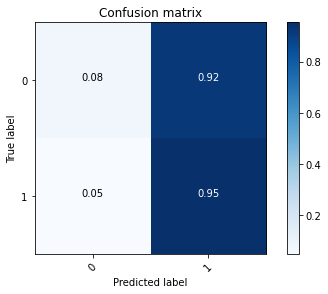

<Figure size 432x288 with 0 Axes>

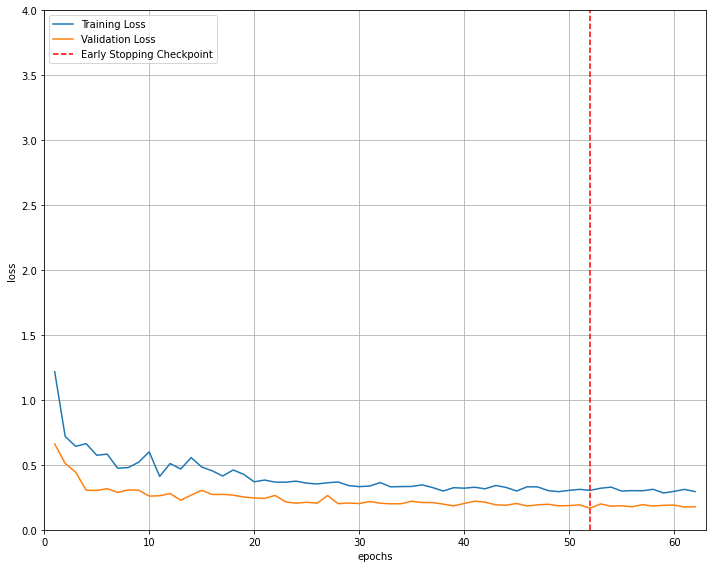

Finished analysis on User 22_interest
Early stopping
Fold  1! Time elapsed: 19.58733057975769 seconds
Early stopping
Fold  2! Time elapsed: 23.711272954940796 seconds
Early stopping
Fold  3! Time elapsed: 17.60310959815979 seconds
Early stopping
Fold  4! Time elapsed: 7.6830384731292725 seconds
Normalized confusion matrix


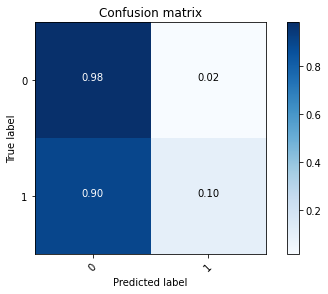

<Figure size 432x288 with 0 Axes>

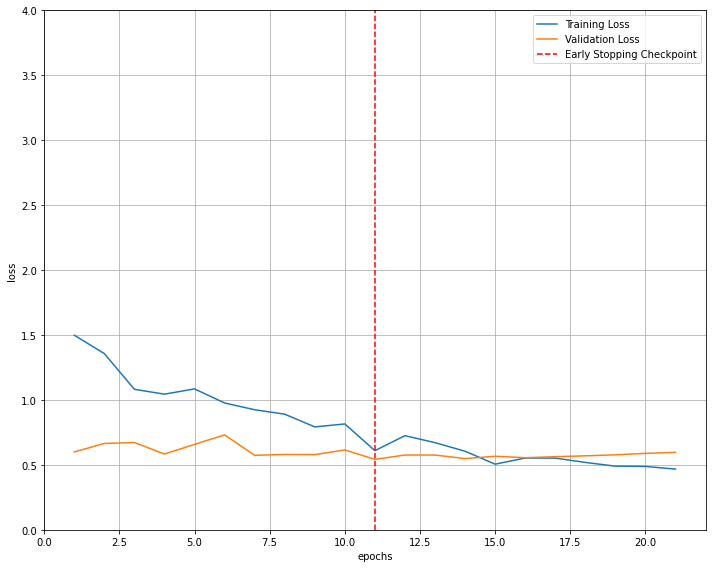

Finished analysis on User 22_effort
Finished analysis on User 22
Working on user 23
Early stopping
Fold  1! Time elapsed: 12.570337295532227 seconds
Early stopping
Fold  2! Time elapsed: 14.484405994415283 seconds
Early stopping
Fold  3! Time elapsed: 13.43704605102539 seconds
Early stopping
Fold  4! Time elapsed: 29.287503480911255 seconds
Early stopping
Fold  5! Time elapsed: 11.676340818405151 seconds
Normalized confusion matrix


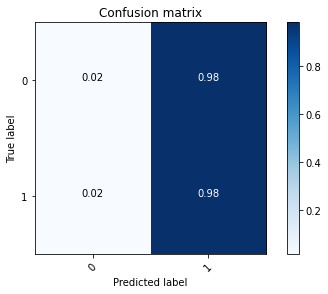

<Figure size 432x288 with 0 Axes>

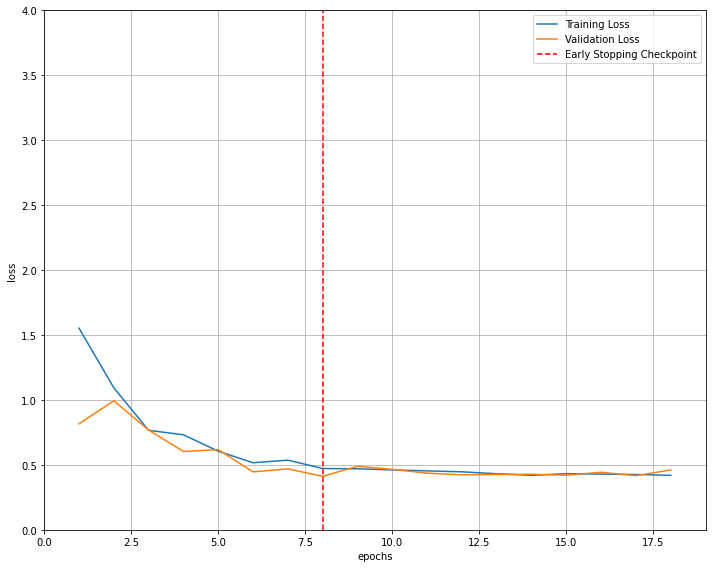

Finished analysis on User 23_attention
Early stopping
Fold  1! Time elapsed: 6.334828615188599 seconds
Early stopping
Fold  2! Time elapsed: 11.27393627166748 seconds
Early stopping
Fold  3! Time elapsed: 7.380745887756348 seconds
Early stopping
Fold  4! Time elapsed: 36.72791051864624 seconds
Early stopping
Fold  5! Time elapsed: 12.033322811126709 seconds
Normalized confusion matrix


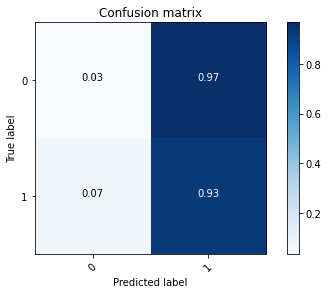

<Figure size 432x288 with 0 Axes>

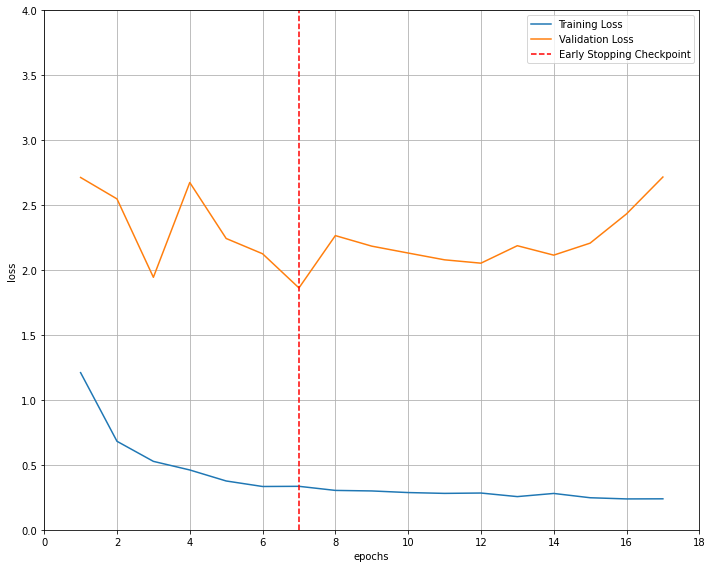

Finished analysis on User 23_interest
Early stopping
Fold  1! Time elapsed: 15.761287450790405 seconds
Early stopping
Fold  2! Time elapsed: 11.826178789138794 seconds
Early stopping
Fold  3! Time elapsed: 8.744260787963867 seconds
Early stopping
Fold  4! Time elapsed: 9.410104751586914 seconds
Normalized confusion matrix


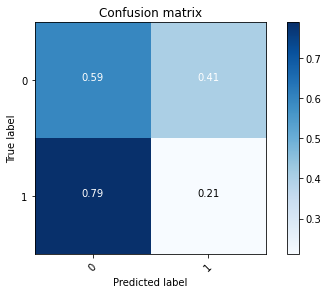

<Figure size 432x288 with 0 Axes>

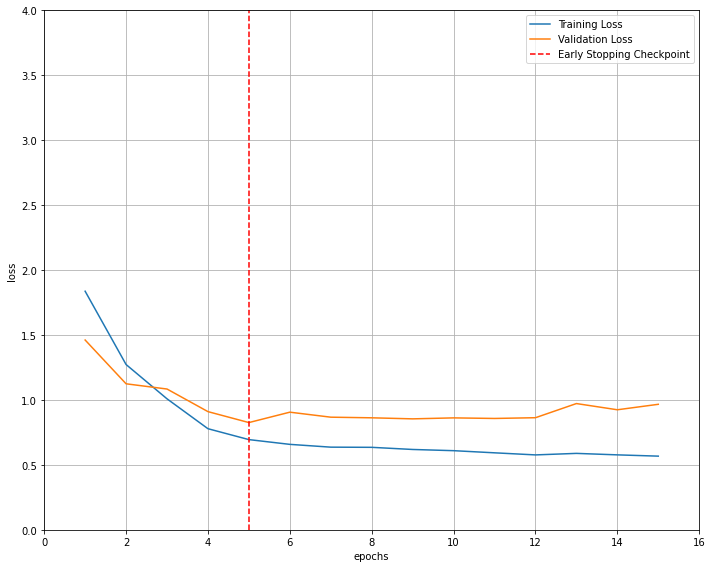

Finished analysis on User 23_effort
Finished analysis on User 23
Working on user 24
Early stopping
Fold  1! Time elapsed: 8.75591254234314 seconds
Early stopping
Fold  2! Time elapsed: 6.477431774139404 seconds
Early stopping
Fold  3! Time elapsed: 3.414853572845459 seconds
Early stopping
Fold  4! Time elapsed: 3.8700637817382812 seconds
Normalized confusion matrix


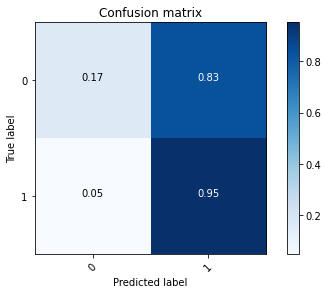

<Figure size 432x288 with 0 Axes>

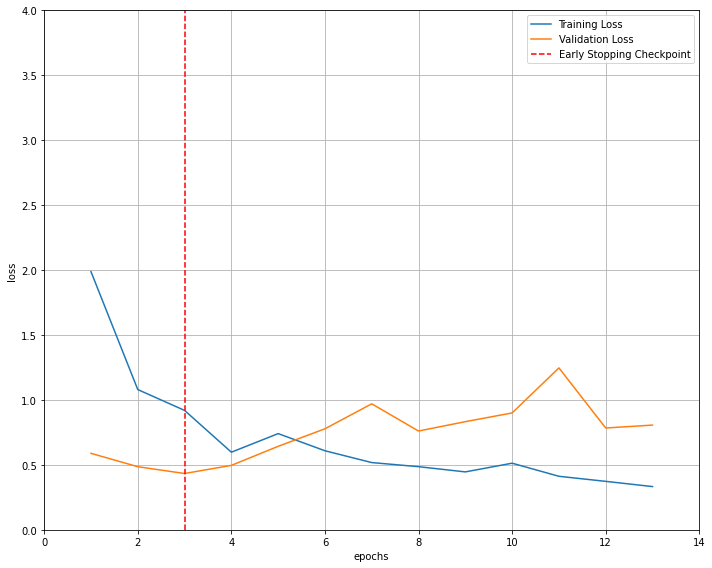

Finished analysis on User 24_attention
Early stopping
Fold  1! Time elapsed: 13.580092668533325 seconds
Early stopping
Fold  2! Time elapsed: 2.987628936767578 seconds
Early stopping
Fold  3! Time elapsed: 3.103654146194458 seconds
Early stopping
Fold  4! Time elapsed: 14.298563003540039 seconds
Normalized confusion matrix


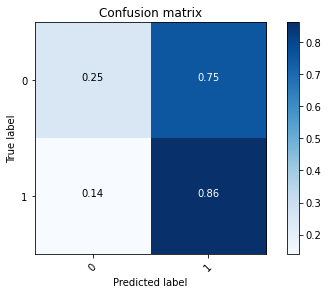

<Figure size 432x288 with 0 Axes>

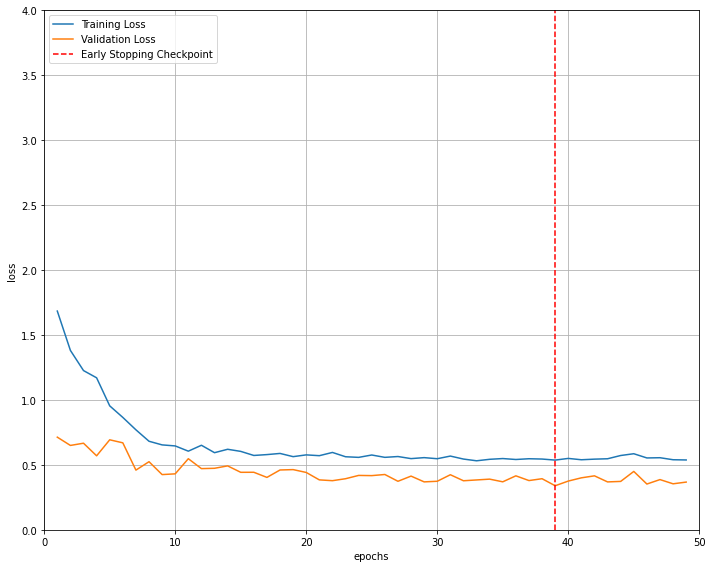

Finished analysis on User 24_interest
Early stopping
Fold  1! Time elapsed: 9.527009010314941 seconds
Early stopping
Fold  2! Time elapsed: 11.321948528289795 seconds
Early stopping
Fold  3! Time elapsed: 8.785001993179321 seconds
Early stopping
Fold  4! Time elapsed: 6.877466678619385 seconds
Normalized confusion matrix


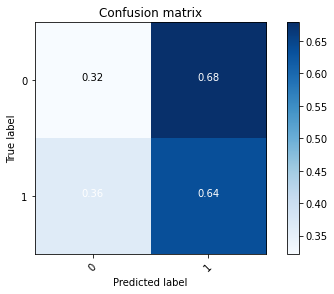

<Figure size 432x288 with 0 Axes>

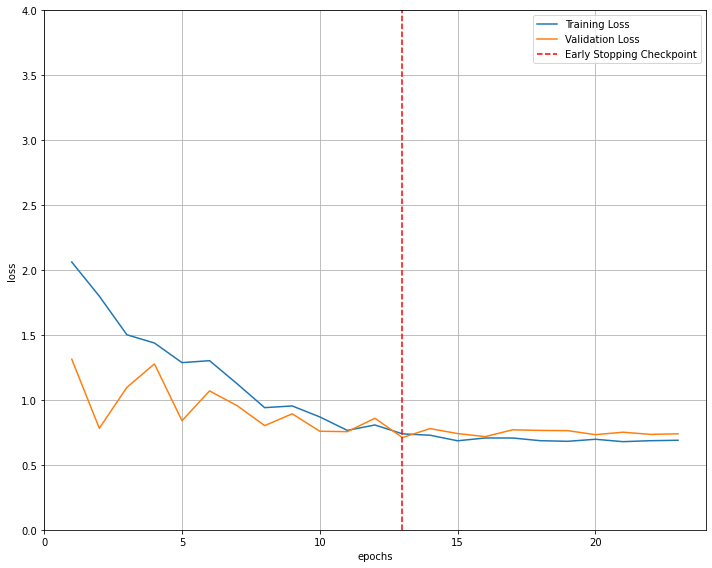

Finished analysis on User 24_effort
Finished analysis on User 24
Working on user 25
Early stopping
Fold  1! Time elapsed: 11.172012329101562 seconds
Early stopping
Fold  2! Time elapsed: 7.896043539047241 seconds
Early stopping
Fold  3! Time elapsed: 9.573550939559937 seconds
Early stopping
Fold  4! Time elapsed: 10.797035455703735 seconds
Early stopping
Fold  5! Time elapsed: 11.982038736343384 seconds
Normalized confusion matrix


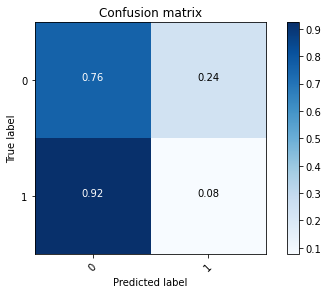

<Figure size 432x288 with 0 Axes>

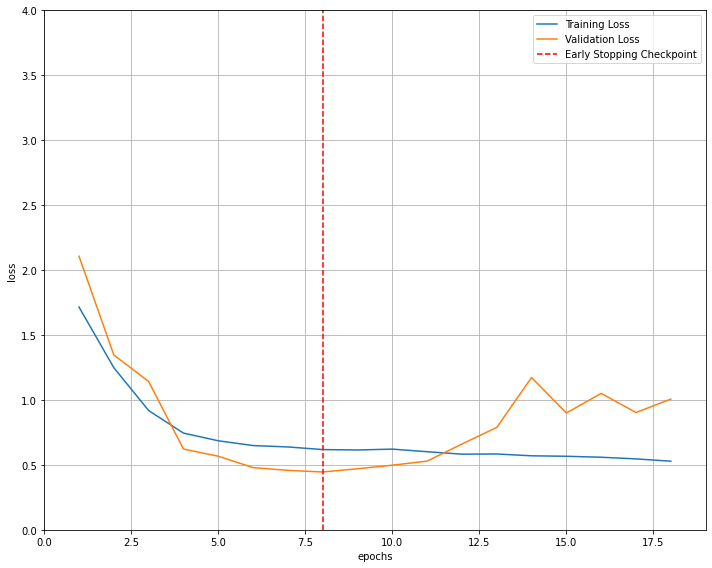

Finished analysis on User 25_attention
Early stopping
Fold  1! Time elapsed: 11.545540571212769 seconds
Early stopping
Fold  2! Time elapsed: 8.494768142700195 seconds
Early stopping
Fold  3! Time elapsed: 8.784183740615845 seconds
Early stopping
Fold  4! Time elapsed: 14.14388918876648 seconds
Early stopping
Fold  5! Time elapsed: 13.107466220855713 seconds
Normalized confusion matrix


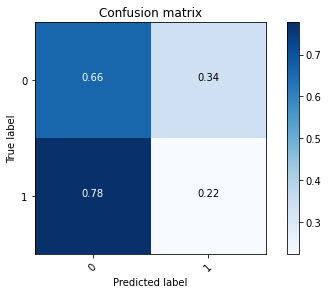

<Figure size 432x288 with 0 Axes>

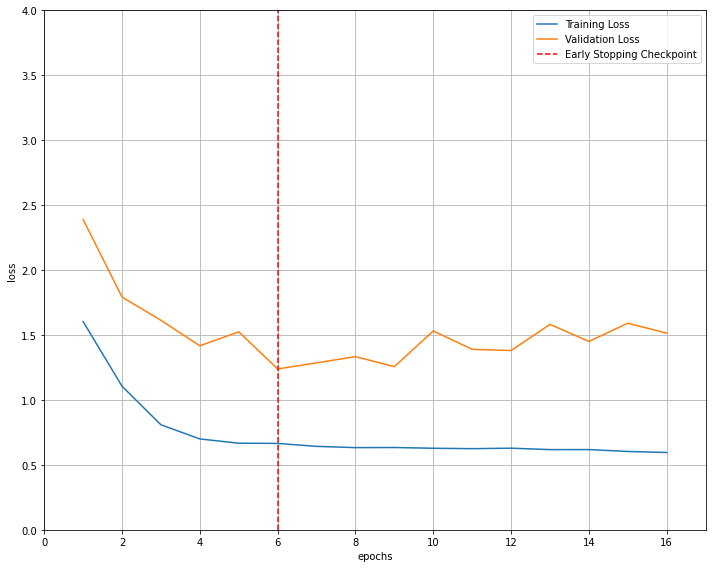

Finished analysis on User 25_interest
Early stopping
Fold  1! Time elapsed: 21.929988145828247 seconds
Early stopping
Fold  2! Time elapsed: 13.67514967918396 seconds
Early stopping
Fold  3! Time elapsed: 11.573873281478882 seconds
Early stopping
Fold  4! Time elapsed: 8.193700075149536 seconds
Early stopping
Fold  5! Time elapsed: 17.214170932769775 seconds
Normalized confusion matrix


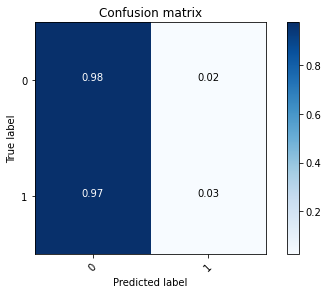

<Figure size 432x288 with 0 Axes>

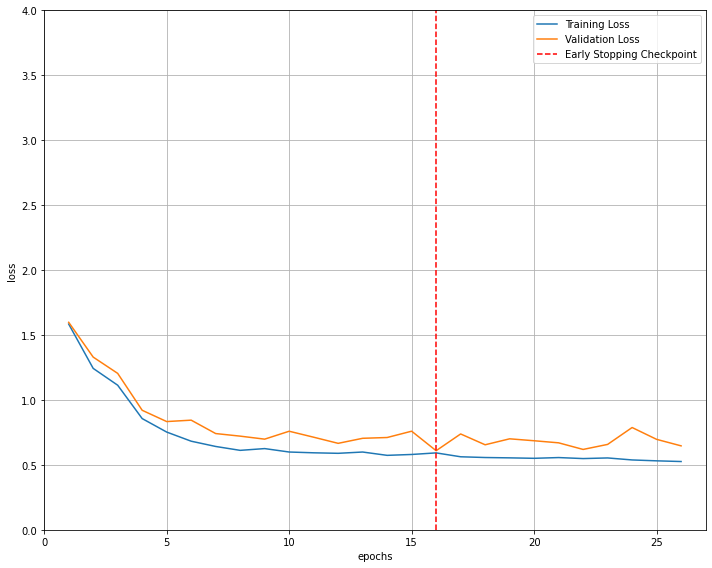

Finished analysis on User 25_effort
Finished analysis on User 25
All analyses are complete! Time elapsed: 3009.464910507202


In [15]:
def run_per_user(model , train_verbose, window_size_samples, fc_size, bandpass, multiple, sigma, augment,class_type):

    time_original = time.time()

    labels = ["attention", "interest", "effort"]

    n_epochs = 100

    patience = 10
    window_size_samples = 120
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_no_agg_bandpass_{1}_slider_{0}.pickle".format(window_size_samples, bandpass)
    all_tests = load_file(saved_file)
    users = list(all_tests.keys())
    model_type = 'clf'
    results = []
    eval_type = 'per user'
    
    for user in users:
        print("Working on user {0}".format(user))

        for label in labels:

            time_start = time.time()
            dt = all_tests[user] # dictionary of all the individual tests per user

            X = np.array([np.array(x).astype(np.float32) for x in dt['inputs']]) # array of all the inputs for each test
            y = np.array([np.array(x) for x in dt[label]]) #Convert the categories into labels

            # K fold predict 
            r, y_pred, y_true, num_classes, size, accuracy, train_loss, valid_loss = kfold_predict(X,y, model_type, 
                                                                                                   model, n_epochs, 
                                                                                                    train_verbose, patience, 
                                                                                                   fc_size, multiple, sigma, augment, class_type)
   
            # get results and add them to the list
            duration = time.time() - time_start
            results.append(collate_results(r, user, label, duration, num_classes, 
                                           size, model_type, n_epochs, window_size_samples, model, multiple, sigma, bandpass,class_type))

            #Save plots
            save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss, bandpass, multiple,sigma , class_type)

            print("Finished analysis on User {0}_{1}".format(user,label))
        print("Finished analysis on User {0}".format(user))
    results  = pd.DataFrame(results)
    results.to_csv("results/CNN/{3}/tabulated/k fold/{2}/{2}_performance_window_size_{0}_{1}_{4}_multiple_{5}_sigma{6}_{7}.csv".format(window_size_samples, 
                                                                                                                                       n_epochs, model, model_type, 
                                                                                                                                       eval_type, multiple, sigma, class_type), index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))
    return results
        
    
def run_cross_user(model , train_verbose, window_size_samples, fc_size, bandpass, multiple, sigma, augment,class_type):
    time_original = time.time()

    labels = ["attention", 'interest', 'effort']
    results = [] # save all results in this list
    patience = 10
    n_epochs = 100
    saved_file = "/cs/home/ybk1/Dissertation/data/saved user and test data/all_users_sampled_{0}_window_annotated_EEG_agg_bandpass_{1}_slider_{0}.pickle".format(window_size_samples, bandpass)
    all_tests_agg = load_file(saved_file)
    users = all_tests_agg.keys()
    model_type = 'clf'
    user ='all'
    eval_type = 'cross user'
   

    for label in labels:
        print("Working on label {0}".format(label))
        time_start = time.time()

        # Store each user in a list to prepare for cross-user analysis
        X = np.array([all_tests_agg[user]['inputs'].astype(np.float32) for user in all_tests_agg])
        y = np.array([all_tests_agg[user][label] for user in all_tests_agg])  

        # train and make predictions
        r, y_pred, y_true, num_classes, size, accuracy, train_loss, valid_loss = kfold_predict(X,y,model_type, model,
                                                                                               n_epochs, train_verbose, 
                                                                                               patience, fc_size, multiple,sigma, augment, class_type)

         # get results
        duration = time.time() - time_start
        results.append(collate_results(r, user, label, duration, num_classes, 
                                       size, model_type, n_epochs, window_size_samples,model, multiple, sigma, bandpass, class_type))
        
        #Save plots
        save_plots(model_type, y_true, y_pred, user, label, n_epochs, model, eval_type, train_loss, valid_loss, bandpass, multiple,sigma, class_type)
                 
        print("Finished analysis on label {0}. Time elapsed {1}".format(label, time.time()-time_start))
    print("Finished analysis on User {0}".format(user))
    results_file = "results/CNN/{3}/tabulated/k fold/{2}/{2}_performance_window_size_{0}_{1}_{4}_dropout_0.9_all_labels_bandpass_{5}_multiple_{6}_sigma_{7}_{8}.csv".format(window_size_samples, n_epochs, model,
                                                                                                                                model_type, eval_type, bandpass, multiple, sigma, class_type)
    results  = pd.DataFrame(results)
    results.to_csv(results_file, index=False )
    final_duration = time.time()- time_original
    print("All analyses are complete! Time elapsed: {0}".format(final_duration))
    return results

# windows = [15, 30, 60, 120, 250]
# fc_sizes = [8, 16, 32, 56, 120]
# for window, fc_size in zip(windows, fc_sizes):

window = 120
fc_size = 56
augment = False
multiples = [5, 20, 30]
sigmas = [0.001, 0.01, 0.1, 0.5]
bandpass = False
class_type = 'binary'
multiple = None 
sigma = None
models = ['Hybrid', 'EEGNet']
# models= 'Hybrid'
results = []
# for multiple in multiples:
#     for sigma in sigmas:
for model in models:
    results.append(run_cross_user(model, False, window, fc_size,bandpass, multiple, sigma, augment, class_type))
    results.append(run_per_user(model, False, window, fc_size,bandpass, multiple, sigma, augment, class_type))

results = pd.concat(results).to_csv("results/bulk/Hybrid_EEGNET_binary_test.csv", index=False)
        